# ANN 6D pose estimator in Tensorflow

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

from scipy import interpolate
from scipy.spatial.transform import Rotation
from scipy.sparse import csr_matrix, vstack, save_npz, load_npz
from scipy.stats import qmc, norm
from scipy.spatial import ConvexHull, Delaunay

from mpl_toolkits.mplot3d import Axes3D



import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Flatten, InputLayer, Conv1D, MaxPooling1D, Flatten, Dense, LeakyReLU, Dropout, BatchNormalization
from keras.losses import mean_squared_error, mean_absolute_percentage_error

from tqdm import tqdm
import time

from bayes_opt import BayesianOptimization
from bayes_opt import SequentialDomainReductionTransformer
from bayes_opt import UtilityFunction
# 1.4.3


from sinfo import sinfo
sinfo()


np.set_printoptions(suppress=True)
np.set_printoptions(formatter={'float': lambda x: "{0:2.5f}".format(x)})


The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
bayes_opt           NA
keras               2.15.0
matplotlib          3.7.1
mpl_toolkits        NA
numpy               1.25.2
pandas              1.5.3
scipy               1.11.4
sinfo               0.3.4
tensorflow          2.15.0
tqdm                4.66.2
-----
IPython             7.34.0
jupyter_client      6.1.12
jupyter_core        5.7.2
notebook            6.5.5
-----
Python 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Linux-6.1.58+-x86_64-with-glibc2.35
8 logical CPU cores, x86_64
-----
Sess

### Initialize Forward Model

In [ ]:
features = {
    'p1': np.array([0, -25, -43.30]),
    'p2': np.array([100, -25, -43.30]),
    'p3': np.array([0, 61.60, -93.30]),
    'p4': np.array([100, 111.60, -6.70]),
    'p5': np.array([100, 25, 43.30]),
    'p6': np.array([0, 111.60, -6.70]),
}

C = 1000
sensors = {
    's1': np.array([0, -C, 0]),
    's2': np.array([C, 0, 0]),
    's3': np.array([0, 0, C])
}

# rigid body transformation x,y,z-axis <------- für trainingsdaten
def p1_xyz(z, w, alpha):
    R_x = Rotation.from_euler('x', alpha[0])
    R_y = Rotation.from_euler('y', alpha[1])
    R_z = Rotation.from_euler('z', alpha[2])
    return R_z.apply(R_y.apply(R_x.apply(z + w)))

# observational function of multilateration
def p2(z, w, alpha, gamma):
    u = p1_xyz(z, w, alpha)
    return np.linalg.norm(u-gamma)

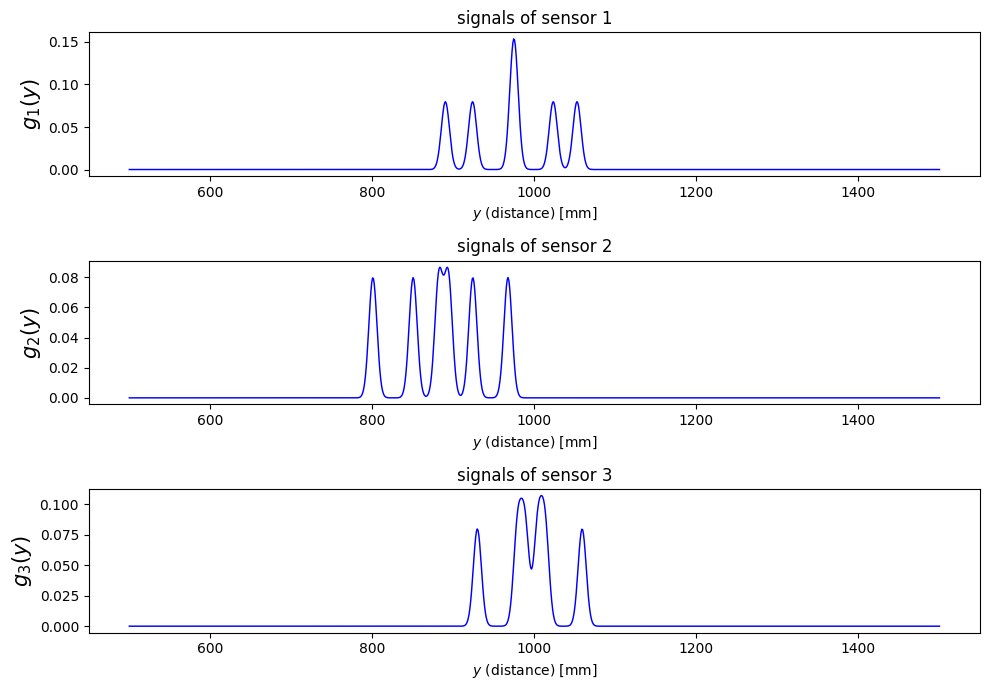

In [ ]:
w0 = np.zeros(3)
V0 = np.zeros(3)

delta_w = np.ones(3)*40
alpha = np.array([0, 0, -np.pi*(4/12)])

w0 = w0 + delta_w
V0 = V0 + alpha

points = np.array(list(features.values()))
points_new = points.copy()

# apply deformation terms
# points_new[:, 0] *= 0.95
# points_new[:, 2] *= 1.05

# plot sensor data
plt.figure(figsize=(10, 7))

g_pdfs = []

for i, (slabel, sensor_pos) in enumerate(sensors.items()):

    distances = []
    for p in points_new:
        distances.append(p2(p, w0, V0, sensor_pos))

    x = np.linspace(500, 1500, 1000)
    y = np.zeros_like(x)
    sigma = 5

    for d in distances:
        # add a gaussian kernel for each distance
        gaussian_norm_const  = 1/(np.sqrt(2*np.pi)*sigma)
        y += gaussian_norm_const * np.exp(-((x - d)**2) / (2 * sigma**2))

    # add noise
    # factor = np.max(y)/10
    # noise = np.random.normal(0, factor , size=y.shape)
    # print(np.max(noise)/np.max(y))
    # y += noise

    # g_pdfs.append(interpolate.interp1d(x, y, kind="cubic"))# fill_value="extrapolate")) #)  #

    # add a subplot for the current sensor
    plt.subplot(len(sensors), 1, i+1)
    plt.plot(x, y, linewidth=1.05, color='b')
    plt.title(f"signals of sensor {i+1}")
    plt.xlabel(fr'$y$ (distance) [mm]')
    plt.ylabel(fr'$g_{i+1}(y)$', fontsize=15, weight='bold')
    plt.grid(False)

plt.tight_layout()
plt.grid(False)
plt.show()


### lhsnorm

In [ ]:
from scipy.stats import qmc, norm

def lhsnorm(mean, std, size):
    num_samples, dim = size

    sampler = qmc.LatinHypercube(d=dim, optimization="random-cd").random(n=num_samples)
    samples_norm = norm(loc=mean, scale=std).ppf(sampler)

    return samples_norm

In [ ]:
def q(z, std, R, lhs_on=False):
    if lhs_on:
        z_samples = lhsnorm(z, std, size=(R, z.shape[0]))
    else:
        z_samples = np.random.normal(z, std, size=(R, z.shape[0]))

    if (z_samples.shape[0] == 1):
        return z_samples[0]

    return z_samples


### drawing R measurements from mixture model

In [ ]:
# sample measurements for each feature point

sampled_feature_pnts = {}
R = 100
std = 5
for feature_label, feature_coords in features.items():
    sampled_feature_pnts[feature_label] = q(feature_coords, std, R, lhs_on=True)

N = len(sampled_feature_pnts)

print((N, R))

(6, 100)


### cost function

In [ ]:
# cost function
def f_cost(x0, *args):
    w, V = x0.reshape(2,3)
    cost_sum = 0.0

    # number of features N
    for _, samples_arr in sampled_feature_pnts.items():

        # number of samples per features R
        for z_vec in samples_arr:
            inner_product = 1.0

            # number of lateration devices L
            for sensor_idx, sensor_coords in enumerate(sensors.values()):
                inner_product *= g_pdfs[sensor_idx](p2(z_vec, w, V, sensor_coords))

            cost_sum += inner_product

    return cost_sum / (N*R)

### Bayesian Optimization

In [ ]:
!pip install bayesian-optimization

In [ ]:
# draw guess pose for inital value of optimization
true_pose = np.concatenate([w0, V0])

dV_max = np.pi*(1/72)   # 2.5 degrees
dw_max = 5              # 5 mm

V_probe = V0 + np.random.uniform(low=-dV_max, high=dV_max, size=3)
w_probe = w0 + np.random.uniform(low=-dw_max, high=dw_max, size=3)

x0_probe = np.concatenate([w_probe, V_probe])
x0_probe

array([38.15253, 41.98590, 41.02626, -0.01465, 0.01399, -1.07904])

In [ ]:
from bayes_opt import BayesianOptimization
from bayes_opt import SequentialDomainReductionTransformer
from bayes_opt import UtilityFunction


# wrapper function to convert input to numpy array
def f_cost_wrapper(w0, w1, w2, V0, V1, V2):
    return f_cost(np.array([w0, w1, w2, V0, V1, V2]))

# define bounds
pbounds = {}
for i in range(len(w_probe)):
    pbounds[f'w{i}'] = (w_probe[i]-dw_max, w_probe[i]+dw_max)
for i in range(len(V_probe)):
    pbounds[f'V{i}'] = (V_probe[i]-dV_max, V_probe[i]+dV_max)


bounds_transformer = SequentialDomainReductionTransformer(minimum_window=dV_max/3)

# create optimizer object
optimizer = BayesianOptimization(f=f_cost_wrapper, pbounds=pbounds, random_state=1, bounds_transformer=bounds_transformer)
optimizer.probe(params=dict(zip(['w0', 'w1', 'w2', 'V0', 'V1', 'V2'], x0_probe)), lazy=True)

# acquisition_function = UtilityFunction(kind="ucb", kappa=5)
# optimizer.maximize(init_points=100, n_iter=50, acquisition_function=acquisition_function)

# best_params = optimizer.max['params']
# best_alpha = np.array(list(best_params.values()))
# best_alpha = np.concatenate([best_alpha[3:], best_alpha[:3]])
# print(best_alpha)

In [ ]:
acquisition_function = UtilityFunction(kind="ei", kappa=1e-1)
optimizer.maximize(init_points=100, n_iter=50, acquisition_function=acquisition_function)
best_params = optimizer.max['params']
best_alpha = np.array(list(best_params.values()))
best_alpha = np.concatenate([best_alpha[3:], best_alpha[:3]])
print(best_alpha)

In [ ]:
best_alpha = np.concatenate([best_alpha[3:], best_alpha[:3]])
best_alpha

array([38.97482, 41.33453, 35.46406, 0.01590, -0.03640, -1.06302])

In [ ]:
print(" True:  " + str(true_pose))
print("Guess:  " + str(np.concatenate((w_probe, V_probe))) + ". RMS: " + str(np.mean(np.sqrt((x0_probe - true_pose)**2))))
print(" Best:  " + str(best_alpha) + ". RMS: " + str(np.mean(np.sqrt((best_alpha - true_pose)**2))))
print(f"Error:  {np.abs(true_pose - best_alpha)}")

 True:  [40.00000 40.00000 40.00000 0.00000 0.00000 -1.04720]
Guess:  [36.86518 44.64520 44.53829 -0.03040 0.00739 -1.01848]. RMS: 2.064135638321931
 Best:  [39.32954 40.78375 40.44222 -0.00511 -0.01193 -1.06136]. RMS: 0.32127133245879147
Error:  [0.67046 0.78375 0.44222 0.00511 0.01193 0.01416]


In [ ]:
# best_alpha = np.concatenate([best_V, best_w])
best_alpha_deg = np.concatenate([best_alpha[:3], best_alpha[3:]*(180/np.pi)])
true_pose_deg = np.concatenate([true_pose[:3], true_pose[3:]*(180/np.pi)])

print(" True: " + str(true_pose_deg))
print(" Best: " + str(best_alpha_deg) + ". RMS: " + str(np.mean(np.sqrt((best_alpha_deg - true_pose_deg)**2))))

 True: [40.00000 40.00000 40.00000 0.00000 0.00000 -60.00000]
 Best: [40.03577 40.12500 38.38738 0.24106 -1.41278 -60.10609]. RMS: 0.5888861220387397


### Run simulations

In [ ]:
def radar_plot(v1, v2, ax):
    num_vars = 6

    # split circle into even parts and save the angles
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    v1 = np.concatenate((v1,[v1[0]]))
    v2 = np.concatenate((v2,[v2[0]]))
    angles += angles[:1]

    # fig, ax = plt.subplots(figsize=(3, 3), subplot_kw=dict(polar=True))

    # draw one axe per variable and add labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(['delta_x', 'delta_y', 'delta_Z', 'roll', 'pitch', 'yaw'])


    # draw ylabels
    ax.set_rlabel_position(30)
    ax.set_yticks([-60, 0, 30], ["-60", "0", "30"], color="grey", size=7)
    ax.set_ylim(-90-6, 60+1)

    # plot data for first vector
    ax.plot(angles, v1, linewidth=1, linestyle='solid', label='True')
    ax.fill(angles, v1, alpha=0.25)

    # plot data for second vector
    ax.plot(angles, v2, linewidth=1, linestyle='solid', label='Prediction')
    ax.fill(angles, v2, alpha=0.25)


In [ ]:
# rotation angles
# ---------------------------
# step_size = (1.8/360)*2*np.pi
step_size = np.pi/18/8

# roll E [0, 360]
roll_range = np.arange(-np.pi/36, np.pi/36 + step_size, step_size) #lhs

# pitch E ]-90, 90[
pitch_range = np.arange(-np.pi/36, np.pi/36 + step_size, step_size) #lhs

# yaw E [0, 360]
# yaw_range = np.arange(-np.pi/3 - np.pi/36, -np.pi/3 + np.pi/36 + step_size, step_size) #lhs
yaw_range = np.arange(-np.pi/36, np.pi/36 + step_size, step_size) #lhs

timesteps = 900
feature_channels = 3
x = np.linspace(500, 1500, timesteps)

In [ ]:
num_rotations = 9#int((np.pi/18)/step_size)

# lhs_roll_range = np.sort(lhs(1, num_rotations , roll_range[0], roll_range[-1]).flatten())
# lhs_pitch_range = np.sort(lhs(1, num_rotations , pitch_range[0], pitch_range[-1]).flatten())
# lhs_yaw_range = np.sort(lhs(1, num_rotations , yaw_range[0], yaw_range[-1]).flatten())
# len(lhs_pitch_range)

In [ ]:

columns = ['w0', 'w1', 'w2', 'V0', 'V1', 'V2', 'ADD']
df_ann = pd.DataFrame(columns=columns)
df_bayes = pd.DataFrame(columns=columns)


- test run 1.
      True pose:      [38.87728 35.94680 37.96600 -4.30919 3.99564 -60.62394]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 9.282e-05 | -0.1026   | 0.05626   | -1.067    | 39.27     | 35.14     | 39.82     |
| 3         | 9.459e-05 | -0.101    | 0.1027    | -1.099    | 40.58     | 35.12     | 38.55     |
| 9         | 0.0001112 | -0.09373  | 0.03745   | -1.1      | 40.67     | 33.06     | 35.62     |
| 34        | 0.0001119 | -0.1011   | 0.03166   | -1.098    | 40.88     | 32.77     | 35.46     |
| 36        | 0.0001125 | -0.1083   | 0.03223   | -1.1      | 40.52     | 32.5      | 35.42     |
| 38        | 0.0001129 | -0.1113   | 0.03466   | -1.101    | 40.66     | 32.67     | 35.45     |
| 49        | 0.0001131 | -0.107    | 0.02966   | -1.101    | 40.82    

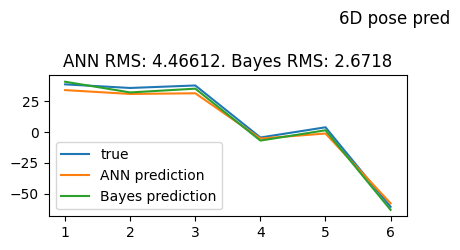


- test run 2.
      True pose:      [37.23943 42.65357 40.42784 -3.48171 -0.85760 -61.35921]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 6.947e-05 | -0.08815  | -0.02845  | -1.08     | 37.63     | 41.85     | 42.28     |
| 5         | 8.253e-05 | -0.02792  | 0.01947   | -1.107    | 32.63     | 39.35     | 44.21     |
| 9         | 8.425e-05 | -0.07929  | -0.04725  | -1.113    | 39.03     | 39.77     | 38.08     |
| 30        | 8.436e-05 | -0.08463  | -0.04488  | -1.113    | 38.36     | 39.49     | 38.04     |
| 34        | 8.457e-05 | -0.0893   | -0.04425  | -1.114    | 38.72     | 39.66     | 38.11     |
| 36        | 8.483e-05 | -0.08636  | -0.04951  | -1.113    | 38.18     | 39.68     | 37.88     |
| 37        | 8.521e-05 | -0.09333  | -0.05525  | -1.113    | 38.18   

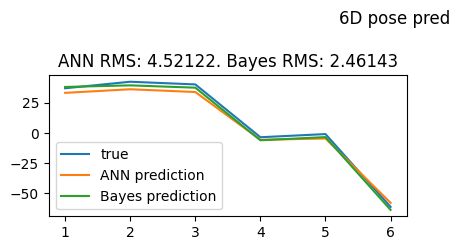


- test run 3.
      True pose:      [41.99018 40.13312 36.53649 -3.61585 -2.87411 -56.64369]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 8.221e-05 | -0.09049  | -0.06364  | -0.9976   | 42.38     | 39.33     | 38.39     |
| 5         | 8.662e-05 | -0.03026  | -0.01573  | -1.025    | 37.38     | 36.83     | 40.32     |
| 9         | 9.154e-05 | -0.08163  | -0.08245  | -1.031    | 43.78     | 37.25     | 34.19     |
| 10        | 9.234e-05 | -0.06384  | -0.08914  | -0.9822   | 38.46     | 41.03     | 38.53     |
| 22        | 9.452e-05 | -0.04974  | -0.0831   | -0.9967   | 37.91     | 41.77     | 39.22     |
| 23        | 9.784e-05 | -0.06181  | -0.09261  | -1.015    | 39.0      | 42.11     | 39.11     |
| 27        | 9.828e-05 | -0.05474  | -0.08349  | -1.026    | 38.78   

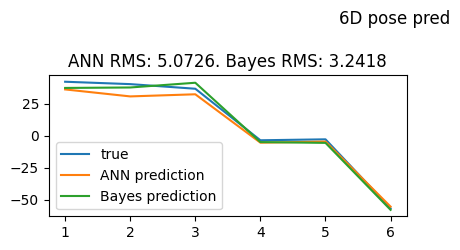


- test run 4.
      True pose:      [44.79869 35.37573 39.52783 -2.93485 -4.61542 -59.79479]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 9         | 5.567e-05 | -0.06974  | -0.1128   | -1.086    | 46.59     | 32.49     | 37.18     |
| 36        | 5.579e-05 | -0.07135  | -0.1177   | -1.086    | 46.45     | 32.13     | 37.33     |
| 40        | 5.639e-05 | -0.07705  | -0.1153   | -1.087    | 46.19     | 31.68     | 37.22     |
| 44        | 5.641e-05 | -0.0784   | -0.1166   | -1.086    | 46.36     | 31.72     | 37.31     |
| 46        | 5.681e-05 | -0.08465  | -0.119    | -1.086    | 46.14     | 31.79     | 37.34     |
| 48        | 5.695e-05 | -0.09004  | -0.1196   | -1.085    | 45.97     | 31.74     | 37.41     |
| 49        | 5.762e-05 | -0.09422  | -0.1224   | -1.086    | 45.81   

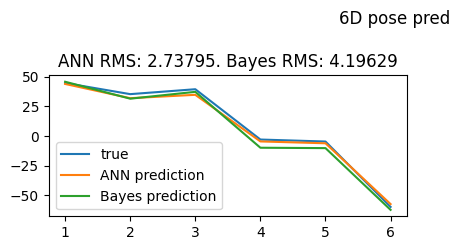


- test run 5.
      True pose:      [43.16706 39.08011 40.18770 1.47106 -2.63062 -60.63726]
1/1 [==============================] - 0s 17ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 4.077e-05 | -0.001704 | -0.05939  | -1.067    | 43.56     | 38.27     | 42.04     |
| 5         | 4.189e-05 | 0.05852   | -0.01148  | -1.095    | 38.56     | 35.78     | 43.97     |
| 6         | 4.605e-05 | -0.009376 | -0.0528   | -1.018    | 43.5      | 41.0      | 38.34     |
| 9         | 4.734e-05 | 0.007155  | -0.0782   | -1.1      | 44.96     | 36.2      | 37.84     |
| 10        | 5.227e-05 | 0.02494   | -0.08489  | -1.052    | 39.63     | 39.97     | 42.19     |
| 28        | 5.749e-05 | 0.03768   | -0.08464  | -1.037    | 38.39     | 40.41     | 40.51     |
| 29        | 5.861e-05 | 0.04382   | -0.08751  | -1.041    | 38.28    

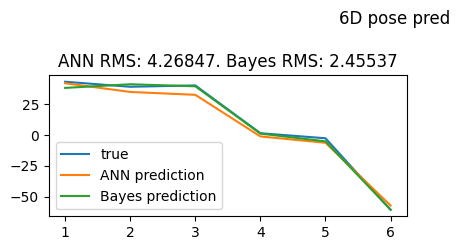


- test run 6.
      True pose:      [36.70387 36.26447 38.73666 -1.58349 -2.75283 -62.10818]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 9         | 6.497e-05 | -0.04616  | -0.08033  | -1.126    | 38.49     | 33.38     | 36.39     |
| 41        | 6.502e-05 | -0.04174  | -0.08003  | -1.127    | 38.34     | 33.34     | 36.39     |
| 43        | 6.52e-05  | -0.03864  | -0.08159  | -1.127    | 38.0      | 33.21     | 36.18     |
| 46        | 6.529e-05 | -0.04475  | -0.07654  | -1.127    | 37.76     | 33.34     | 36.01     |
| 49        | 6.574e-05 | -0.04941  | -0.08265  | -1.126    | 37.86     | 33.18     | 35.98     |
| 50        | 6.641e-05 | -0.04907  | -0.08977  | -1.124    | 37.85     | 33.32     | 35.83     |
| 51        | 6.657e-05 | -0.05323  | -0.08888  | -1.125    | 37.82   

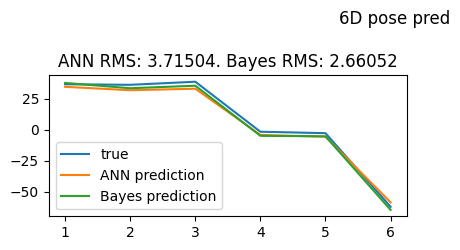


- test run 7.
      True pose:      [44.48448 40.53532 44.61608 3.98775 -2.54410 -56.60254]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 7.123e-05 | 0.04222   | -0.05788  | -0.9969   | 44.87     | 39.73     | 46.47     |
| 10        | 8.112e-05 | 0.06886   | -0.08338  | -0.9814   | 40.95     | 41.43     | 46.61     |
| 29        | 8.245e-05 | 0.07727   | -0.07832  | -0.9775   | 39.49     | 42.32     | 47.57     |
| 31        | 8.305e-05 | 0.07375   | -0.08333  | -0.9844   | 39.5      | 42.88     | 47.22     |
| 33        | 8.342e-05 | 0.07826   | -0.08699  | -0.9846   | 39.49     | 43.13     | 47.43     |
| 53        | 8.355e-05 | 0.08492   | -0.08746  | -0.9784   | 39.49     | 43.13     | 47.5      |
| 56        | 8.356e-05 | 0.08223   | -0.08795  | -0.9788   | 39.49    

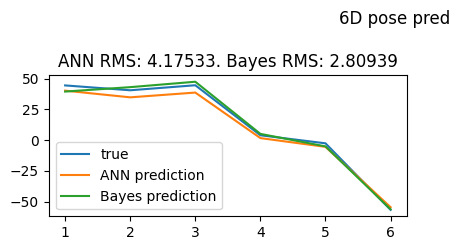


- test run 8.
      True pose:      [38.22603 41.12385 35.00911 -3.51588 -2.84844 -61.56579]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 5         | 7.755e-05 | -0.02852  | -0.01528  | -1.111    | 33.62     | 37.82     | 38.79     |
| 29        | 7.812e-05 | -0.02217  | -0.0131   | -1.118    | 34.65     | 38.54     | 39.99     |
| 30        | 7.939e-05 | -0.01909  | -0.01285  | -1.111    | 33.4      | 39.84     | 39.99     |
| 31        | 8.027e-05 | -0.02389  | -0.01183  | -1.113    | 33.89     | 41.1      | 40.01     |
| 32        | 8.134e-05 | -0.01918  | -0.01667  | -1.115    | 33.23     | 41.07     | 40.01     |
| 37        | 8.216e-05 | -0.02813  | -0.02127  | -1.118    | 33.23     | 40.63     | 39.99     |
| 47        | 8.241e-05 | -0.03481  | -0.01567  | -1.116    | 33.23   

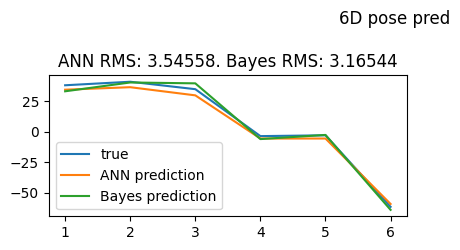


- test run 9.
      True pose:      [42.15137 42.24706 44.12480 2.80611 4.09246 -62.71472]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 6.066e-05 | 0.0216    | 0.05795   | -1.104    | 42.54     | 41.44     | 45.98     |
| 3         | 6.105e-05 | 0.02318   | 0.1044    | -1.136    | 43.86     | 41.42     | 44.71     |
| 7         | 6.238e-05 | 0.06525   | 0.1006    | -1.137    | 44.65     | 47.14     | 46.61     |
| 29        | 6.29e-05  | 0.07833   | 0.1071    | -1.134    | 44.27     | 46.18     | 46.85     |
| 30        | 6.342e-05 | 0.07318   | 0.1018    | -1.137    | 44.3      | 46.06     | 47.08     |
| 35        | 6.353e-05 | 0.078     | 0.09464   | -1.138    | 44.79     | 45.45     | 47.49     |
| 36        | 6.358e-05 | 0.07523   | 0.09007   | -1.138    | 45.08     

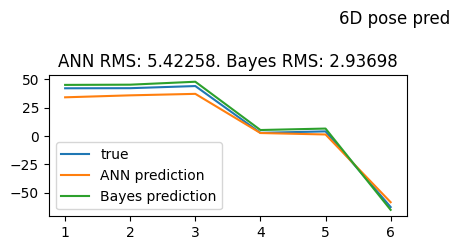


- test run 10.
      True pose:      [38.03508 39.89865 37.99555 -3.27301 -1.87926 -61.46711]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 5         | 7.926e-05 | -0.02428  | 0.001637  | -1.109    | 33.43     | 36.6      | 41.78     |
| 20        | 8.125e-05 | -0.03701  | 0.002858  | -1.11     | 33.64     | 37.18     | 41.51     |
| 27        | 8.207e-05 | -0.03294  | -0.002438 | -1.115    | 34.11     | 37.87     | 41.68     |
| 29        | 8.241e-05 | -0.04447  | 0.004241  | -1.112    | 33.98     | 39.29     | 41.96     |
| 33        | 8.259e-05 | -0.04048  | -0.002837 | -1.109    | 33.04     | 39.52     | 42.18     |
| 36        | 8.338e-05 | -0.03954  | 0.001916  | -1.113    | 33.05     | 40.15     | 41.62     |
| 37        | 8.446e-05 | -0.04157  | 0.006625  | -1.116    | 33.39  

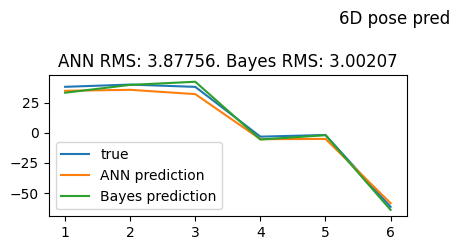


- test run 11.
      True pose:      [43.39671 36.82566 43.77153 3.79448 3.91727 -60.71675]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 7         | 5.786e-05 | 0.0825    | 0.09757   | -1.102    | 45.9      | 41.71     | 46.25     |
| 29        | 5.93e-05  | 0.09558   | 0.104     | -1.099    | 45.52     | 40.76     | 46.5      |
| 30        | 6.036e-05 | 0.102     | 0.108     | -1.103    | 45.6      | 40.81     | 46.56     |
| 43        | 6.075e-05 | 0.109     | 0.1053    | -1.103    | 45.68     | 40.76     | 46.59     |
| 50        | 6.076e-05 | 0.1086    | 0.1094    | -1.103    | 45.53     | 40.77     | 46.45     |
| 52        | 6.077e-05 | 0.1096    | 0.1104    | -1.103    | 45.6      | 40.71     | 46.49     |
| 62        | 6.08e-05  | 0.1094    | 0.1094    | -1.103    | 45.64    

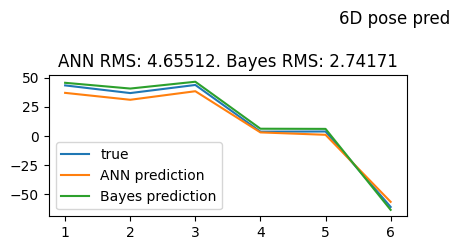


- test run 12.
      True pose:      [37.43954 40.22553 36.10112 -0.20245 -2.96961 -55.84814]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 6.907e-05 | -0.03091  | -0.06531  | -0.9837   | 37.83     | 39.42     | 37.95     |
| 5         | 7.14e-05  | 0.02931   | -0.01739  | -1.011    | 32.83     | 36.92     | 39.88     |
| 9         | 7.388e-05 | -0.02205  | -0.08412  | -1.017    | 39.23     | 37.34     | 33.76     |
| 10        | 7.787e-05 | -0.004269 | -0.09081  | -0.9683   | 33.91     | 41.12     | 38.1      |
| 30        | 7.859e-05 | -0.01155  | -0.08565  | -0.9747   | 33.75     | 39.73     | 36.79     |
| 31        | 8.055e-05 | -0.007882 | -0.08749  | -0.9821   | 33.41     | 38.57     | 36.35     |
| 33        | 8.351e-05 | -0.005706 | -0.09194  | -0.9803   | 32.48  

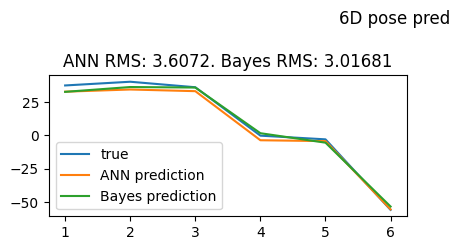


- test run 13.
      True pose:      [39.40121 44.61481 39.75863 1.97495 -1.20316 -55.40762]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 7.163e-05 | 0.00709   | -0.03448  | -0.9761   | 39.79     | 43.81     | 41.61     |
| 6         | 7.189e-05 | -0.000581 | -0.02788  | -0.9271   | 39.73     | 46.53     | 37.91     |
| 10        | 8.326e-05 | 0.03373   | -0.05998  | -0.9606   | 35.87     | 45.51     | 41.76     |
| 23        | 8.348e-05 | 0.04563   | -0.04626  | -0.9452   | 35.78     | 43.48     | 40.18     |
| 24        | 8.513e-05 | 0.035     | -0.05084  | -0.9486   | 35.17     | 45.28     | 40.56     |
| 25        | 8.657e-05 | 0.03161   | -0.06219  | -0.9333   | 36.05     | 45.09     | 39.37     |
| 26        | 8.795e-05 | 0.02682   | -0.05593  | -0.9319   | 34.85   

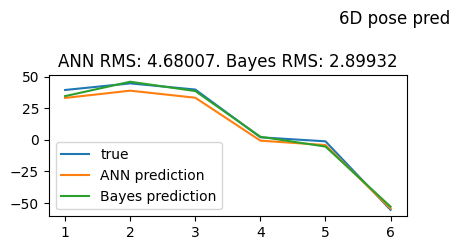


- test run 14.
      True pose:      [43.67789 36.03780 40.66792 -1.34358 3.49864 -58.60631]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 6.767e-05 | -0.05083  | 0.04759   | -1.032    | 44.07     | 35.23     | 42.52     |
| 9         | 7.249e-05 | -0.04197  | 0.02878   | -1.065    | 45.47     | 33.15     | 38.32     |
| 21        | 7.286e-05 | -0.0469   | 0.03591   | -1.066    | 44.87     | 33.18     | 38.89     |
| 24        | 7.333e-05 | -0.03056  | 0.03327   | -1.052    | 42.4      | 33.73     | 41.42     |
| 25        | 7.374e-05 | -0.0248   | 0.02794   | -1.061    | 41.58     | 34.22     | 42.53     |
| 29        | 7.492e-05 | -0.03161  | 0.02803   | -1.054    | 41.28     | 33.48     | 43.4      |
| 31        | 7.543e-05 | -0.03717  | 0.03739   | -1.061    | 41.67   

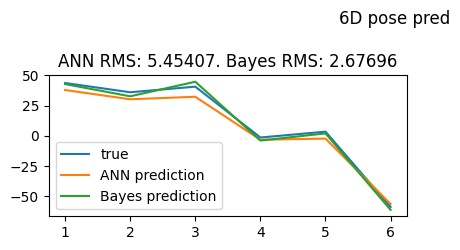


- test run 15.
      True pose:      [38.77643 40.56937 43.14417 3.18473 4.19190 -62.59461]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.805e-05 | 0.02821   | 0.05969   | -1.101    | 39.16     | 39.76     | 45.0      |
| 3         | 5.834e-05 | 0.02979   | 0.1062    | -1.134    | 40.48     | 39.74     | 43.73     |
| 7         | 6.104e-05 | 0.07186   | 0.1024    | -1.135    | 41.28     | 45.46     | 45.63     |
| 29        | 6.147e-05 | 0.08494   | 0.1088    | -1.131    | 40.9      | 44.5      | 45.87     |
| 32        | 6.165e-05 | 0.09322   | 0.1073    | -1.132    | 41.01     | 44.57     | 45.88     |
| 35        | 6.166e-05 | 0.09677   | 0.1001    | -1.136    | 41.5      | 43.95     | 46.29     |
| 37        | 6.212e-05 | 0.09718   | 0.1064    | -1.136    | 41.39    

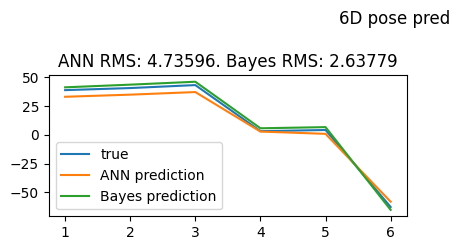


- test run 16.
      True pose:      [36.93927 40.45761 37.77737 0.65919 -4.86898 -56.47348]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.957e-05 | -0.01587  | -0.09846  | -0.9947   | 37.33     | 39.65     | 39.63     |
| 9         | 6.044e-05 | -0.007015 | -0.1173   | -1.028    | 38.73     | 37.57     | 35.43     |
| 10        | 6.906e-05 | 0.01077   | -0.124    | -0.9792   | 33.41     | 41.35     | 39.77     |
| 26        | 6.997e-05 | 0.01966   | -0.1196   | -0.9635   | 33.4      | 41.02     | 38.95     |
| 27        | 7.296e-05 | 0.03041   | -0.1274   | -0.9754   | 33.67     | 39.75     | 38.09     |
| 28        | 7.351e-05 | 0.03919   | -0.1254   | -0.9799   | 33.09     | 38.96     | 37.84     |
| 33        | 7.375e-05 | 0.0338    | -0.125    | -0.975    | 32.86   

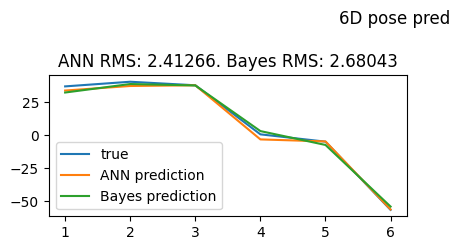


- test run 17.
      True pose:      [37.70453 39.70542 38.33813 -0.58919 1.08182 -55.61697]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 8.061e-05 | -0.03766  | 0.005404  | -0.9797   | 38.09     | 38.9      | 40.19     |
| 5         | 8.792e-05 | 0.02256   | 0.05332   | -1.007    | 33.1      | 36.4      | 42.12     |
| 10        | 9.048e-05 | -0.01102  | -0.0201   | -0.9642   | 34.17     | 40.6      | 40.34     |
| 21        | 9.318e-05 | 0.01763   | -0.01675  | -0.9957   | 34.02     | 41.51     | 41.28     |
| 27        | 9.788e-05 | 0.00218   | -0.02291  | -1.007    | 34.11     | 41.27     | 41.95     |
| 28        | 9.823e-05 | -0.000968 | -0.0176   | -1.013    | 34.05     | 40.73     | 42.21     |
| 29        | 9.847e-05 | 0.006694  | -0.01482  | -1.005    | 32.72   

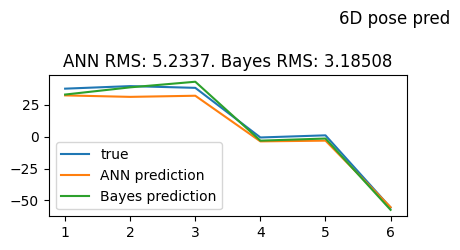


- test run 18.
      True pose:      [41.56659 35.10292 39.56281 2.99057 -2.76409 -58.24477]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 4.99e-05  | 0.02482   | -0.06172  | -1.026    | 41.95     | 34.29     | 41.42     |
| 6         | 5.644e-05 | 0.01714   | -0.05513  | -0.9766   | 41.9      | 37.02     | 37.72     |
| 10        | 6.033e-05 | 0.05146   | -0.08722  | -1.01     | 38.03     | 36.0      | 41.56     |
| 22        | 6.293e-05 | 0.07931   | -0.0815   | -0.983    | 37.86     | 35.88     | 41.29     |
| 24        | 6.303e-05 | 0.06722   | -0.07415  | -0.9778   | 37.57     | 36.05     | 41.17     |
| 25        | 6.362e-05 | 0.05714   | -0.08556  | -0.9867   | 37.31     | 35.7      | 41.52     |
| 27        | 6.437e-05 | 0.06626   | -0.08786  | -0.973    | 36.99   

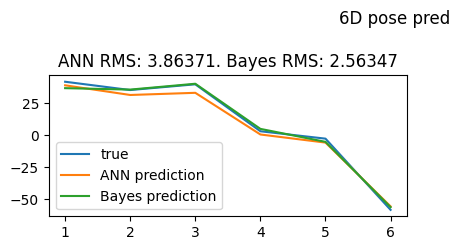


- test run 19.
      True pose:      [40.83397 37.39334 38.22400 2.38555 -2.36572 -57.74003]
1/1 [==============================] - 0s 20ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.295e-05 | 0.01426   | -0.05477  | -1.017    | 41.22     | 36.59     | 40.08     |
| 6         | 5.78e-05  | 0.006585  | -0.04817  | -0.9678   | 41.17     | 39.31     | 36.38     |
| 10        | 6.075e-05 | 0.0409    | -0.08027  | -1.001    | 37.3      | 38.29     | 40.22     |
| 23        | 6.227e-05 | 0.01715   | -0.07352  | -0.9821   | 38.26     | 35.39     | 38.29     |
| 27        | 6.348e-05 | 0.02163   | -0.06781  | -0.9889   | 36.5      | 37.2      | 40.05     |
| 28        | 6.369e-05 | 0.01883   | -0.07406  | -0.9864   | 36.52     | 37.71     | 40.23     |
| 30        | 6.417e-05 | 0.02824   | -0.07187  | -0.9931   | 35.88   

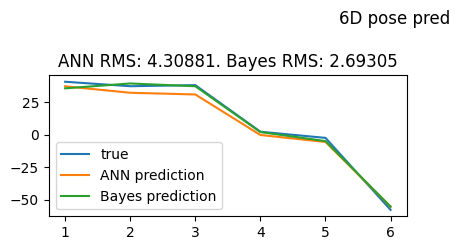


- test run 20.
      True pose:      [37.09427 36.18009 35.64900 0.62712 -1.48723 -58.09282]
1/1 [==============================] - 0s 20ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 4.659e-05 | -0.01643  | -0.03943  | -1.023    | 37.48     | 35.37     | 37.5      |
| 3         | 4.794e-05 | -0.01485  | 0.00704   | -1.055    | 38.8      | 35.35     | 36.24     |
| 6         | 4.811e-05 | -0.02411  | -0.03284  | -0.974    | 37.43     | 38.1      | 33.8      |
| 9         | 5.021e-05 | -0.007575 | -0.05824  | -1.056    | 38.88     | 33.3      | 33.3      |
| 10        | 5.456e-05 | 0.01021   | -0.06493  | -1.007    | 33.56     | 37.07     | 37.65     |
| 23        | 5.674e-05 | -0.002031 | -0.06144  | -0.9885   | 33.59     | 34.32     | 35.51     |
| 24        | 5.716e-05 | -0.007772 | -0.06377  | -1.006    | 33.19   

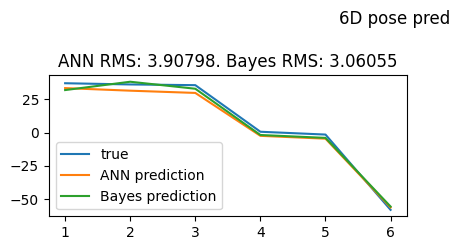


- test run 21.
      True pose:      [44.63126 40.95014 35.16997 1.18176 -2.28672 -58.26903]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 4.636e-05 | -0.006753 | -0.05339  | -1.026    | 45.02     | 40.14     | 37.02     |
| 3         | 4.718e-05 | -0.005166 | -0.006914 | -1.058    | 46.34     | 40.12     | 35.76     |
| 6         | 4.768e-05 | -0.01443  | -0.0468   | -0.977    | 44.96     | 42.87     | 33.33     |
| 9         | 4.797e-05 | 0.002105  | -0.0722   | -1.059    | 46.42     | 38.07     | 32.83     |
| 10        | 5.072e-05 | 0.01989   | -0.07889  | -1.011    | 41.1      | 41.84     | 37.17     |
| 20        | 5.1e-05   | 0.02679   | -0.07143  | -0.9991   | 42.03     | 39.22     | 35.32     |
| 25        | 5.169e-05 | 0.03478   | -0.07759  | -0.9962   | 41.24   

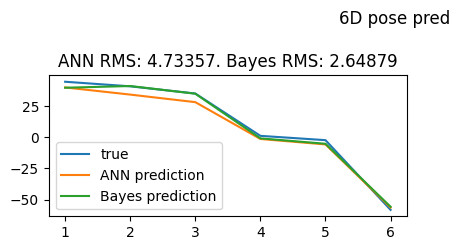


- test run 22.
      True pose:      [39.19681 35.05316 41.37582 3.29751 -0.58693 -58.62416]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.122e-05 | 0.03017   | -0.02372  | -1.032    | 39.58     | 34.25     | 43.23     |
| 6         | 5.657e-05 | 0.0225    | -0.01713  | -0.9832   | 39.53     | 36.97     | 39.53     |
| 10        | 6.111e-05 | 0.05682   | -0.04922  | -1.017    | 35.66     | 35.95     | 43.37     |
| 31        | 6.145e-05 | 0.04635   | -0.05111  | -1.011    | 35.32     | 35.41     | 43.6      |
| 40        | 6.16e-05  | 0.03953   | -0.04571  | -1.01     | 35.17     | 34.94     | 43.51     |
| 43        | 6.185e-05 | 0.03553   | -0.05019  | -1.009    | 35.19     | 34.75     | 43.27     |
| 46        | 6.197e-05 | 0.03115   | -0.04967  | -1.012    | 34.95   

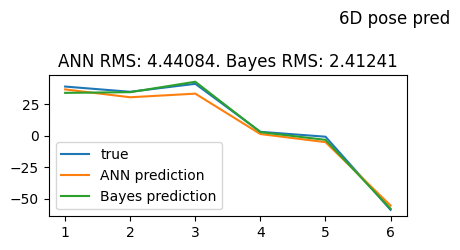


- test run 23.
      True pose:      [35.25605 37.15835 41.08331 2.12468 -0.18591 -61.66060]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.964e-05 | 0.009704  | -0.01672  | -1.085    | 35.64     | 36.35     | 42.94     |
| 6         | 6.065e-05 | 0.002032  | -0.01013  | -1.036    | 35.59     | 39.08     | 39.24     |
| 9         | 6.141e-05 | 0.01856   | -0.03553  | -1.118    | 37.04     | 34.27     | 38.74     |
| 10        | 6.261e-05 | 0.03635   | -0.04222  | -1.07     | 31.72     | 38.05     | 43.08     |
| 13        | 6.308e-05 | 0.005604  | 0.02358   | -1.085    | 31.91     | 41.43     | 39.56     |
| 21        | 6.373e-05 | -0.000343 | -0.000806 | -1.073    | 32.68     | 38.41     | 38.35     |
| 25        | 6.453e-05 | 0.008497  | -0.013    | -1.06     | 32.7    

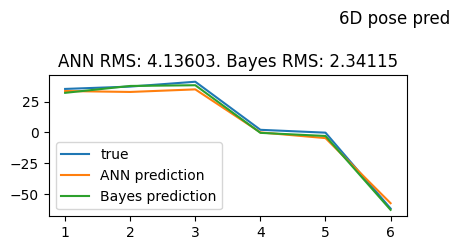


- test run 24.
      True pose:      [35.55387 35.84508 38.87650 0.40576 1.04726 -60.62037]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 3         | 5.343e-05 | -0.01871  | 0.05128   | -1.099    | 37.26     | 35.02     | 39.46     |
| 9         | 5.543e-05 | -0.01144  | -0.01401  | -1.1      | 37.34     | 32.96     | 36.53     |
| 44        | 5.55e-05  | -0.006727 | -0.01016  | -1.101    | 37.25     | 33.19     | 36.47     |
| 57        | 5.559e-05 | -0.004355 | -0.01473  | -1.101    | 37.27     | 33.11     | 36.55     |
| 60        | 5.574e-05 | -0.01107  | -0.0216   | -1.101    | 37.28     | 33.15     | 36.52     |
| 62        | 5.577e-05 | -0.01769  | -0.02062  | -1.101    | 37.26     | 33.14     | 36.48     |
| 64        | 5.592e-05 | -0.02479  | -0.02171  | -1.102    | 37.23    

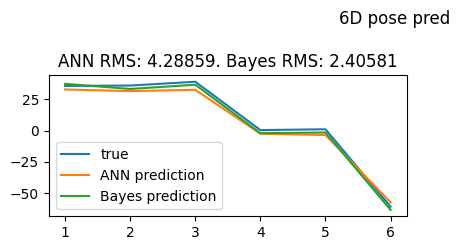


- test run 25.
      True pose:      [43.84181 40.69830 42.33924 0.96086 2.45543 -60.17300]
1/1 [==============================] - 0s 20ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.25e-05  | -0.01061  | 0.02938   | -1.059    | 44.23     | 39.89     | 44.19     |
| 3         | 5.35e-05  | -0.009021 | 0.07585   | -1.091    | 45.55     | 39.87     | 42.93     |
| 9         | 5.661e-05 | -0.00175  | 0.01057   | -1.092    | 45.63     | 37.81     | 39.99     |
| 26        | 5.686e-05 | -0.01389  | 0.01609   | -1.092    | 45.77     | 37.83     | 40.02     |
| 35        | 5.749e-05 | -0.009064 | 0.008927  | -1.093    | 46.27     | 37.17     | 40.43     |
| 40        | 5.768e-05 | -0.01605  | 0.009059  | -1.093    | 46.14     | 37.19     | 40.47     |
| 46        | 5.783e-05 | -0.02151  | 0.004651  | -1.094    | 46.05    

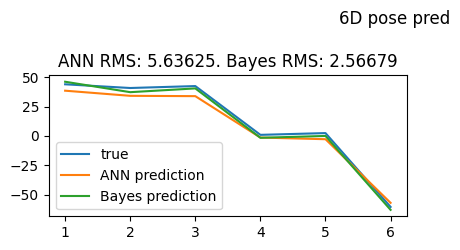


- test run 26.
      True pose:      [35.99547 35.68586 42.75714 3.74406 3.55803 -58.82507]
1/1 [==============================] - 0s 21ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.114e-05 | 0.03797   | 0.04862   | -1.036    | 36.38     | 34.88     | 44.61     |
| 20        | 5.123e-05 | 0.04016   | 0.03201   | -1.036    | 36.69     | 34.85     | 43.73     |
| 23        | 5.13e-05  | 0.03878   | 0.03275   | -1.045    | 35.66     | 34.93     | 44.34     |
| 24        | 5.156e-05 | 0.02229   | 0.01911   | -1.035    | 36.02     | 34.92     | 43.33     |
| 28        | 5.163e-05 | 0.02716   | 0.02259   | -1.024    | 34.4      | 33.2      | 42.51     |
| 39        | 5.173e-05 | 0.02775   | 0.01938   | -1.029    | 34.89     | 32.7      | 42.54     |
| 44        | 5.192e-05 | 0.022     | 0.01921   | -1.026    | 34.68    

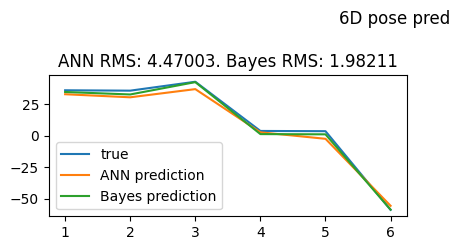


- test run 27.
      True pose:      [35.75366 43.88965 37.19996 -3.60235 -1.83868 -57.66836]
1/1 [==============================] - 0s 20ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 6.931e-05 | -0.09025  | -0.04557  | -1.016    | 36.14     | 43.08     | 39.05     |
| 5         | 7.899e-05 | -0.03003  | 0.002345  | -1.043    | 31.14     | 40.59     | 40.98     |
| 9         | 8.232e-05 | -0.08139  | -0.06438  | -1.048    | 37.54     | 41.01     | 34.86     |
| 10        | 8.348e-05 | -0.06361  | -0.07107  | -1.0      | 32.22     | 44.78     | 39.2      |
| 20        | 8.754e-05 | -0.09276  | -0.073    | -0.9986   | 32.37     | 43.07     | 39.95     |
| 21        | 9.182e-05 | -0.07428  | -0.06926  | -1.008    | 30.93     | 43.52     | 40.33     |
| 25        | 9.183e-05 | -0.05789  | -0.06574  | -1.005    | 30.87  

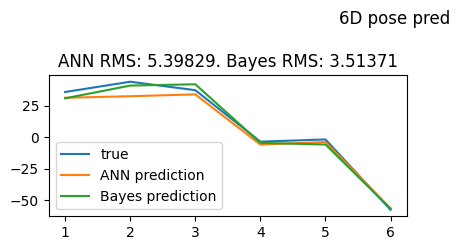


- test run 28.
      True pose:      [42.80250 40.69393 43.93737 0.61760 -2.99484 -56.02279]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 6.664e-05 | -0.0166   | -0.06575  | -0.9868   | 43.19     | 39.89     | 45.79     |
| 9         | 6.814e-05 | -0.007741 | -0.08456  | -1.02     | 44.59     | 37.81     | 41.59     |
| 10        | 7.72e-05  | 0.01004   | -0.09125  | -0.9713   | 39.27     | 41.59     | 45.93     |
| 32        | 7.844e-05 | 0.01891   | -0.09486  | -0.966    | 38.31     | 42.1      | 47.02     |
| 35        | 7.912e-05 | 0.02602   | -0.09047  | -0.9593   | 37.82     | 42.1      | 47.29     |
| 39        | 8.025e-05 | 0.0286    | -0.09578  | -0.9577   | 37.8      | 42.05     | 47.04     |
| 40        | 8.056e-05 | 0.03294   | -0.09557  | -0.9519   | 37.81   

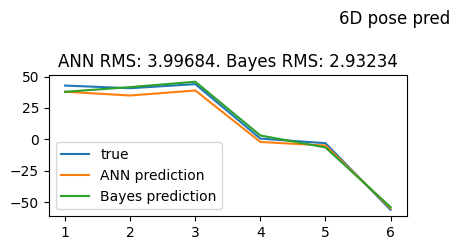


- test run 29.
      True pose:      [44.30184 44.00377 42.58311 -3.33168 4.51852 -57.95650]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 5         | 9.732e-05 | -0.0253   | 0.1133    | -1.048    | 39.69     | 40.7      | 46.36     |
| 9         | 0.0001055 | -0.07667  | 0.04658   | -1.053    | 46.09     | 41.12     | 40.24     |
| 23        | 0.0001078 | -0.08454  | 0.06269   | -1.055    | 43.26     | 41.41     | 42.82     |
| 24        | 0.0001102 | -0.1011   | 0.07055   | -1.054    | 42.19     | 41.26     | 43.68     |
| 25        | 0.0001108 | -0.09349  | 0.0599    | -1.038    | 41.52     | 41.01     | 42.45     |
| 27        | 0.0001113 | -0.09891  | 0.06552   | -1.03     | 40.26     | 40.78     | 43.48     |
| 28        | 0.000113  | -0.08689  | 0.05639   | -1.038    | 39.64   

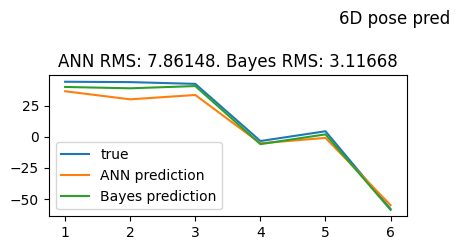


- test run 30.
      True pose:      [36.33092 40.81218 35.58012 3.65680 -2.43575 -61.12560]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.064e-05 | 0.03644   | -0.05599  | -1.076    | 36.72     | 40.0      | 37.43     |
| 6         | 5.74e-05  | 0.02877   | -0.0494   | -1.027    | 36.66     | 42.73     | 33.74     |
| 10        | 6.059e-05 | 0.06309   | -0.08149  | -1.06     | 32.8      | 41.71     | 37.58     |
| 13        | 6.504e-05 | 0.03234   | -0.01569  | -1.076    | 32.98     | 45.09     | 34.06     |
| 21        | 6.51e-05  | 0.04425   | -0.03515  | -1.061    | 33.31     | 43.75     | 34.26     |
| 22        | 6.875e-05 | 0.02057   | -0.02036  | -1.039    | 32.52     | 44.36     | 34.93     |
| 24        | 6.994e-05 | 0.02175   | -0.013    | -1.058    | 31.46   

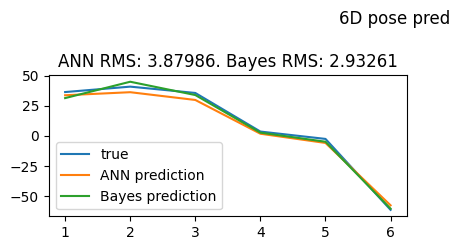


- test run 31.
      True pose:      [37.24157 35.13575 40.59218 4.10833 -4.06846 -60.68104]
1/1 [==============================] - 0s 20ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.168e-05 | 0.04432   | -0.08449  | -1.068    | 37.63     | 34.33     | 42.44     |
| 6         | 5.203e-05 | 0.03665   | -0.07789  | -1.019    | 37.57     | 37.05     | 38.75     |
| 7         | 5.314e-05 | 0.08798   | -0.04181  | -1.101    | 39.74     | 40.02     | 43.07     |
| 8         | 5.461e-05 | 0.05254   | -0.04576  | -1.094    | 36.72     | 39.22     | 38.53     |
| 9         | 5.595e-05 | 0.05318   | -0.1033   | -1.101    | 39.03     | 32.25     | 38.25     |
| 10        | 6.777e-05 | 0.07097   | -0.11     | -1.053    | 33.71     | 36.03     | 42.59     |
| 23        | 7.203e-05 | 0.0892    | -0.09589  | -1.042    | 32.64   

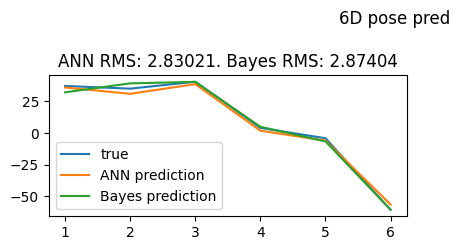


- test run 32.
      True pose:      [36.66003 41.08936 42.12426 3.57172 1.15339 -57.14055]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.711e-05 | 0.03496   | 0.006653  | -1.006    | 37.05     | 40.28     | 43.98     |
| 6         | 5.955e-05 | 0.02729   | 0.01325   | -0.9573   | 36.99     | 43.01     | 40.28     |
| 10        | 6.213e-05 | 0.0616    | -0.01885  | -0.9908   | 33.13     | 41.98     | 44.12     |
| 23        | 6.347e-05 | 0.04217   | -0.01651  | -0.9769   | 34.19     | 39.29     | 42.33     |
| 25        | 6.458e-05 | 0.04537   | -0.01866  | -0.9637   | 34.21     | 39.22     | 42.4      |
| 31        | 6.507e-05 | 0.03587   | -0.01533  | -0.9649   | 34.09     | 39.3      | 42.72     |
| 32        | 6.632e-05 | 0.02738   | -0.01207  | -0.9583   | 34.02    

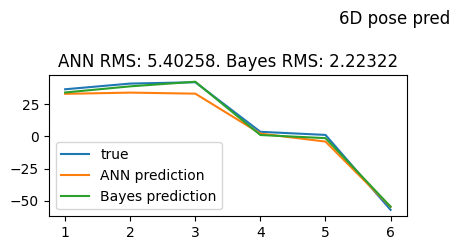


- test run 33.
      True pose:      [36.26665 41.44847 42.36077 -3.42661 -1.94735 -56.34298]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 8.648e-05 | -0.08718  | -0.04746  | -0.9924   | 36.65     | 40.64     | 44.21     |
| 5         | 9.447e-05 | -0.02696  | 0.0004483 | -1.02     | 31.66     | 38.15     | 46.14     |
| 9         | 9.516e-05 | -0.07833  | -0.06627  | -1.025    | 38.06     | 38.56     | 40.02     |
| 10        | 0.0001019 | -0.06054  | -0.07296  | -0.9769   | 32.73     | 42.34     | 44.36     |
| 21        | 0.0001075 | -0.03826  | -0.06077  | -0.9802   | 35.66     | 38.79     | 45.88     |
| 22        | 0.0001137 | -0.0261   | -0.06541  | -0.9741   | 35.31     | 37.39     | 46.61     |
| 23        | 0.0001154 | -0.03218  | -0.07656  | -0.9523   | 34.59  

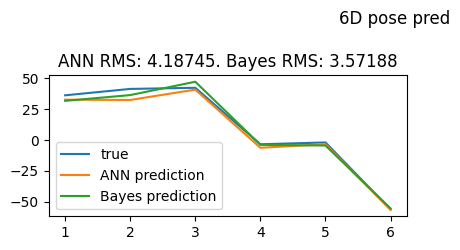


- test run 34.
      True pose:      [40.66859 38.10542 39.91057 4.16333 -0.54347 -55.00414]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 7.251e-05 | 0.04528   | -0.02296  | -0.969    | 41.06     | 37.3      | 41.76     |
| 6         | 7.57e-05  | 0.03761   | -0.01637  | -0.92     | 41.0      | 40.02     | 38.07     |
| 10        | 8.526e-05 | 0.07193   | -0.04846  | -0.9535   | 37.14     | 39.0      | 41.91     |
| 28        | 8.756e-05 | 0.06712   | -0.05072  | -0.94     | 37.17     | 39.3      | 42.12     |
| 30        | 8.787e-05 | 0.05841   | -0.04789  | -0.9428   | 36.95     | 39.16     | 42.21     |
| 36        | 8.88e-05  | 0.05324   | -0.05196  | -0.9356   | 37.1      | 38.77     | 42.66     |
| 38        | 8.994e-05 | 0.04706   | -0.05195  | -0.9288   | 37.36   

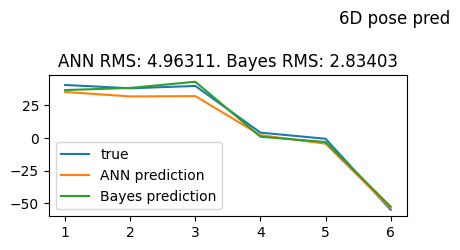


- test run 35.
      True pose:      [40.79159 35.89358 42.17230 -4.89488 -2.56383 -57.36185]
1/1 [==============================] - 0s 20ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 7.591e-05 | -0.1128   | -0.05822  | -1.01     | 41.18     | 35.09     | 44.02     |
| 5         | 8.373e-05 | -0.05259  | -0.01031  | -1.037    | 36.18     | 32.59     | 45.95     |
| 9         | 8.533e-05 | -0.104    | -0.07703  | -1.043    | 42.58     | 33.01     | 39.83     |
| 10        | 9.145e-05 | -0.08617  | -0.08372  | -0.9947   | 37.26     | 36.79     | 44.17     |
| 20        | 9.468e-05 | -0.1153   | -0.08566  | -0.9932   | 37.4      | 35.08     | 44.92     |
| 27        | 9.75e-05  | -0.09955  | -0.08073  | -0.999    | 37.48     | 34.16     | 45.21     |
| 28        | 0.0001001 | -0.1078   | -0.07739  | -0.9985   | 35.83  

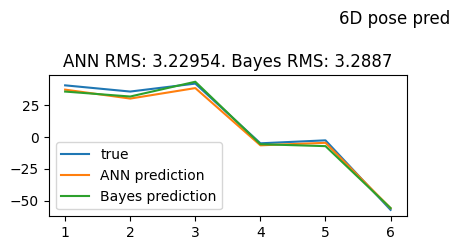


- test run 36.
      True pose:      [40.01888 35.11007 41.40417 4.11888 2.79636 -55.80369]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.895e-05 | 0.04451   | 0.03533   | -0.983    | 40.41     | 34.3      | 43.26     |
| 6         | 6.199e-05 | 0.03684   | 0.04192   | -0.934    | 40.35     | 37.03     | 39.56     |
| 10        | 6.393e-05 | 0.07115   | 0.009829  | -0.9675   | 36.49     | 36.0      | 43.4      |
| 23        | 6.497e-05 | 0.05493   | 0.008633  | -0.9688   | 36.46     | 35.73     | 43.6      |
| 34        | 6.596e-05 | 0.05518   | 0.005517  | -0.9752   | 35.6      | 35.2      | 44.47     |
| 37        | 6.635e-05 | 0.04813   | 0.008593  | -0.9726   | 35.03     | 35.66     | 44.59     |
| 38        | 6.642e-05 | 0.04317   | 0.01037   | -0.9669   | 35.06    

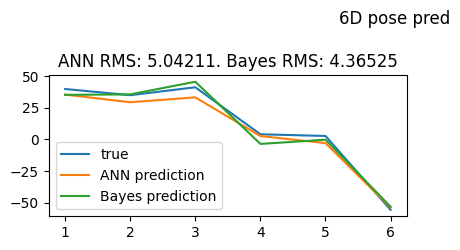


- test run 37.
      True pose:      [44.90736 37.23900 44.18037 0.12516 0.30496 -56.93819]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.877e-05 | -0.02519  | -0.008155 | -1.003    | 45.3      | 36.43     | 46.03     |
| 9         | 6.026e-05 | -0.01634  | -0.02696  | -1.036    | 46.7      | 34.36     | 41.84     |
| 10        | 6.463e-05 | 0.001449  | -0.03365  | -0.9873   | 41.37     | 38.13     | 46.18     |
| 31        | 6.519e-05 | -0.008454 | -0.03441  | -0.9782   | 41.48     | 38.28     | 46.26     |
| 38        | 6.542e-05 | -0.01418  | -0.0297   | -0.9849   | 40.94     | 37.69     | 45.77     |
| 39        | 6.617e-05 | -0.013    | -0.03349  | -0.9921   | 40.75     | 37.2      | 45.4      |
| 40        | 6.666e-05 | -0.01702  | -0.03429  | -0.998    | 40.39    

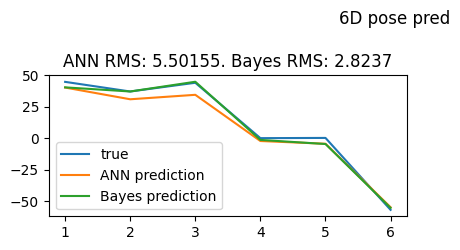


- test run 38.
      True pose:      [44.62075 40.71166 40.11680 3.25900 2.53392 -63.25591]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 6.489e-05 | 0.0295    | 0.03075   | -1.113    | 45.01     | 39.9      | 41.97     |
| 21        | 6.503e-05 | 0.04248   | 0.01565   | -1.141    | 44.83     | 39.91     | 41.89     |
| 22        | 6.55e-05  | 0.03601   | 0.01393   | -1.122    | 44.94     | 39.54     | 41.61     |
| 26        | 6.555e-05 | 0.02337   | 0.0177    | -1.119    | 43.92     | 37.66     | 40.54     |
| 29        | 6.571e-05 | 0.02347   | 0.008878  | -1.129    | 43.17     | 37.98     | 40.32     |
| 32        | 6.572e-05 | 0.02987   | 0.001806  | -1.135    | 43.02     | 38.63     | 39.97     |
| 34        | 6.617e-05 | 0.0289    | 0.01206   | -1.131    | 42.17    

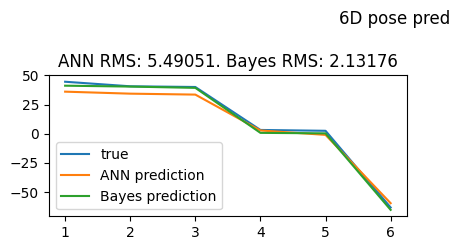


- test run 39.
      True pose:      [37.34255 44.21071 35.66929 2.12377 -2.99761 -63.02288]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 6.168e-05 | 0.009688  | -0.0658   | -1.109    | 37.73     | 43.4      | 37.52     |
| 5         | 6.183e-05 | 0.06991   | -0.01788  | -1.136    | 32.73     | 40.91     | 39.45     |
| 9         | 6.7e-05   | 0.01855   | -0.0846   | -1.142    | 39.13     | 41.33     | 33.32     |
| 10        | 7.124e-05 | 0.03633   | -0.09129  | -1.093    | 33.81     | 45.1      | 37.67     |
| 22        | 7.376e-05 | 0.05988   | -0.09217  | -1.1      | 33.78     | 44.77     | 37.41     |
| 23        | 7.538e-05 | 0.05458   | -0.0778   | -1.103    | 33.26     | 44.44     | 37.02     |
| 28        | 7.64e-05  | 0.05757   | -0.08319  | -1.097    | 32.36   

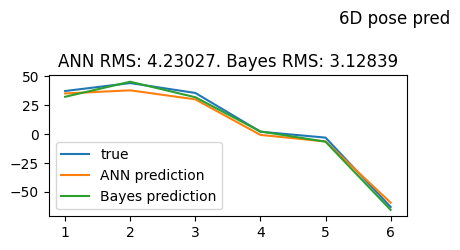


- test run 40.
      True pose:      [43.13932 41.13688 44.79575 1.87140 4.06952 -58.04381]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.5e-05   | 0.005283  | 0.05755   | -1.022    | 43.53     | 40.33     | 46.65     |
| 10        | 5.582e-05 | 0.03193   | 0.03205   | -1.007    | 39.61     | 42.03     | 46.79     |
| 24        | 5.661e-05 | 0.03566   | 0.04454   | -1.029    | 42.13     | 41.24     | 48.0      |
| 26        | 5.699e-05 | 0.0185    | 0.04646   | -1.038    | 42.75     | 41.67     | 47.41     |
| 29        | 5.784e-05 | 0.01457   | 0.04627   | -1.042    | 42.85     | 41.72     | 48.21     |
| 31        | 5.786e-05 | 0.01793   | 0.0411    | -1.04     | 43.62     | 42.18     | 48.62     |
| 32        | 5.805e-05 | 0.01856   | 0.04843   | -1.045    | 43.24    

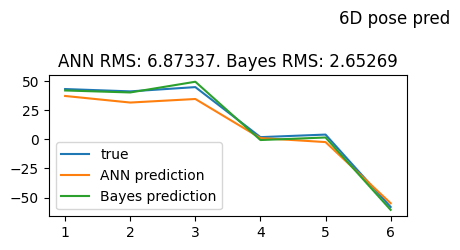


- test run 41.
      True pose:      [35.55434 44.63057 35.56046 -1.86029 1.43220 -64.68593]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 8.685e-05 | -0.05985  | 0.01152   | -1.138    | 35.94     | 43.82     | 37.41     |
| 21        | 8.779e-05 | -0.06409  | 0.03388   | -1.159    | 36.5      | 43.44     | 37.66     |
| 27        | 8.871e-05 | -0.06018  | 0.0232    | -1.168    | 35.99     | 43.1      | 37.6      |
| 29        | 8.879e-05 | -0.05464  | 0.01687   | -1.162    | 34.47     | 41.68     | 36.37     |
| 30        | 8.953e-05 | -0.06363  | 0.02056   | -1.161    | 33.79     | 41.17     | 36.86     |
| 31        | 9.137e-05 | -0.07235  | 0.02911   | -1.162    | 33.13     | 41.9      | 36.36     |
| 33        | 9.316e-05 | -0.07507  | 0.03282   | -1.158    | 32.14   

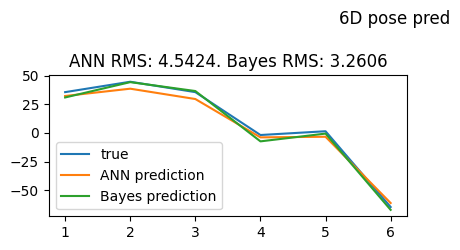


- test run 42.
      True pose:      [39.34068 41.66886 44.59594 4.92381 4.58812 -59.61649]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 5         | 6.157e-05 | 0.1188    | 0.1145    | -1.077    | 34.73     | 38.37     | 48.38     |
| 17        | 6.181e-05 | 0.1211    | 0.08651   | -1.084    | 40.51     | 39.94     | 44.87     |
| 26        | 6.238e-05 | 0.1267    | 0.09397   | -1.083    | 40.28     | 40.17     | 44.58     |
| 27        | 6.245e-05 | 0.1265    | 0.09757   | -1.077    | 38.38     | 39.55     | 43.66     |
| 31        | 6.306e-05 | 0.1263    | 0.1039    | -1.082    | 38.66     | 40.09     | 44.15     |
| 32        | 6.319e-05 | 0.1233    | 0.1128    | -1.081    | 37.59     | 40.41     | 43.35     |
| 34        | 6.347e-05 | 0.1237    | 0.1149    | -1.082    | 36.82    

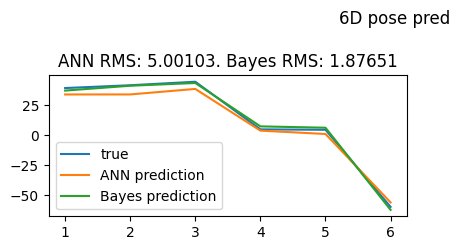


- test run 43.
      True pose:      [38.79309 39.49663 40.20671 -2.89873 3.18585 -64.61424]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 9.482e-05 | -0.07797  | 0.04213   | -1.137    | 39.18     | 38.69     | 42.06     |
| 23        | 9.602e-05 | -0.07954  | 0.02352   | -1.139    | 39.2      | 38.58     | 41.7      |
| 26        | 0.0001003 | -0.09027  | 0.03765   | -1.155    | 38.77     | 38.41     | 41.65     |
| 28        | 0.0001003 | -0.08204  | 0.0279    | -1.16     | 38.46     | 38.41     | 41.56     |
| 29        | 0.000101  | -0.09379  | 0.03207   | -1.151    | 37.15     | 37.84     | 41.11     |
| 31        | 0.0001011 | -0.08991  | 0.03719   | -1.156    | 36.39     | 37.6      | 41.01     |
| 33        | 0.0001018 | -0.08626  | 0.03602   | -1.159    | 36.31   

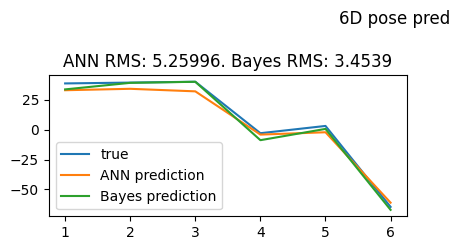


- test run 44.
      True pose:      [35.12569 44.87589 35.93193 -4.67968 4.12437 -58.04096]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 9         | 0.0001353 | -0.1002   | 0.0397    | -1.055    | 36.91     | 41.99     | 33.59     |
| 20        | 0.0001395 | -0.08889  | 0.04115   | -1.032    | 32.98     | 40.96     | 33.67     |
| 21        | 0.0001472 | -0.1133   | 0.04264   | -1.046    | 31.69     | 40.24     | 33.15     |
| 25        | 0.0001504 | -0.1213   | 0.04955   | -1.034    | 30.44     | 40.03     | 33.2      |
| 29        | 0.0001504 | -0.1202   | 0.04173   | -1.03     | 30.25     | 39.89     | 33.1      |
| 31        | 0.0001515 | -0.125    | 0.04776   | -1.035    | 30.34     | 39.92     | 32.88     |
| 33        | 0.0001516 | -0.1233   | 0.04766   | -1.029    | 30.13   

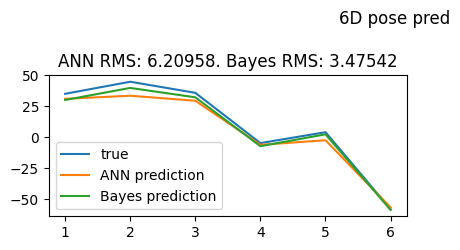


- test run 45.
      True pose:      [40.33404 40.27398 44.47696 -0.72742 -4.16697 -57.03321]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.449e-05 | -0.04007  | -0.0862   | -1.004    | 40.72     | 39.47     | 46.33     |
| 9         | 5.769e-05 | -0.03122  | -0.105    | -1.037    | 42.12     | 37.39     | 42.13     |
| 10        | 6.436e-05 | -0.01343  | -0.1117   | -0.9889   | 36.8      | 41.17     | 46.47     |
| 29        | 6.498e-05 | -0.01475  | -0.1137   | -0.9929   | 35.39     | 42.18     | 46.2      |
| 31        | 6.512e-05 | -0.01582  | -0.1098   | -0.9856   | 35.36     | 41.4      | 46.27     |
| 34        | 6.526e-05 | -0.009493 | -0.106    | -0.9835   | 35.34     | 41.14     | 45.78     |
| 35        | 6.678e-05 | -0.009933 | -0.1128   | -0.9877   | 35.36  

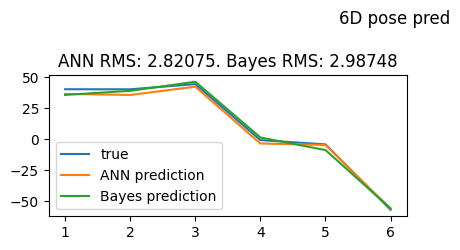


- test run 46.
      True pose:      [42.19750 39.12927 37.10024 3.94372 -0.50722 -64.38599]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 8.482e-05 | 0.04145   | -0.02233  | -1.133    | 42.59     | 38.32     | 38.95     |
| 10        | 8.928e-05 | 0.0681    | -0.04783  | -1.117    | 38.66     | 40.02     | 39.1      |
| 21        | 9.163e-05 | 0.04257   | -0.04166  | -1.133    | 38.41     | 40.32     | 39.17     |
| 24        | 9.708e-05 | 0.0643    | -0.0321   | -1.149    | 37.91     | 40.65     | 38.85     |
| 25        | 9.833e-05 | 0.06512   | -0.03952  | -1.159    | 37.66     | 40.9      | 38.65     |
| 28        | 9.85e-05  | 0.06463   | -0.05022  | -1.159    | 37.22     | 41.0      | 38.43     |
| 29        | 9.982e-05 | 0.07658   | -0.04948  | -1.161    | 37.2    

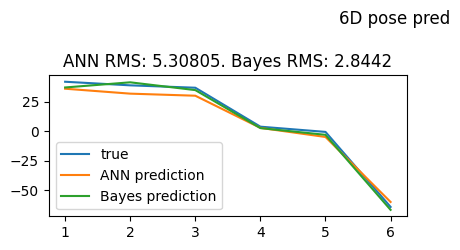


- test run 47.
      True pose:      [42.67519 43.06334 39.76231 0.38882 -3.75792 -56.83034]
1/1 [==============================] - 0s 20ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.806e-05 | -0.02059  | -0.07907  | -1.001    | 43.06     | 42.26     | 41.61     |
| 9         | 6.201e-05 | -0.01173  | -0.09787  | -1.034    | 44.46     | 40.18     | 37.42     |
| 10        | 6.419e-05 | 0.006051  | -0.1046   | -0.9854   | 39.14     | 43.96     | 41.76     |
| 23        | 6.463e-05 | 0.003457  | -0.1028   | -0.9899   | 38.75     | 43.63     | 41.61     |
| 25        | 6.839e-05 | 0.02388   | -0.1019   | -0.9829   | 37.97     | 42.64     | 41.83     |
| 28        | 6.955e-05 | 0.02337   | -0.1073   | -0.9871   | 37.7      | 42.73     | 41.6      |
| 29        | 7.146e-05 | 0.02376   | -0.1087   | -0.9753   | 37.7    

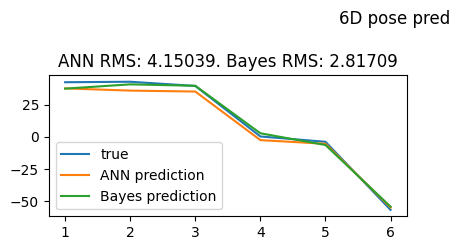


- test run 48.
      True pose:      [41.87485 37.86472 42.88702 4.33443 1.82143 -64.96138]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 8.021e-05 | 0.04827   | 0.01831   | -1.143    | 42.26     | 37.06     | 44.74     |
| 21        | 8.09e-05  | 0.05886   | 0.02433   | -1.157    | 42.66     | 36.29     | 45.14     |
| 25        | 8.095e-05 | 0.04387   | 0.02878   | -1.153    | 42.42     | 36.32     | 44.55     |
| 28        | 8.105e-05 | 0.04515   | 0.0192    | -1.145    | 42.2      | 36.13     | 44.99     |
| 30        | 8.116e-05 | 0.04824   | 0.01388   | -1.152    | 42.77     | 35.49     | 45.22     |
| 31        | 8.309e-05 | 0.05486   | 0.007166  | -1.16     | 42.11     | 35.68     | 44.38     |
| 32        | 8.44e-05  | 0.05096   | 0.01085   | -1.159    | 41.4     

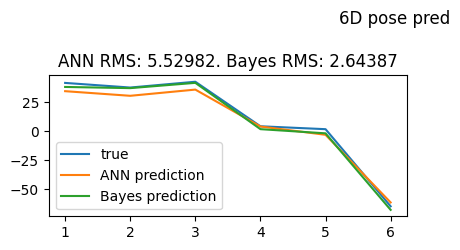


- test run 49.
      True pose:      [44.18035 44.71895 35.00986 0.38570 4.31922 -59.85654]
1/1 [==============================] - 0s 21ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.908e-05 | -0.02065  | 0.06191   | -1.054    | 44.57     | 43.91     | 36.86     |
| 3         | 6.114e-05 | -0.01906  | 0.1084    | -1.086    | 45.89     | 43.89     | 35.6      |
| 9         | 6.455e-05 | -0.01179  | 0.0431    | -1.087    | 45.97     | 41.84     | 32.67     |
| 27        | 6.522e-05 | -0.01872  | 0.03847   | -1.08     | 44.2      | 43.01     | 34.51     |
| 28        | 6.598e-05 | -0.03125  | 0.03243   | -1.073    | 43.92     | 43.01     | 35.1      |
| 33        | 6.665e-05 | -0.02749  | 0.03239   | -1.081    | 43.0      | 42.09     | 34.94     |
| 38        | 6.712e-05 | -0.02813  | 0.03903   | -1.088    | 43.39    

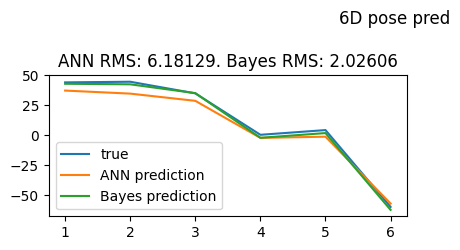


- test run 50.
      True pose:      [44.10677 43.58543 38.46698 -4.89951 4.15577 -56.07065]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 21        | 0.0001757 | -0.1025   | 0.1115    | -0.998    | 41.35     | 39.3      | 35.25     |
| 23        | 0.0001766 | -0.1253   | 0.103     | -0.9763   | 40.59     | 39.37     | 33.91     |
| 24        | 0.0001785 | -0.1042   | 0.09856   | -0.9567   | 39.29     | 38.63     | 35.29     |
| 26        | 0.0001799 | -0.1096   | 0.09179   | -0.9575   | 39.12     | 38.62     | 33.72     |
| 38        | 0.0001819 | -0.1155   | 0.08952   | -0.9645   | 39.68     | 38.65     | 33.78     |
| 39        | 0.0001845 | -0.1168   | 0.08316   | -0.9703   | 40.17     | 38.59     | 33.86     |
| 41        | 0.0001877 | -0.1237   | 0.07706   | -0.9761   | 40.38   

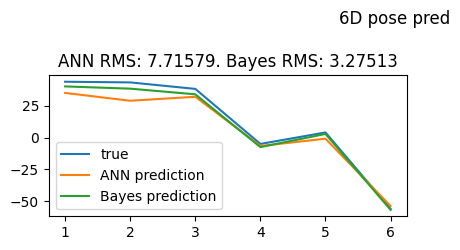


- test run 51.
      True pose:      [35.90072 40.26203 35.57832 0.78417 -0.97587 -60.23395]
1/1 [==============================] - 0s 20ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 4.583e-05 | -0.01369  | -0.03051  | -1.06     | 36.29     | 39.45     | 37.43     |
| 5         | 4.798e-05 | 0.04653   | 0.0174    | -1.087    | 31.29     | 36.96     | 39.36     |
| 6         | 4.811e-05 | -0.02136  | -0.02392  | -1.011    | 36.23     | 42.18     | 33.73     |
| 9         | 5.014e-05 | -0.004834 | -0.04932  | -1.093    | 37.69     | 37.38     | 33.23     |
| 10        | 5.075e-05 | 0.01295   | -0.05601  | -1.045    | 32.37     | 41.16     | 37.58     |
| 13        | 5.202e-05 | -0.01779  | 0.009793  | -1.06     | 32.55     | 44.54     | 34.06     |
| 23        | 5.32e-05  | -0.01682  | -0.01109  | -1.042    | 32.58   

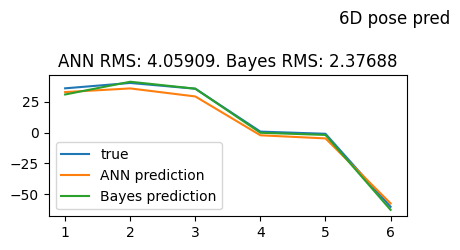


- test run 52.
      True pose:      [40.30131 35.32009 44.69216 4.04201 -4.54344 -57.37029]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 7.14e-05  | 0.04317   | -0.09278  | -1.01     | 40.69     | 34.51     | 46.54     |
| 10        | 7.998e-05 | 0.06981   | -0.1183   | -0.9948   | 36.77     | 36.21     | 46.69     |
| 20        | 8.004e-05 | 0.07671   | -0.1108   | -0.9834   | 37.7      | 33.59     | 44.85     |
| 26        | 8.398e-05 | 0.09146   | -0.1193   | -0.9736   | 37.6      | 33.47     | 44.78     |
| 27        | 8.422e-05 | 0.1074    | -0.1182   | -0.9681   | 37.51     | 33.48     | 44.91     |
| 31        | 8.48e-05  | 0.09642   | -0.1184   | -0.9676   | 37.36     | 33.2      | 45.16     |
| 32        | 8.666e-05 | 0.09763   | -0.1227   | -0.9684   | 37.1    

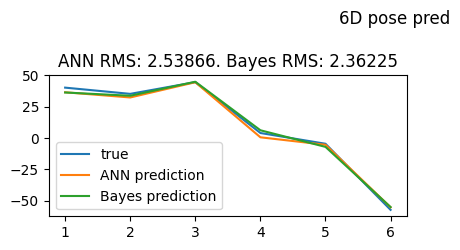


- test run 53.
      True pose:      [35.21490 40.32628 35.69092 0.41152 -4.67408 -56.60757]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.832e-05 | -0.0202   | -0.09506  | -0.997    | 35.6      | 39.52     | 37.54     |
| 9         | 5.887e-05 | -0.01134  | -0.1139   | -1.03     | 37.0      | 37.44     | 33.35     |
| 10        | 6.534e-05 | 0.006447  | -0.1206   | -0.9815   | 31.68     | 41.22     | 37.69     |
| 29        | 6.712e-05 | 0.01971   | -0.1216   | -0.9863   | 30.23     | 42.39     | 36.96     |
| 30        | 6.718e-05 | 0.02965   | -0.1147   | -0.9884   | 30.23     | 42.42     | 36.16     |
| 31        | 6.808e-05 | 0.03205   | -0.1215   | -0.9856   | 30.22     | 42.67     | 36.57     |
| 35        | 6.889e-05 | 0.03655   | -0.1243   | -0.9787   | 30.26   

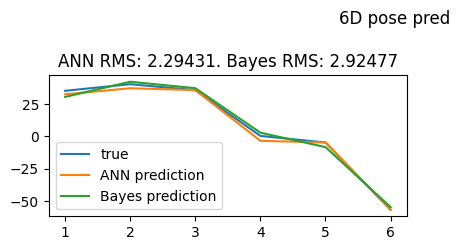


- test run 54.
      True pose:      [37.69512 36.90032 37.32984 -3.70182 2.78391 -60.32168]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 8.757e-05 | -0.09199  | 0.03511   | -1.062    | 38.08     | 36.09     | 39.18     |
| 3         | 8.834e-05 | -0.0904   | 0.08159   | -1.094    | 39.4      | 36.07     | 37.92     |
| 5         | 9.027e-05 | -0.03176  | 0.08302   | -1.089    | 33.09     | 33.6      | 41.11     |
| 9         | 0.0001031 | -0.08313  | 0.0163    | -1.095    | 39.48     | 34.02     | 34.99     |
| 37        | 0.0001032 | -0.08919  | 0.01753   | -1.093    | 39.54     | 33.94     | 34.96     |
| 39        | 0.0001039 | -0.09462  | 0.0121    | -1.095    | 39.26     | 33.8      | 34.46     |
| 41        | 0.0001041 | -0.1016   | 0.006729  | -1.093    | 39.21   

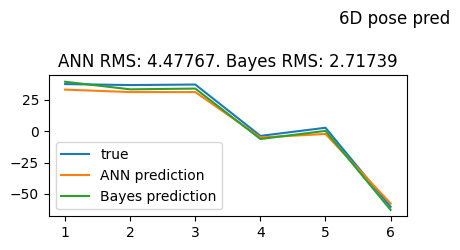


- test run 55.
      True pose:      [39.96101 44.64595 42.91413 -0.88991 -4.47322 -56.71252]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.821e-05 | -0.04291  | -0.09155  | -0.9988   | 40.35     | 43.84     | 44.77     |
| 9         | 6.017e-05 | -0.03405  | -0.1104   | -1.032    | 41.75     | 41.76     | 40.57     |
| 10        | 6.818e-05 | -0.01627  | -0.117    | -0.9834   | 36.43     | 45.54     | 44.91     |
| 28        | 6.953e-05 | -0.02778  | -0.1178   | -0.976    | 35.03     | 43.93     | 43.33     |
| 41        | 6.959e-05 | -0.02892  | -0.1188   | -0.9693   | 35.36     | 43.8      | 43.73     |
| 43        | 7.053e-05 | -0.02801  | -0.1205   | -0.9631   | 35.12     | 43.58     | 44.03     |
| 47        | 7.055e-05 | -0.02662  | -0.1201   | -0.9607   | 34.96  

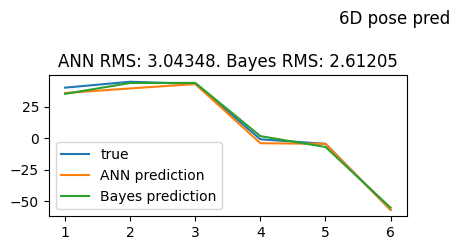


- test run 56.
      True pose:      [35.78907 42.37897 36.28305 4.26413 -3.12096 -63.76345]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 8.298e-05 | 0.04704   | -0.06795  | -1.122    | 36.18     | 41.57     | 38.14     |
| 9         | 8.683e-05 | 0.0559    | -0.08676  | -1.155    | 37.58     | 39.5      | 33.94     |
| 10        | 9.525e-05 | 0.07369   | -0.09345  | -1.106    | 32.26     | 43.27     | 38.28     |
| 20        | 9.914e-05 | 0.06314   | -0.08246  | -1.129    | 33.28     | 42.84     | 38.33     |
| 24        | 0.0001004 | 0.05469   | -0.06238  | -1.148    | 33.16     | 43.88     | 39.26     |
| 26        | 0.0001026 | 0.05869   | -0.07214  | -1.153    | 33.8      | 45.04     | 39.19     |
| 27        | 0.0001047 | 0.05521   | -0.08403  | -1.153    | 33.54   

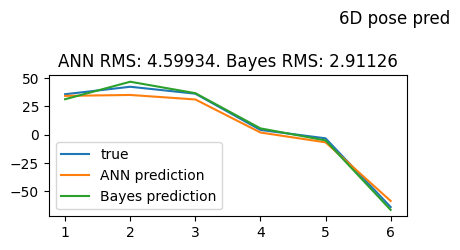


- test run 57.
      True pose:      [35.29202 38.35324 35.44421 2.89216 -4.39768 -55.75905]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 7.002e-05 | 0.0231    | -0.09023  | -0.9822   | 35.68     | 37.55     | 37.3      |
| 6         | 7.136e-05 | 0.01543   | -0.08364  | -0.9332   | 35.62     | 40.27     | 33.6      |
| 10        | 8.027e-05 | 0.04974   | -0.1157   | -0.9667   | 31.76     | 39.25     | 37.44     |
| 20        | 8.362e-05 | 0.05664   | -0.1083   | -0.9553   | 32.69     | 36.62     | 35.6      |
| 21        | 8.371e-05 | 0.08774   | -0.1059   | -0.9668   | 32.5      | 37.51     | 36.23     |
| 27        | 8.734e-05 | 0.07824   | -0.1187   | -0.9568   | 32.48     | 35.86     | 35.05     |
| 28        | 8.858e-05 | 0.08081   | -0.1168   | -0.9491   | 32.2    

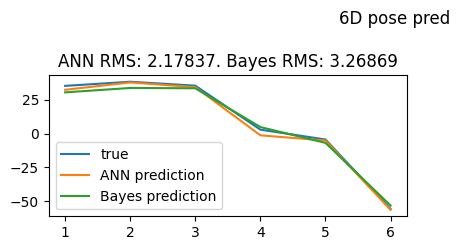


- test run 58.
      True pose:      [36.16865 40.87385 41.91979 1.35843 0.13346 -56.48067]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.964e-05 | -0.00367  | -0.01115  | -0.9948   | 36.56     | 40.07     | 43.77     |
| 6         | 6.032e-05 | -0.01134  | -0.004555 | -0.9458   | 36.5      | 42.79     | 40.07     |
| 9         | 6.291e-05 | 0.005189  | -0.02996  | -1.028    | 37.96     | 37.99     | 39.58     |
| 10        | 6.673e-05 | 0.02297   | -0.03665  | -0.9793   | 32.64     | 41.77     | 43.92     |
| 25        | 6.796e-05 | 0.02099   | -0.03901  | -0.9779   | 32.43     | 42.02     | 43.68     |
| 29        | 6.903e-05 | 0.01295   | -0.03953  | -0.9797   | 31.95     | 42.72     | 43.86     |
| 35        | 6.913e-05 | 0.01308   | -0.03483  | -0.9801   | 31.18    

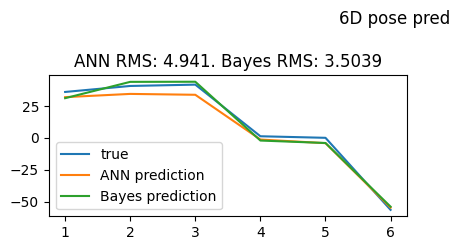


- test run 59.
      True pose:      [40.53416 36.40246 39.88239 0.00915 -4.15773 -59.89610]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 3         | 3.95e-05  | -0.02563  | -0.03957  | -1.087    | 42.24     | 35.58     | 40.47     |
| 9         | 4.212e-05 | -0.01836  | -0.1049   | -1.087    | 42.32     | 33.52     | 37.54     |
| 10        | 4.838e-05 | -0.000575 | -0.1115   | -1.039    | 37.0      | 37.3      | 41.88     |
| 30        | 4.883e-05 | 0.006106  | -0.1107   | -1.036    | 36.84     | 37.04     | 42.11     |
| 39        | 4.892e-05 | 0.0112    | -0.1129   | -1.031    | 37.06     | 37.3      | 41.89     |
| 43        | 4.902e-05 | 0.007197  | -0.115    | -1.026    | 37.05     | 37.29     | 41.83     |
| 44        | 4.923e-05 | 0.01069   | -0.1152   | -1.032    | 37.08   

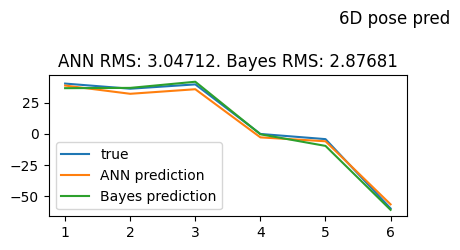


- test run 60.
      True pose:      [35.20125 43.99632 37.52428 1.13334 -3.36911 -59.58725]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 4.006e-05 | -0.007598 | -0.07228  | -1.049    | 35.59     | 43.19     | 39.38     |
| 6         | 4.362e-05 | -0.01527  | -0.06569  | -1.0      | 35.53     | 45.92     | 35.68     |
| 10        | 4.98e-05  | 0.01905   | -0.09778  | -1.034    | 31.67     | 44.89     | 39.52     |
| 22        | 5.046e-05 | 0.04392   | -0.0881   | -1.028    | 31.68     | 44.88     | 39.31     |
| 25        | 5.248e-05 | 0.05443   | -0.09912  | -1.028    | 31.38     | 45.12     | 39.21     |
| 30        | 5.381e-05 | 0.05496   | -0.09928  | -1.028    | 31.25     | 45.14     | 38.21     |
| 31        | 5.43e-05  | 0.06217   | -0.0925   | -1.025    | 31.02   

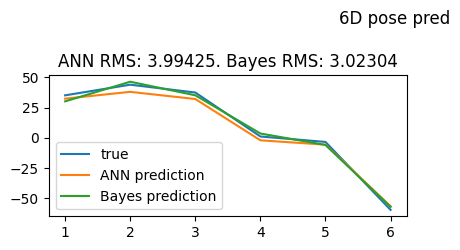


- test run 61.
      True pose:      [38.85301 44.72358 42.28254 -0.37003 0.02119 -60.53865]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 3         | 5.241e-05 | -0.03225  | 0.03337   | -1.098    | 40.56     | 43.9      | 42.87     |
| 5         | 5.279e-05 | 0.02639   | 0.03481   | -1.093    | 34.24     | 41.42     | 46.06     |
| 9         | 5.503e-05 | -0.02498  | -0.03192  | -1.099    | 40.64     | 41.84     | 39.94     |
| 10        | 5.528e-05 | -0.007194 | -0.03861  | -1.05     | 35.32     | 45.62     | 44.28     |
| 25        | 5.584e-05 | -0.01963  | -0.0361   | -1.064    | 34.91     | 47.09     | 45.24     |
| 28        | 5.69e-05  | -0.007927 | -0.04141  | -1.062    | 34.54     | 47.94     | 44.37     |
| 35        | 5.722e-05 | -0.008313 | -0.03929  | -1.064    | 34.5    

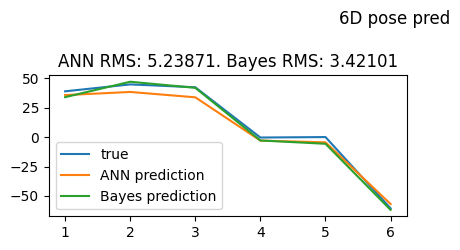


- test run 62.
      True pose:      [36.21710 43.16363 44.84997 -0.54393 -4.99216 -55.93604]
1/1 [==============================] - 0s 21ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.691e-05 | -0.03687  | -0.1006   | -0.9853   | 36.61     | 42.36     | 46.7      |
| 5         | 5.936e-05 | 0.02335   | -0.05269  | -1.012    | 31.61     | 39.86     | 48.63     |
| 10        | 7.082e-05 | -0.01023  | -0.1261   | -0.9698   | 32.68     | 44.06     | 46.85     |
| 20        | 7.149e-05 | 0.01837   | -0.1178   | -0.9412   | 31.97     | 44.6      | 47.2      |
| 21        | 7.266e-05 | 0.02304   | -0.1264   | -0.9361   | 32.74     | 44.96     | 47.1      |
| 22        | 7.424e-05 | 0.03159   | -0.1275   | -0.9386   | 32.28     | 45.12     | 46.45     |
| 27        | 7.48e-05  | 0.03028   | -0.1301   | -0.9509   | 32.75  

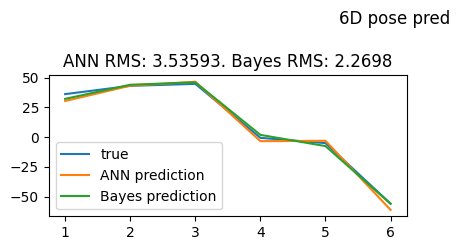


- test run 63.
      True pose:      [44.31627 38.33279 37.84691 0.55070 -1.77273 -60.85204]
1/1 [==============================] - 0s 20ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 5         | 4.579e-05 | 0.04246   | 0.003496  | -1.098    | 39.71     | 35.03     | 41.63     |
| 8         | 4.662e-05 | -0.009548 | -0.005696 | -1.097    | 43.8      | 42.42     | 35.78     |
| 9         | 4.986e-05 | -0.008909 | -0.06323  | -1.104    | 46.1      | 35.45     | 35.5      |
| 13        | 5.017e-05 | -0.02187  | -0.004115 | -1.071    | 40.97     | 42.61     | 36.32     |
| 20        | 5.397e-05 | -0.03241  | -0.03614  | -1.037    | 41.39     | 43.3      | 36.06     |
| 22        | 5.401e-05 | -0.009061 | -0.04772  | -1.026    | 41.77     | 43.33     | 36.53     |
| 24        | 5.556e-05 | -0.00342  | -0.04767  | -1.038    | 39.7    

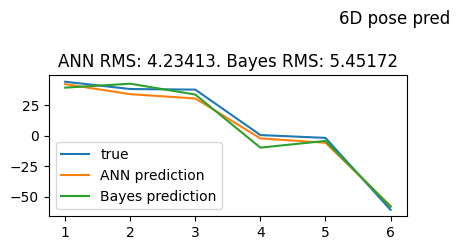


- test run 64.
      True pose:      [37.76015 36.37676 37.50410 -0.51867 -1.04489 -57.43622]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.135e-05 | -0.03643  | -0.03171  | -1.011    | 38.15     | 35.57     | 39.36     |
| 5         | 5.285e-05 | 0.02379   | 0.0162    | -1.039    | 33.15     | 33.08     | 41.29     |
| 9         | 5.513e-05 | -0.02757  | -0.05052  | -1.044    | 39.55     | 33.49     | 35.16     |
| 10        | 5.963e-05 | -0.009788 | -0.05721  | -0.996    | 34.23     | 37.27     | 39.5      |
| 21        | 6.099e-05 | -0.03491  | -0.05585  | -0.9881   | 34.41     | 37.52     | 38.7      |
| 24        | 6.513e-05 | -0.05104  | -0.05297  | -0.9836   | 33.05     | 37.11     | 38.32     |
| 26        | 6.543e-05 | -0.05016  | -0.05025  | -0.9867   | 32.77  

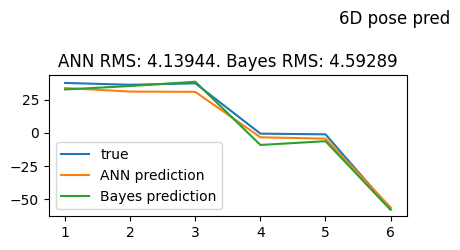


- test run 65.
      True pose:      [38.99508 40.46195 36.87702 -3.76587 -3.94747 -64.46447]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 7.577e-05 | -0.09311  | -0.08237  | -1.134    | 39.38     | 39.65     | 38.73     |
| 10        | 9.409e-05 | -0.06646  | -0.1079   | -1.119    | 35.46     | 41.36     | 38.87     |
| 19        | 9.575e-05 | -0.08283  | -0.1088   | -1.164    | 36.4      | 40.85     | 39.32     |
| 23        | 9.82e-05  | -0.09475  | -0.1019   | -1.15     | 35.8      | 40.12     | 38.93     |
| 24        | 0.0001006 | -0.077    | -0.1051   | -1.15     | 34.6      | 39.52     | 37.78     |
| 25        | 0.0001006 | -0.09089  | -0.09702  | -1.162    | 34.05     | 39.81     | 38.33     |
| 27        | 0.0001017 | -0.08672  | -0.1044   | -1.161    | 34.06  

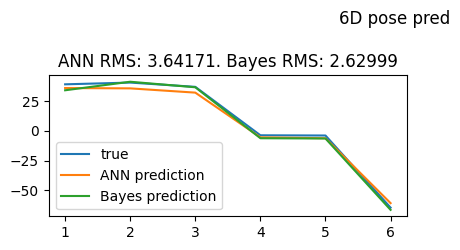


- test run 66.
      True pose:      [42.77606 39.86395 42.21343 2.91643 1.59554 -60.97536]
1/1 [==============================] - 0s 20ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.471e-05 | 0.02352   | 0.01437   | -1.073    | 43.16     | 39.06     | 44.07     |
| 6         | 5.481e-05 | 0.01585   | 0.02096   | -1.024    | 43.11     | 41.78     | 40.37     |
| 10        | 5.594e-05 | 0.05017   | -0.01113  | -1.058    | 39.24     | 40.76     | 44.21     |
| 25        | 5.627e-05 | 0.03558   | 0.00117   | -1.054    | 39.58     | 40.74     | 43.97     |
| 27        | 5.677e-05 | 0.03446   | 0.01505   | -1.061    | 39.31     | 40.65     | 43.98     |
| 29        | 5.701e-05 | 0.03532   | 0.02224   | -1.073    | 39.27     | 40.51     | 43.41     |
| 32        | 5.751e-05 | 0.02633   | 0.02101   | -1.077    | 39.19    

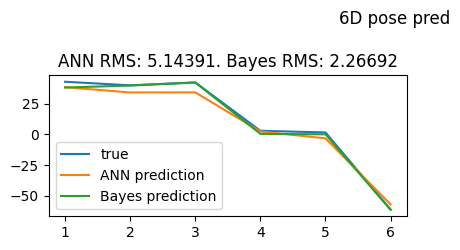


- test run 67.
      True pose:      [38.28308 42.20525 40.87454 -3.68781 2.94948 -59.51624]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 8.714e-05 | -0.09174  | 0.038     | -1.048    | 38.67     | 41.4      | 42.73     |
| 5         | 9.147e-05 | -0.03152  | 0.08591   | -1.075    | 33.67     | 38.9      | 44.66     |
| 9         | 0.0001026 | -0.08288  | 0.01919   | -1.081    | 40.07     | 39.32     | 38.53     |
| 27        | 0.000104  | -0.08685  | 0.02079   | -1.079    | 39.83     | 39.41     | 40.41     |
| 29        | 0.0001043 | -0.09284  | 0.02363   | -1.08     | 39.69     | 39.38     | 40.74     |
| 31        | 0.0001056 | -0.0979   | 0.02302   | -1.082    | 39.6      | 39.06     | 40.59     |
| 36        | 0.0001068 | -0.1018   | 0.01976   | -1.081    | 39.62   

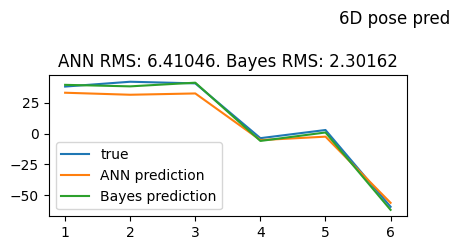


- test run 68.
      True pose:      [38.03586 43.15915 40.44694 1.35838 3.19583 -61.90799]
1/1 [==============================] - 0s 20ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.78e-05  | -0.003671 | 0.0423    | -1.09     | 38.42     | 42.35     | 42.3      |
| 3         | 5.808e-05 | -0.002083 | 0.08877   | -1.122    | 39.74     | 42.33     | 41.03     |
| 9         | 6.068e-05 | 0.005188  | 0.02349   | -1.122    | 39.82     | 40.28     | 38.1      |
| 25        | 6.188e-05 | -0.006933 | 0.02133   | -1.121    | 38.8      | 41.75     | 39.06     |
| 30        | 6.197e-05 | -0.000938 | 0.0164    | -1.121    | 39.03     | 42.45     | 40.31     |
| 34        | 6.228e-05 | -0.003925 | 0.02163   | -1.122    | 38.54     | 42.47     | 40.41     |
| 40        | 6.261e-05 | -0.006758 | 0.01884   | -1.124    | 38.34    

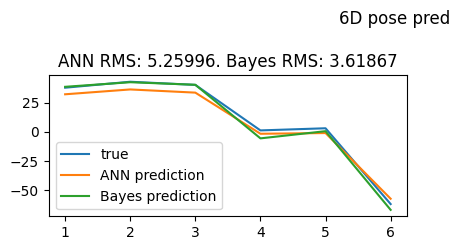


- test run 69.
      True pose:      [37.86177 39.02344 35.39978 -2.86252 -0.41530 -64.04977]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 9.126e-05 | -0.07734  | -0.02073  | -1.127    | 38.25     | 38.22     | 37.25     |
| 10        | 9.142e-05 | -0.0507   | -0.04622  | -1.111    | 34.33     | 39.92     | 37.4      |
| 19        | 9.323e-05 | -0.08792  | 0.02844   | -1.159    | 36.14     | 38.89     | 37.43     |
| 20        | 9.725e-05 | -0.08547  | -0.00185  | -1.147    | 36.92     | 38.33     | 38.37     |
| 22        | 0.000102  | -0.09153  | -0.01588  | -1.154    | 35.73     | 38.44     | 39.25     |
| 28        | 0.000102  | -0.07879  | -0.01898  | -1.147    | 34.09     | 39.58     | 40.26     |
| 29        | 0.0001035 | -0.0684   | -0.01742  | -1.156    | 32.9   

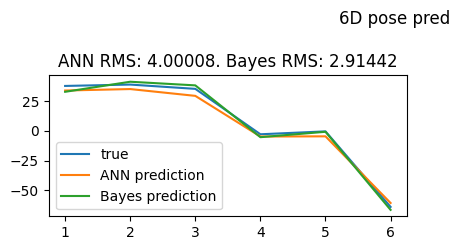


- test run 70.
      True pose:      [40.25374 40.88333 43.60625 -0.16579 -2.63850 -62.98852]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 6.221e-05 | -0.03027  | -0.05953  | -1.108    | 40.64     | 40.08     | 45.46     |
| 9         | 7.055e-05 | -0.02141  | -0.07834  | -1.141    | 42.04     | 38.0      | 41.26     |
| 25        | 7.477e-05 | -0.03353  | -0.0805   | -1.14     | 41.01     | 39.47     | 42.22     |
| 28        | 7.612e-05 | -0.02199  | -0.08764  | -1.133    | 40.2      | 40.3      | 41.35     |
| 30        | 7.776e-05 | -0.01627  | -0.08672  | -1.138    | 40.42     | 40.98     | 42.56     |
| 35        | 7.824e-05 | -0.01144  | -0.08958  | -1.142    | 40.89     | 40.38     | 42.94     |
| 36        | 7.898e-05 | -0.01863  | -0.08832  | -1.142    | 40.23  

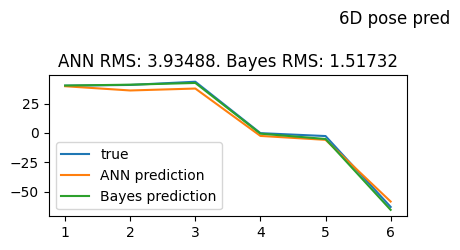


- test run 71.
      True pose:      [35.14982 41.68092 37.00588 2.47576 -1.53439 -58.54718]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 4.796e-05 | 0.01583   | -0.04026  | -1.031    | 35.54     | 40.87     | 38.86     |
| 6         | 5.231e-05 | 0.008159  | -0.03366  | -0.9819   | 35.48     | 43.6      | 35.16     |
| 10        | 5.402e-05 | 0.04247   | -0.06576  | -1.015    | 31.62     | 42.57     | 39.0      |
| 24        | 5.428e-05 | 0.06007   | -0.0515   | -1.008    | 31.12     | 42.6      | 38.91     |
| 28        | 5.611e-05 | 0.04698   | -0.05772  | -0.9982   | 30.78     | 41.84     | 39.24     |
| 29        | 5.655e-05 | 0.04575   | -0.05471  | -1.006    | 30.28     | 41.44     | 39.02     |
| 32        | 5.769e-05 | 0.04613   | -0.06133  | -1.012    | 30.16   

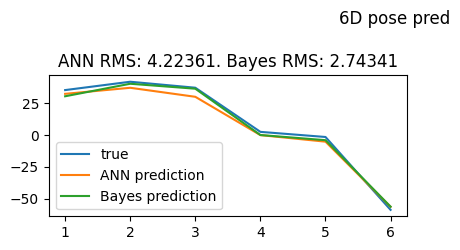


- test run 72.
      True pose:      [42.74154 35.10342 41.42902 4.75575 -2.88070 -57.02767]
1/1 [==============================] - 0s 20ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 6.901e-05 | 0.05562   | -0.06376  | -1.004    | 43.13     | 34.3      | 43.28     |
| 10        | 7.843e-05 | 0.08227   | -0.08925  | -0.9889   | 39.21     | 36.0      | 43.43     |
| 25        | 7.887e-05 | 0.09333   | -0.09223  | -0.9728   | 39.49     | 36.43     | 42.72     |
| 26        | 8.02e-05  | 0.07724   | -0.08871  | -0.9747   | 38.51     | 36.43     | 42.7      |
| 29        | 8.31e-05  | 0.08804   | -0.08504  | -0.9727   | 37.75     | 36.84     | 41.62     |
| 31        | 8.486e-05 | 0.09254   | -0.09265  | -0.9654   | 37.75     | 35.96     | 41.77     |
| 32        | 8.552e-05 | 0.08514   | -0.08994  | -0.9676   | 37.74   

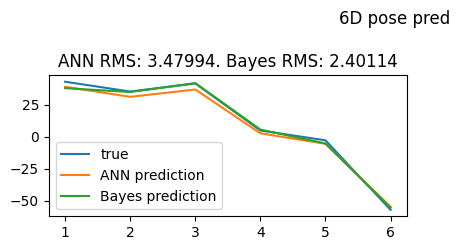


- test run 73.
      True pose:      [36.65486 43.61342 36.00990 0.65414 -2.59296 -63.16195]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 6.157e-05 | -0.01596  | -0.05873  | -1.111    | 37.04     | 42.81     | 37.86     |
| 9         | 6.54e-05  | -0.007103 | -0.07754  | -1.144    | 38.44     | 40.73     | 33.67     |
| 10        | 6.583e-05 | 0.01068   | -0.08423  | -1.096    | 33.12     | 44.51     | 38.01     |
| 13        | 6.635e-05 | -0.02006  | -0.01843  | -1.111    | 33.31     | 47.89     | 34.49     |
| 21        | 6.661e-05 | 0.006475  | -0.04717  | -1.089    | 33.68     | 48.16     | 36.11     |
| 23        | 6.956e-05 | 0.006668  | -0.06437  | -1.089    | 31.94     | 48.07     | 35.73     |
| 25        | 6.989e-05 | -0.01076  | -0.05406  | -1.09     | 31.66   

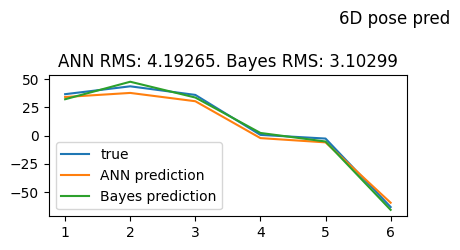


- test run 74.
      True pose:      [41.47251 39.72957 44.74623 4.48896 -0.95375 -59.79408]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.253e-05 | 0.05097   | -0.03012  | -1.053    | 41.86     | 38.92     | 46.6      |
| 6         | 5.322e-05 | 0.0433    | -0.02353  | -1.004    | 41.8      | 41.65     | 42.9      |
| 10        | 6.6e-05   | 0.07761   | -0.05562  | -1.037    | 37.94     | 40.62     | 46.74     |
| 23        | 6.675e-05 | 0.05747   | -0.03192  | -1.04     | 37.74     | 41.63     | 46.25     |
| 24        | 6.851e-05 | 0.06532   | -0.04643  | -1.06     | 36.81     | 41.07     | 46.09     |
| 26        | 7.196e-05 | 0.05286   | -0.03475  | -1.043    | 36.48     | 42.14     | 45.02     |
| 27        | 7.321e-05 | 0.05376   | -0.04373  | -1.03     | 36.49   

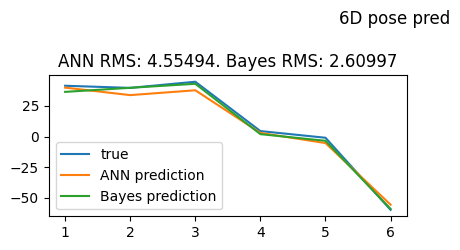


- test run 75.
      True pose:      [37.19600 42.96677 41.30688 -2.17922 4.68365 -60.73649]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 7.391e-05 | -0.06541  | 0.06827   | -1.069    | 37.58     | 42.16     | 43.16     |
| 3         | 7.54e-05  | -0.06383  | 0.1147    | -1.101    | 38.9      | 42.14     | 41.89     |
| 5         | 7.727e-05 | -0.005189 | 0.1162    | -1.096    | 32.59     | 39.67     | 45.09     |
| 9         | 8.783e-05 | -0.05655  | 0.04946   | -1.102    | 38.98     | 40.08     | 38.96     |
| 33        | 8.83e-05  | -0.06478  | 0.05361   | -1.103    | 39.04     | 40.54     | 39.48     |
| 35        | 8.961e-05 | -0.05996  | 0.04644   | -1.103    | 39.54     | 39.9      | 39.88     |
| 36        | 8.995e-05 | -0.06139  | 0.04307   | -1.103    | 39.72   

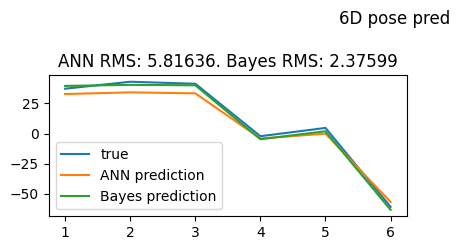


- test run 76.
      True pose:      [36.95170 36.91843 43.50007 -2.90384 4.04356 -56.85417]
1/1 [==============================] - 0s 20ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 0.0001066 | -0.07806  | 0.0571    | -1.001    | 37.34     | 36.11     | 45.35     |
| 5         | 0.0001109 | -0.01784  | 0.105     | -1.029    | 32.34     | 33.62     | 47.28     |
| 9         | 0.0001179 | -0.0692   | 0.03829   | -1.034    | 38.74     | 34.03     | 41.16     |
| 22        | 0.0001196 | -0.09041  | 0.02938   | -1.022    | 39.6      | 34.34     | 41.63     |
| 27        | 0.0001202 | -0.07854  | 0.02775   | -1.02     | 39.34     | 33.99     | 41.5      |
| 28        | 0.0001241 | -0.08183  | 0.03976   | -1.024    | 37.72     | 33.45     | 43.12     |
| 29        | 0.0001269 | -0.08449  | 0.03432   | -1.024    | 37.55   

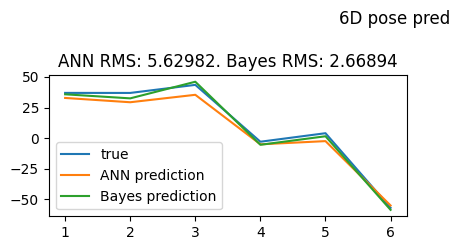


- test run 77.
      True pose:      [44.78388 38.70380 36.74085 -3.31463 4.91772 -57.79184]
1/1 [==============================] - 0s 21ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 9         | 0.0001039 | -0.07637  | 0.05354   | -1.051    | 46.57     | 35.82     | 34.4      |
| 21        | 0.0001104 | -0.09689  | 0.06028   | -1.045    | 43.06     | 34.88     | 35.3      |
| 28        | 0.0001135 | -0.0992   | 0.05188   | -1.036    | 41.52     | 33.8      | 33.74     |
| 29        | 0.000114  | -0.09076  | 0.04726   | -1.026    | 40.16     | 33.83     | 33.08     |
| 34        | 0.0001148 | -0.09728  | 0.05189   | -1.031    | 39.79     | 34.61     | 32.25     |
| 36        | 0.000115  | -0.1007   | 0.05484   | -1.026    | 39.79     | 35.22     | 32.83     |
| 39        | 0.0001157 | -0.1006   | 0.05034   | -1.021    | 39.79   

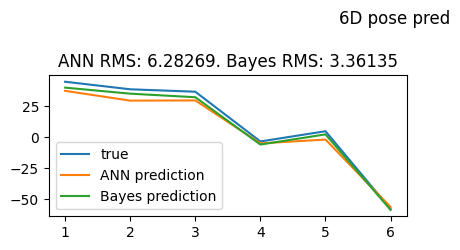


- test run 78.
      True pose:      [42.15833 44.37762 39.81432 -1.13890 0.02581 -59.07908]
1/1 [==============================] - 0s 20ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 4.957e-05 | -0.04726  | -0.01303  | -1.04     | 42.55     | 43.57     | 41.67     |
| 3         | 5.028e-05 | -0.04567  | 0.03345   | -1.072    | 43.86     | 43.55     | 40.4      |
| 5         | 5.26e-05  | 0.01297   | 0.03489   | -1.067    | 37.55     | 41.08     | 43.6      |
| 9         | 5.51e-05  | -0.0384   | -0.03184  | -1.073    | 43.95     | 41.49     | 37.47     |
| 10        | 5.587e-05 | -0.02061  | -0.03853  | -1.025    | 38.63     | 45.27     | 41.81     |
| 21        | 5.73e-05  | 0.01033   | -0.0389   | -1.053    | 38.16     | 45.22     | 41.63     |
| 23        | 5.737e-05 | 0.01425   | -0.04157  | -1.052    | 38.12   

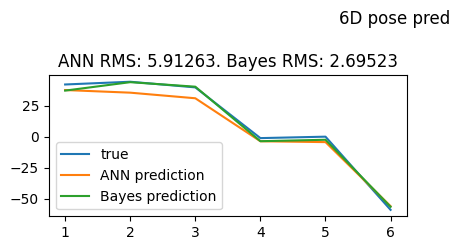


- test run 79.
      True pose:      [37.89288 43.58051 44.85838 -4.16384 0.70238 -63.98883]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 0.0001136 | -0.1001   | -0.001219 | -1.126    | 38.28     | 42.77     | 46.71     |
| 10        | 0.0001161 | -0.07341  | -0.02672  | -1.11     | 34.36     | 44.47     | 46.86     |
| 21        | 0.0001212 | -0.06772  | -0.02874  | -1.123    | 34.93     | 44.91     | 46.81     |
| 23        | 0.0001291 | -0.07108  | -0.01629  | -1.143    | 34.86     | 45.01     | 46.15     |
| 26        | 0.0001313 | -0.07373  | -0.02015  | -1.156    | 34.87     | 45.52     | 45.99     |
| 32        | 0.0001325 | -0.07683  | -0.01576  | -1.159    | 34.18     | 46.22     | 45.87     |
| 33        | 0.0001329 | -0.08329  | -0.01143  | -1.155    | 33.24   

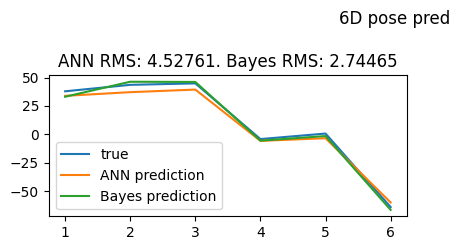


- test run 80.
      True pose:      [43.12707 35.52059 39.84458 -3.80192 4.48607 -55.24735]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 9         | 0.0001607 | -0.08488  | 0.04601   | -1.006    | 44.92     | 32.64     | 37.5      |
| 20        | 0.0001673 | -0.08131  | 0.05509   | -1.0      | 41.08     | 31.54     | 38.48     |
| 21        | 0.0001715 | -0.0942   | 0.06568   | -0.9941   | 39.82     | 31.43     | 39.67     |
| 22        | 0.0001741 | -0.08774  | 0.04378   | -0.9811   | 39.46     | 30.62     | 38.5      |
| 23        | 0.0001755 | -0.1017   | 0.03881   | -1.004    | 38.46     | 31.87     | 38.17     |
| 27        | 0.0001766 | -0.08994  | 0.04461   | -1.001    | 38.14     | 33.08     | 36.74     |
| 28        | 0.0001786 | -0.09555  | 0.03851   | -0.9898   | 38.13   

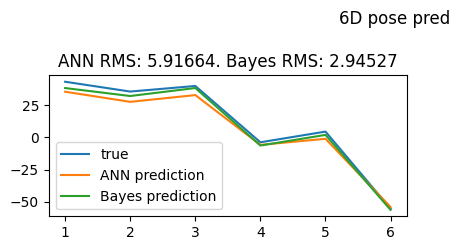


- test run 81.
      True pose:      [39.77768 37.72714 38.29361 2.85528 4.67285 -59.08578]
1/1 [==============================] - 0s 20ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 3         | 5.376e-05 | 0.02404   | 0.1146    | -1.072    | 41.48     | 36.9      | 38.88     |
| 20        | 5.435e-05 | 0.05113   | 0.1247    | -1.07     | 41.56     | 36.43     | 39.31     |
| 26        | 5.508e-05 | 0.04436   | 0.1201    | -1.071    | 41.84     | 36.51     | 40.35     |
| 31        | 5.602e-05 | 0.04143   | 0.1198    | -1.075    | 41.45     | 36.43     | 41.55     |
| 38        | 5.614e-05 | 0.0357    | 0.1193    | -1.074    | 40.91     | 35.84     | 41.09     |
| 44        | 5.621e-05 | 0.03552   | 0.1216    | -1.074    | 41.02     | 35.55     | 41.08     |
| 45        | 5.628e-05 | 0.03077   | 0.1228    | -1.074    | 41.28    

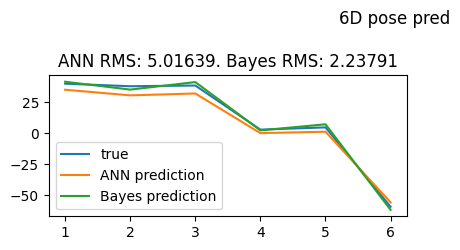


- test run 82.
      True pose:      [42.95152 40.92685 38.42605 -0.93925 0.30788 -58.79161]
1/1 [==============================] - 0s 20ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.057e-05 | -0.04377  | -0.008104 | -1.035    | 43.34     | 40.12     | 40.28     |
| 5         | 5.076e-05 | 0.01645   | 0.03981   | -1.062    | 38.34     | 37.63     | 42.21     |
| 9         | 5.552e-05 | -0.03491  | -0.02691  | -1.068    | 44.74     | 38.04     | 36.08     |
| 10        | 5.653e-05 | -0.01713  | -0.0336   | -1.02     | 39.42     | 41.82     | 40.42     |
| 26        | 5.843e-05 | -0.005572 | -0.03581  | -1.026    | 38.46     | 42.03     | 40.32     |
| 27        | 5.853e-05 | 0.006994  | -0.03613  | -1.024    | 37.99     | 42.29     | 39.74     |
| 35        | 5.869e-05 | -0.000186 | -0.03722  | -1.026    | 38.29   

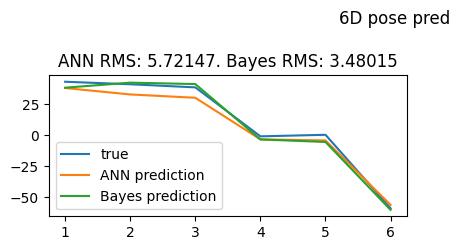


- test run 83.
      True pose:      [44.18258 38.52679 36.69900 -1.46768 4.48272 -58.74326]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 7.151e-05 | -0.05299  | 0.06476   | -1.034    | 44.57     | 37.72     | 38.55     |
| 3         | 7.271e-05 | -0.05141  | 0.1112    | -1.067    | 45.89     | 37.7      | 37.29     |
| 9         | 7.941e-05 | -0.04414  | 0.04595   | -1.067    | 45.97     | 35.64     | 34.35     |
| 22        | 7.953e-05 | -0.06881  | 0.06653   | -1.056    | 44.72     | 35.22     | 35.12     |
| 33        | 8.014e-05 | -0.06308  | 0.0635    | -1.057    | 44.43     | 34.24     | 35.51     |
| 36        | 8.072e-05 | -0.06343  | 0.05628   | -1.054    | 44.16     | 33.57     | 35.58     |
| 37        | 8.138e-05 | -0.06286  | 0.04906   | -1.059    | 44.57   

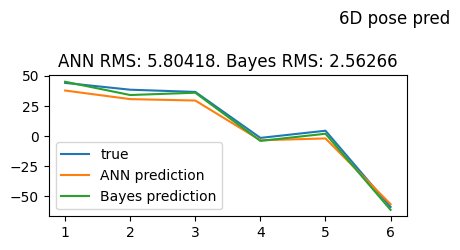


- test run 84.
      True pose:      [36.22761 38.60417 37.60381 -1.70411 -0.66896 -60.93736]
1/1 [==============================] - 0s 21ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 28        | 6.619e-05 | -0.04906  | 0.007208  | -1.1      | 35.31     | 34.66     | 35.16     |
| 29        | 6.737e-05 | -0.05748  | 0.01282   | -1.105    | 36.13     | 34.66     | 35.64     |
| 35        | 6.745e-05 | -0.05736  | 0.008643  | -1.102    | 35.86     | 35.31     | 36.4      |
| 37        | 6.789e-05 | -0.06083  | 0.003116  | -1.105    | 35.58     | 35.27     | 36.28     |
| 42        | 6.82e-05  | -0.06408  | 0.0001665 | -1.106    | 35.62     | 35.49     | 36.5      |
| 46        | 6.821e-05 | -0.05826  | 0.004303  | -1.106    | 35.85     | 35.72     | 36.33     |
| 48        | 6.826e-05 | -0.05786  | 0.01055   | -1.106    | 36.01  

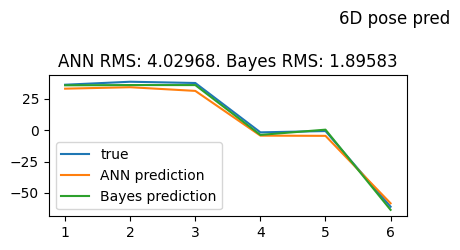


- test run 85.
      True pose:      [37.71796 35.01721 43.51826 3.91066 -0.45369 -56.34541]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 6.532e-05 | 0.04087   | -0.0214   | -0.9924   | 38.11     | 34.21     | 45.37     |
| 6         | 6.796e-05 | 0.0332    | -0.0148   | -0.9435   | 38.05     | 36.94     | 41.67     |
| 10        | 7.386e-05 | 0.06752   | -0.04689  | -0.9769   | 34.19     | 35.91     | 45.52     |
| 28        | 7.49e-05  | 0.06271   | -0.04915  | -0.9634   | 34.22     | 36.21     | 45.72     |
| 30        | 7.523e-05 | 0.05726   | -0.05099  | -0.9714   | 34.26     | 36.19     | 45.81     |
| 43        | 7.568e-05 | 0.05035   | -0.04792  | -0.9689   | 34.04     | 36.42     | 45.87     |
| 45        | 7.639e-05 | 0.05039   | -0.05092  | -0.9664   | 33.82   

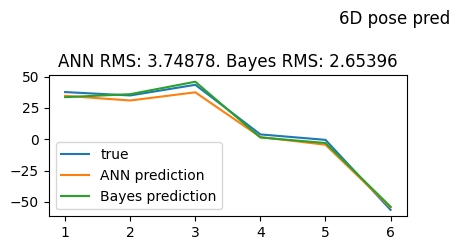


- test run 86.
      True pose:      [36.13803 35.18064 41.23004 -1.62969 -2.10299 -56.59664]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 6.273e-05 | -0.05582  | -0.05018  | -0.9968   | 36.53     | 34.37     | 43.08     |
| 5         | 6.537e-05 | 0.004403  | -0.002268 | -1.024    | 31.53     | 31.88     | 45.01     |
| 9         | 6.925e-05 | -0.04696  | -0.06899  | -1.03     | 37.93     | 32.3      | 38.89     |
| 10        | 7.489e-05 | -0.02918  | -0.07568  | -0.9813   | 32.61     | 36.07     | 43.23     |
| 26        | 7.514e-05 | -0.01808  | -0.0714   | -0.9697   | 32.29     | 34.93     | 42.11     |
| 29        | 7.655e-05 | -0.023    | -0.06378  | -0.9811   | 31.16     | 33.96     | 41.78     |
| 30        | 7.901e-05 | -0.0345   | -0.07378  | -0.9746   | 32.0   

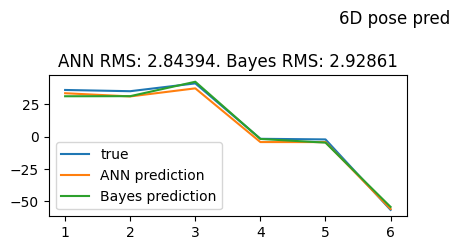


- test run 87.
      True pose:      [36.42175 35.36068 36.49948 -1.23303 2.24783 -62.29623]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 6.892e-05 | -0.0489   | 0.02575   | -1.096    | 36.81     | 34.55     | 38.35     |
| 3         | 7.003e-05 | -0.04731  | 0.07223   | -1.129    | 38.13     | 34.53     | 37.09     |
| 9         | 7.388e-05 | -0.04004  | 0.006946  | -1.129    | 38.21     | 32.48     | 34.15     |
| 23        | 7.705e-05 | -0.06504  | 0.02501   | -1.129    | 36.89     | 34.82     | 36.94     |
| 37        | 7.754e-05 | -0.06355  | 0.02192   | -1.13     | 36.27     | 34.2      | 36.4      |
| 41        | 7.76e-05  | -0.06184  | 0.01628   | -1.131    | 36.43     | 34.44     | 36.36     |
| 42        | 7.782e-05 | -0.06415  | 0.009997  | -1.13     | 36.51   

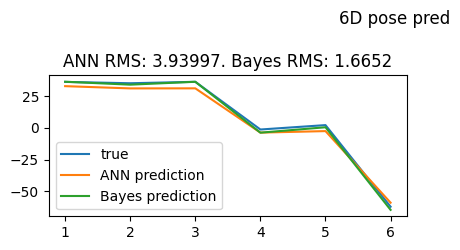


- test run 88.
      True pose:      [40.08415 44.48836 41.06015 4.02876 -1.77725 -63.47587]
1/1 [==============================] - 0s 20ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 7.98e-05  | 0.04294   | -0.0445   | -1.117    | 40.47     | 43.68     | 42.91     |
| 9         | 8.573e-05 | 0.0518    | -0.0633   | -1.15     | 41.87     | 41.6      | 38.72     |
| 10        | 8.968e-05 | 0.06958   | -0.07     | -1.101    | 36.55     | 45.38     | 43.06     |
| 26        | 9.064e-05 | 0.07828   | -0.05512  | -1.103    | 36.77     | 45.54     | 42.28     |
| 27        | 9.485e-05 | 0.07775   | -0.06866  | -1.11     | 36.82     | 45.37     | 40.72     |
| 28        | 9.647e-05 | 0.06624   | -0.0603   | -1.122    | 36.55     | 44.56     | 40.15     |
| 29        | 0.0001002 | 0.06253   | -0.06335  | -1.134    | 36.31   

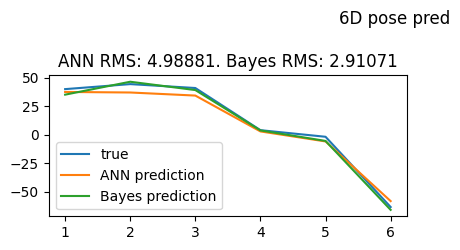


- test run 89.
      True pose:      [44.44515 41.50789 39.65060 4.46741 -4.47606 -57.85287]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 6.666e-05 | 0.05059   | -0.0916   | -1.019    | 44.83     | 40.7      | 41.5      |
| 9         | 6.842e-05 | 0.05945   | -0.1104   | -1.052    | 46.23     | 38.62     | 37.31     |
| 10        | 7.42e-05  | 0.07724   | -0.1171   | -1.003    | 40.91     | 42.4      | 41.65     |
| 24        | 7.555e-05 | 0.09706   | -0.1121   | -1.017    | 40.76     | 42.72     | 41.33     |
| 25        | 7.577e-05 | 0.09566   | -0.1115   | -1.012    | 40.7      | 42.65     | 41.48     |
| 30        | 7.925e-05 | 0.1002    | -0.1214   | -1.0      | 40.16     | 43.8      | 40.13     |
| 32        | 7.929e-05 | 0.108     | -0.1197   | -0.9986   | 40.26   

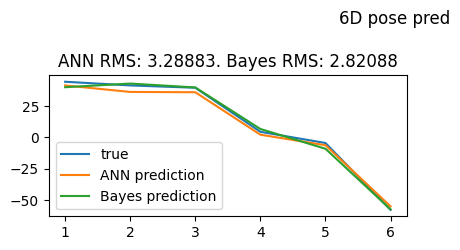


- test run 90.
      True pose:      [43.20559 36.46836 43.30606 1.30672 -4.72177 -58.46642]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 4.899e-05 | -0.004572 | -0.09589  | -1.029    | 43.59     | 35.66     | 45.16     |
| 3         | 4.946e-05 | -0.002985 | -0.04941  | -1.062    | 44.91     | 35.64     | 43.89     |
| 9         | 5.217e-05 | 0.004286  | -0.1147   | -1.062    | 44.99     | 33.58     | 40.96     |
| 10        | 5.899e-05 | 0.02207   | -0.1214   | -1.014    | 39.67     | 37.36     | 45.3      |
| 25        | 6.006e-05 | 0.04139   | -0.119    | -1.034    | 39.52     | 37.52     | 45.59     |
| 30        | 6.062e-05 | 0.05147   | -0.1151   | -1.027    | 39.4      | 37.55     | 45.55     |
| 31        | 6.126e-05 | 0.05365   | -0.124    | -1.032    | 39.46   

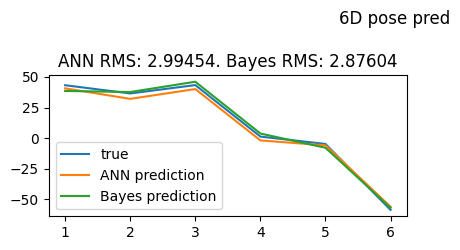


- test run 91.
      True pose:      [39.55532 40.48343 41.17612 4.27342 -1.12145 -62.68155]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 7.433e-05 | 0.04721   | -0.03305  | -1.103    | 39.94     | 39.68     | 43.03     |
| 9         | 7.834e-05 | 0.05607   | -0.05186  | -1.136    | 41.34     | 37.6      | 38.83     |
| 10        | 8.194e-05 | 0.07385   | -0.05855  | -1.088    | 36.02     | 41.38     | 43.17     |
| 22        | 8.573e-05 | 0.08728   | -0.05395  | -1.115    | 36.88     | 40.3      | 42.64     |
| 23        | 8.756e-05 | 0.08759   | -0.05668  | -1.12     | 37.23     | 41.2      | 41.88     |
| 25        | 8.785e-05 | 0.09965   | -0.05564  | -1.119    | 37.46     | 42.5      | 41.89     |
| 26        | 8.899e-05 | 0.09054   | -0.04553  | -1.131    | 37.08   

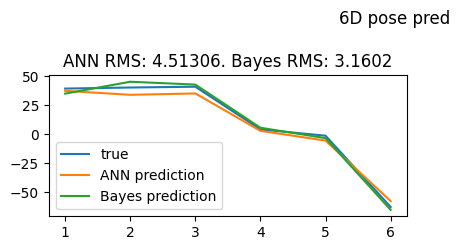


- test run 92.
      True pose:      [41.38561 41.58853 40.37355 -4.40793 -4.94480 -56.63109]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 7.496e-05 | -0.1043   | -0.09978  | -0.9974   | 41.77     | 40.78     | 42.23     |
| 5         | 8.369e-05 | -0.04409  | -0.05187  | -1.025    | 36.78     | 38.29     | 44.15     |
| 9         | 8.512e-05 | -0.09545  | -0.1186   | -1.03     | 43.17     | 38.7      | 38.03     |
| 10        | 8.728e-05 | -0.07767  | -0.1253   | -0.9819   | 37.85     | 42.48     | 42.37     |
| 20        | 8.799e-05 | -0.1068   | -0.1272   | -0.9805   | 38.0      | 40.77     | 43.12     |
| 21        | 9.23e-05  | -0.08563  | -0.1124   | -0.9801   | 40.69     | 38.16     | 43.67     |
| 22        | 9.89e-05  | -0.07147  | -0.1246   | -0.9822   | 39.29  

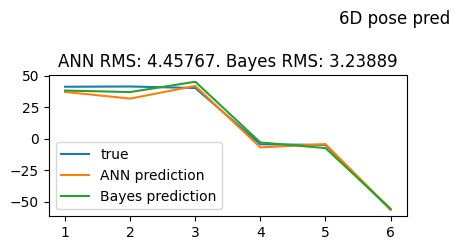


- test run 93.
      True pose:      [40.21946 39.73424 37.04148 1.76253 0.65745 -56.60731]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.813e-05 | 0.003383  | -0.002003 | -0.997    | 40.61     | 38.93     | 38.89     |
| 10        | 6.405e-05 | 0.03003   | -0.0275   | -0.9815   | 36.69     | 40.63     | 39.04     |
| 25        | 6.453e-05 | 0.01607   | -0.008054 | -0.9762   | 36.01     | 40.37     | 39.23     |
| 29        | 6.482e-05 | 0.008885  | -0.004719 | -0.9759   | 35.9      | 40.65     | 39.16     |
| 31        | 6.544e-05 | 0.01187   | -0.004428 | -0.9708   | 35.22     | 39.87     | 40.21     |
| 34        | 6.597e-05 | 0.01208   | -0.0101   | -0.967    | 35.22     | 39.95     | 40.51     |
| 36        | 6.614e-05 | 0.008978  | -0.008918 | -0.9644   | 35.22    

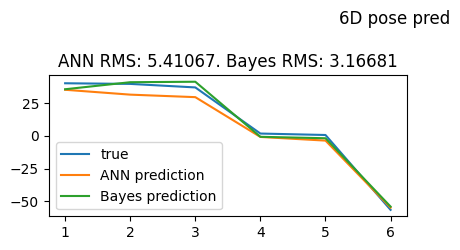


- test run 94.
      True pose:      [39.88867 35.31595 42.29223 -0.00458 -3.50615 -58.21573]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 4.482e-05 | -0.02746  | -0.07467  | -1.025    | 40.28     | 34.51     | 44.14     |
| 9         | 4.673e-05 | -0.0186   | -0.09348  | -1.058    | 41.68     | 32.43     | 39.95     |
| 10        | 5.421e-05 | -0.000815 | -0.1002   | -1.01     | 36.36     | 36.21     | 44.29     |
| 23        | 5.462e-05 | -0.003409 | -0.09841  | -1.014    | 35.96     | 35.88     | 44.14     |
| 25        | 5.485e-05 | -0.01085  | -0.101    | -1.006    | 36.07     | 35.69     | 43.92     |
| 27        | 5.631e-05 | -0.005873 | -0.1034   | -1.006    | 35.74     | 35.71     | 43.99     |
| 29        | 5.699e-05 | -0.009946 | -0.1017   | -0.9988   | 35.22  

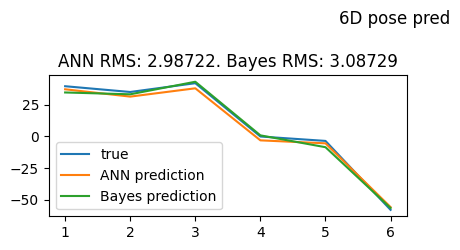


- test run 95.
      True pose:      [40.17195 36.06710 44.11263 1.43333 4.50613 -61.38196]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.573e-05 | -0.002363 | 0.06517   | -1.08     | 40.56     | 35.26     | 45.96     |
| 3         | 5.825e-05 | -0.000775 | 0.1116    | -1.113    | 41.88     | 35.24     | 44.7      |
| 20        | 5.848e-05 | 0.01357   | 0.1196    | -1.114    | 41.84     | 35.09     | 45.27     |
| 22        | 5.892e-05 | 0.02711   | 0.107     | -1.11     | 42.64     | 34.6      | 44.93     |
| 31        | 5.926e-05 | 0.02766   | 0.1057    | -1.109    | 42.35     | 34.54     | 45.52     |
| 32        | 5.973e-05 | 0.02537   | 0.1064    | -1.114    | 41.49     | 33.94     | 46.43     |
| 35        | 6.016e-05 | 0.01879   | 0.1122    | -1.113    | 41.4     

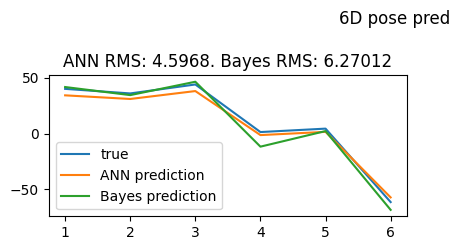


- test run 96.
      True pose:      [41.45887 35.08387 43.65477 1.80741 4.07993 -57.09928]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.807e-05 | 0.004166  | 0.05773   | -1.006    | 41.85     | 34.28     | 45.51     |
| 10        | 5.906e-05 | 0.03081   | 0.03223   | -0.9901   | 37.93     | 35.98     | 45.65     |
| 20        | 6.103e-05 | 0.006699  | 0.04683   | -0.9918   | 41.02     | 31.98     | 45.52     |
| 21        | 6.16e-05  | -0.007025 | 0.04326   | -0.9674   | 41.18     | 31.02     | 45.95     |
| 23        | 6.209e-05 | -0.008252 | 0.03385   | -0.9639   | 42.2      | 30.57     | 45.25     |
| 28        | 6.38e-05  | -0.004011 | 0.02823   | -0.9702   | 41.53     | 30.15     | 45.46     |
| 32        | 6.42e-05  | 0.0002494 | 0.02795   | -0.9775   | 41.48    

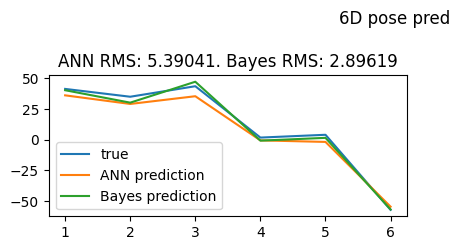


- test run 97.
      True pose:      [42.33459 39.59902 35.75314 0.83785 -4.11118 -56.73169]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.777e-05 | -0.01276  | -0.08523  | -0.9992   | 42.72     | 38.79     | 37.61     |
| 5         | 5.797e-05 | 0.04747   | -0.03732  | -1.026    | 37.73     | 36.3      | 39.53     |
| 9         | 6.385e-05 | -0.003897 | -0.104    | -1.032    | 44.12     | 36.72     | 33.41     |
| 10        | 6.446e-05 | 0.01389   | -0.1107   | -0.9837   | 38.8      | 40.49     | 37.75     |
| 25        | 6.837e-05 | 0.02654   | -0.1106   | -0.9725   | 37.43     | 39.92     | 37.83     |
| 26        | 7.071e-05 | 0.04005   | -0.1134   | -0.9717   | 37.35     | 39.07     | 38.05     |
| 27        | 7.115e-05 | 0.0488    | -0.1085   | -0.9835   | 37.34   

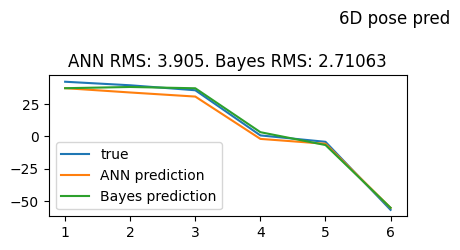


- test run 98.
      True pose:      [40.37935 44.07718 44.88086 -3.06436 3.79318 -60.10030]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 8.003e-05 | -0.08086  | 0.05273   | -1.058    | 40.77     | 43.27     | 46.73     |
| 5         | 8.25e-05  | -0.02064  | 0.1006    | -1.085    | 35.77     | 40.78     | 48.66     |
| 9         | 9.532e-05 | -0.072    | 0.03392   | -1.091    | 42.17     | 41.19     | 42.54     |
| 26        | 9.534e-05 | -0.08495  | 0.02371   | -1.086    | 40.27     | 42.28     | 44.57     |
| 31        | 9.642e-05 | -0.09072  | 0.02991   | -1.091    | 39.63     | 42.2      | 44.77     |
| 39        | 9.685e-05 | -0.09642  | 0.02568   | -1.091    | 39.77     | 42.15     | 44.52     |
| 41        | 9.694e-05 | -0.09412  | 0.02956   | -1.09     | 39.97   

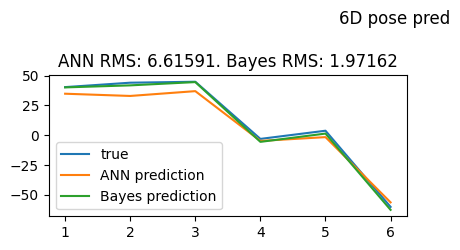


- test run 99.
      True pose:      [44.66841 37.46839 35.80632 -2.27884 -2.38763 -58.96549]
1/1 [==============================] - 0s 23ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 4.856e-05 | -0.06715  | -0.05515  | -1.038    | 45.06     | 36.66     | 37.66     |
| 3         | 4.897e-05 | -0.06556  | -0.008675 | -1.07     | 46.37     | 36.64     | 36.39     |
| 5         | 4.927e-05 | -0.006927 | -0.007236 | -1.065    | 40.06     | 34.17     | 39.59     |
| 9         | 5.213e-05 | -0.05829  | -0.07396  | -1.071    | 46.46     | 34.58     | 33.46     |
| 10        | 5.812e-05 | -0.04051  | -0.08065  | -1.023    | 41.14     | 38.36     | 37.8      |
| 26        | 5.878e-05 | -0.04536  | -0.08373  | -1.031    | 41.26     | 39.04     | 36.65     |
| 29        | 6.038e-05 | -0.05062  | -0.08315  | -1.02     | 40.49  

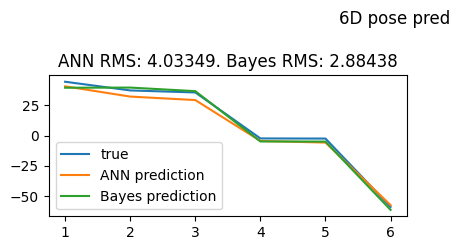


- test run 100.
      True pose:      [38.69873 44.51781 41.53475 2.54134 3.05483 -56.02159]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 6.178e-05 | 0.01698   | 0.03984   | -0.9868   | 39.09     | 43.71     | 43.39     |
| 10        | 6.79e-05  | 0.04362   | 0.01434   | -0.9713   | 35.17     | 45.41     | 43.53     |
| 31        | 6.985e-05 | 0.03316   | 0.01245   | -0.9658   | 34.83     | 44.87     | 43.76     |
| 39        | 7.057e-05 | 0.02596   | 0.01175   | -0.9652   | 34.93     | 44.74     | 43.77     |
| 44        | 7.113e-05 | 0.02426   | 0.01047   | -0.962    | 34.94     | 44.74     | 43.69     |
| 46        | 7.147e-05 | 0.01785   | 0.01047   | -0.9641   | 35.16     | 44.75     | 43.92     |
| 50        | 7.261e-05 | 0.0111    | 0.009692  | -0.958    | 35.29   

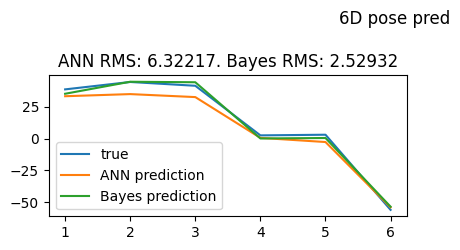


- test run 101.
      True pose:      [35.99036 39.10351 44.65069 4.23636 -4.14667 -60.64138]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.395e-05 | 0.04656   | -0.08585  | -1.067    | 36.38     | 38.3      | 46.5      |
| 9         | 5.578e-05 | 0.05542   | -0.1047   | -1.1      | 37.78     | 36.22     | 42.31     |
| 10        | 7.026e-05 | 0.0732    | -0.1113   | -1.052    | 32.46     | 40.0      | 46.65     |
| 28        | 7.122e-05 | 0.07912   | -0.109    | -1.053    | 31.66     | 38.32     | 44.96     |
| 30        | 7.334e-05 | 0.07696   | -0.114    | -1.051    | 31.7      | 38.75     | 44.49     |
| 31        | 7.459e-05 | 0.0869    | -0.1106   | -1.045    | 31.07     | 38.93     | 44.52     |
| 32        | 7.581e-05 | 0.08361   | -0.1143   | -1.046    | 31.09  

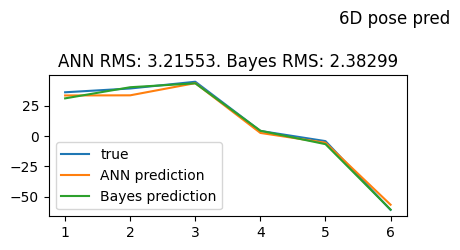


- test run 102.
      True pose:      [44.25188 37.65185 41.09560 -3.90545 2.39401 -59.77810]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 8.204e-05 | -0.09554  | 0.02831   | -1.052    | 44.64     | 36.84     | 42.95     |
| 5         | 8.714e-05 | -0.03532  | 0.07622   | -1.08     | 39.64     | 34.35     | 44.88     |
| 9         | 9.743e-05 | -0.08668  | 0.009497  | -1.085    | 46.04     | 34.77     | 38.75     |
| 31        | 0.0001001 | -0.08917  | 0.002739  | -1.087    | 46.8      | 35.5      | 39.97     |
| 34        | 0.0001005 | -0.08609  | -0.000572 | -1.086    | 46.96     | 35.24     | 40.39     |
| 45        | 0.0001007 | -0.09288  | -0.001384 | -1.086    | 47.13     | 35.26     | 40.42     |
| 49        | 0.000101  | -0.08891  | -0.001155 | -1.087    | 47.19  

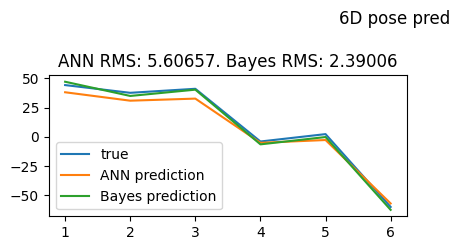


- test run 103.
      True pose:      [35.27582 36.83045 39.61523 -3.47267 -2.88320 -58.17197]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.65e-05  | -0.08799  | -0.0638   | -1.024    | 35.66     | 36.02     | 41.47     |
| 5         | 5.978e-05 | -0.02776  | -0.01589  | -1.052    | 30.67     | 33.53     | 43.4      |
| 9         | 6.122e-05 | -0.07913  | -0.08261  | -1.057    | 37.06     | 33.95     | 37.27     |
| 10        | 7.054e-05 | -0.06134  | -0.0893   | -1.009    | 31.74     | 37.72     | 41.61     |
| 26        | 7.12e-05  | -0.04313  | -0.08561  | -1.002    | 30.35     | 38.42     | 40.95     |
| 27        | 7.292e-05 | -0.05293  | -0.09     | -0.9874   | 30.32     | 38.32     | 41.61     |
| 31        | 7.353e-05 | -0.04649  | -0.08767  | -0.9909   | 30.28 

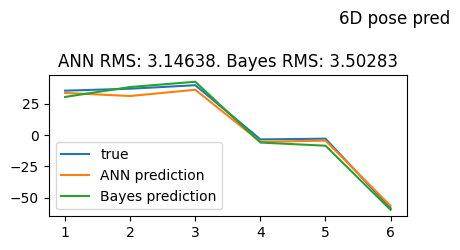


- test run 104.
      True pose:      [35.48270 40.75574 43.76827 -0.96294 -4.79536 -64.91767]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 6.337e-05 | -0.04419  | -0.09717  | -1.142    | 35.87     | 39.95     | 45.62     |
| 10        | 8.249e-05 | -0.01754  | -0.1227   | -1.127    | 31.95     | 41.65     | 45.77     |
| 26        | 8.357e-05 | -0.001369 | -0.1183   | -1.133    | 31.98     | 41.42     | 45.77     |
| 27        | 8.379e-05 | 0.01469   | -0.121    | -1.128    | 32.07     | 41.43     | 45.91     |
| 28        | 8.448e-05 | 0.02255   | -0.1203   | -1.132    | 31.9      | 41.63     | 45.95     |
| 31        | 8.636e-05 | 0.02048   | -0.1262   | -1.136    | 31.96     | 41.67     | 45.93     |
| 44        | 8.669e-05 | 0.01278   | -0.1267   | -1.13     | 31.85 

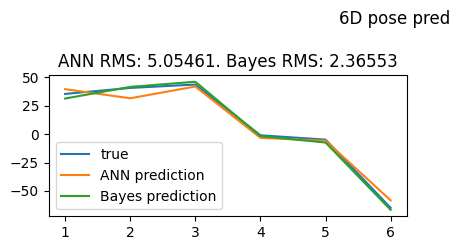


- test run 105.
      True pose:      [36.96816 37.84652 39.05543 4.00887 0.89065 -61.94697]
1/1 [==============================] - 0s 20ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 6.413e-05 | 0.04259   | 0.002067  | -1.09     | 37.36     | 37.04     | 40.91     |
| 9         | 6.572e-05 | 0.05145   | -0.01674  | -1.123    | 38.76     | 34.96     | 36.71     |
| 27        | 6.653e-05 | 0.04543   | -0.02701  | -1.112    | 38.83     | 35.24     | 36.78     |
| 39        | 6.746e-05 | 0.04135   | -0.02799  | -1.119    | 38.55     | 35.4      | 36.75     |
| 40        | 6.753e-05 | 0.03679   | -0.0247   | -1.121    | 38.32     | 35.59     | 36.69     |
| 43        | 6.771e-05 | 0.04106   | -0.02416  | -1.124    | 38.38     | 35.66     | 36.59     |
| 45        | 6.775e-05 | 0.03852   | -0.02802  | -1.12     | 38.41   

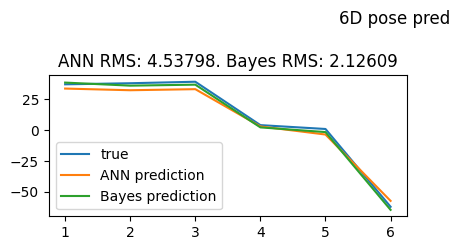


- test run 106.
      True pose:      [44.03591 40.02628 39.73133 -2.53607 -3.49734 -64.44285]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 7.104e-05 | -0.07164  | -0.07452  | -1.134    | 44.42     | 39.22     | 41.58     |
| 10        | 8.958e-05 | -0.045    | -0.1      | -1.118    | 40.5      | 40.92     | 41.73     |
| 20        | 9.14e-05  | -0.01484  | -0.08738  | -1.134    | 39.91     | 41.07     | 41.47     |
| 21        | 9.432e-05 | -0.03302  | -0.08877  | -1.143    | 39.63     | 40.37     | 41.97     |
| 25        | 0.0001003 | -0.03601  | -0.1035   | -1.144    | 39.17     | 42.68     | 43.18     |
| 39        | 0.0001015 | -0.04315  | -0.1041   | -1.149    | 39.27     | 42.29     | 43.0      |
| 40        | 0.0001022 | -0.0449   | -0.1045   | -1.156    | 39.11 

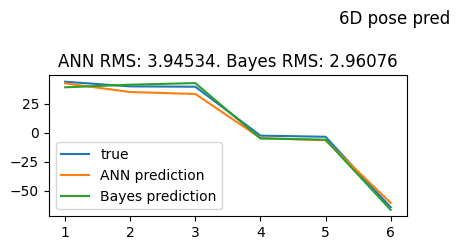


- test run 107.
      True pose:      [35.93055 40.63935 38.28293 4.64106 -2.33219 -64.47844]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 9.766e-05 | 0.05362   | -0.05418  | -1.134    | 36.32     | 39.83     | 40.14     |
| 9         | 9.877e-05 | 0.06248   | -0.07299  | -1.167    | 37.72     | 37.76     | 35.94     |
| 10        | 0.0001073 | 0.08027   | -0.07968  | -1.119    | 32.4      | 41.53     | 40.28     |
| 20        | 0.0001084 | 0.07981   | -0.05904  | -1.121    | 32.1      | 41.82     | 39.87     |
| 23        | 0.0001182 | 0.07886   | -0.05499  | -1.146    | 31.61     | 41.08     | 39.66     |
| 24        | 0.0001243 | 0.07004   | -0.07238  | -1.159    | 31.18     | 40.36     | 39.29     |
| 26        | 0.0001258 | 0.0694    | -0.0839   | -1.158    | 30.93  

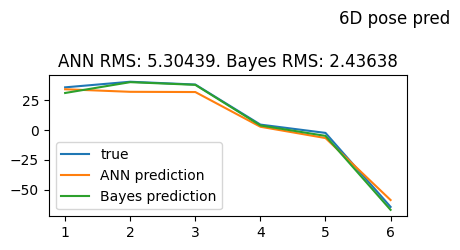


- test run 108.
      True pose:      [37.48158 43.24559 41.93101 -0.88035 -2.08953 -60.79660]
1/1 [==============================] - 0s 20ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 5         | 5.155e-05 | 0.01748   | -0.002033 | -1.097    | 32.87     | 39.94     | 45.71     |
| 9         | 5.192e-05 | -0.03389  | -0.06876  | -1.103    | 39.27     | 40.36     | 39.59     |
| 25        | 5.207e-05 | -0.04601  | -0.07092  | -1.101    | 38.24     | 41.83     | 40.54     |
| 35        | 5.207e-05 | -0.04118  | -0.07809  | -1.104    | 38.73     | 41.2      | 40.95     |
| 36        | 5.216e-05 | -0.03734  | -0.06905  | -1.104    | 38.56     | 41.12     | 41.34     |
| 46        | 5.223e-05 | -0.03479  | -0.062    | -1.103    | 38.46     | 41.05     | 41.1      |
| 50        | 5.231e-05 | -0.03685  | -0.06267  | -1.103    | 38.46 

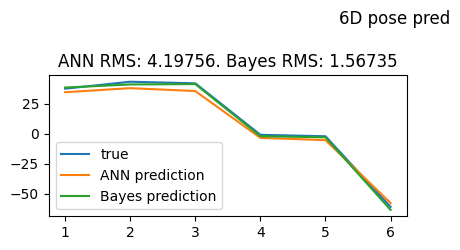


- test run 109.
      True pose:      [44.29140 39.49032 35.12308 2.42835 -1.60547 -55.11506]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 7.201e-05 | 0.015     | -0.0415   | -0.9709   | 44.68     | 38.68     | 36.98     |
| 6         | 7.202e-05 | 0.007332  | -0.03491  | -0.922    | 44.62     | 41.41     | 33.28     |
| 10        | 8.284e-05 | 0.04165   | -0.067    | -0.9555   | 40.76     | 40.38     | 37.12     |
| 22        | 8.438e-05 | 0.06896   | -0.06322  | -0.933    | 40.74     | 39.32     | 36.07     |
| 25        | 8.573e-05 | 0.05612   | -0.05679  | -0.9408   | 39.97     | 40.35     | 35.95     |
| 26        | 8.634e-05 | 0.07305   | -0.05859  | -0.9241   | 40.1      | 40.16     | 34.76     |
| 28        | 8.962e-05 | 0.06904   | -0.06636  | -0.9321   | 39.3   

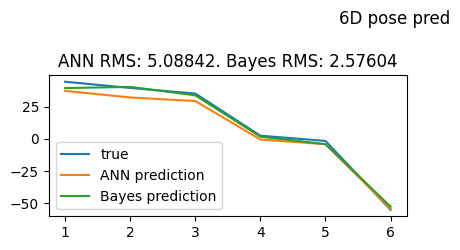


- test run 110.
      True pose:      [38.34914 42.17558 44.72014 -0.26298 -0.12746 -56.86196]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 6.348e-05 | -0.03197  | -0.0157   | -1.001    | 38.74     | 41.37     | 46.57     |
| 9         | 6.486e-05 | -0.02311  | -0.03451  | -1.034    | 40.14     | 39.29     | 42.38     |
| 10        | 7.073e-05 | -0.005325 | -0.0412   | -0.986    | 34.82     | 43.07     | 46.72     |
| 22        | 7.137e-05 | 0.00613   | -0.03764  | -0.9906   | 34.23     | 42.63     | 46.53     |
| 23        | 7.254e-05 | 0.002034  | -0.03928  | -0.9921   | 34.14     | 42.11     | 45.37     |
| 24        | 7.347e-05 | -0.006008 | -0.0348   | -1.003    | 33.37     | 41.39     | 45.33     |
| 27        | 7.376e-05 | -0.0131   | -0.03408  | -1.001    | 33.35 

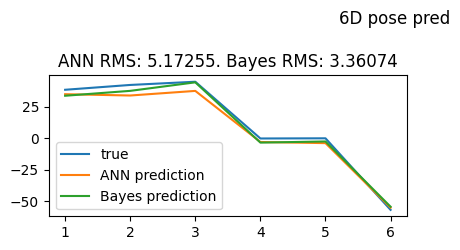


- test run 111.
      True pose:      [37.96449 43.56566 43.89543 2.50760 1.86220 -56.57797]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.829e-05 | 0.01639   | 0.01902   | -0.9965   | 38.35     | 42.76     | 45.75     |
| 6         | 6.058e-05 | 0.008715  | 0.02562   | -0.9475   | 38.3      | 45.48     | 42.05     |
| 10        | 6.493e-05 | 0.04303   | -0.006475 | -0.981    | 34.43     | 44.46     | 45.89     |
| 23        | 6.495e-05 | 0.03064   | -0.002675 | -0.9865   | 34.58     | 44.32     | 45.93     |
| 28        | 6.667e-05 | 0.02596   | -0.008271 | -0.9732   | 34.54     | 44.62     | 46.14     |
| 30        | 6.702e-05 | 0.01749   | -0.005905 | -0.9759   | 34.32     | 44.48     | 46.24     |
| 32        | 6.781e-05 | 0.01009   | -0.01105  | -0.9754   | 34.77   

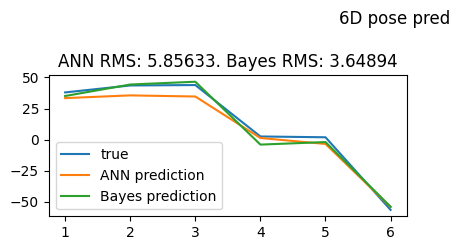


- test run 112.
      True pose:      [36.23458 41.92280 41.12635 2.22122 0.97025 -57.17156]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.568e-05 | 0.01139   | 0.003457  | -1.007    | 36.62     | 41.11     | 42.98     |
| 6         | 5.683e-05 | 0.003717  | 0.01005   | -0.9579   | 36.57     | 43.84     | 39.28     |
| 10        | 6.135e-05 | 0.03803   | -0.02204  | -0.9914   | 32.7      | 42.82     | 43.12     |
| 24        | 6.172e-05 | 0.03612   | -0.01703  | -0.9906   | 31.99     | 43.09     | 43.07     |
| 26        | 6.264e-05 | 0.02101   | -0.01421  | -0.9868   | 31.99     | 43.0      | 42.17     |
| 27        | 6.425e-05 | 0.01801   | -0.01865  | -0.9911   | 31.29     | 42.35     | 41.61     |
| 29        | 6.474e-05 | 0.01939   | -0.0252   | -0.9951   | 31.25   

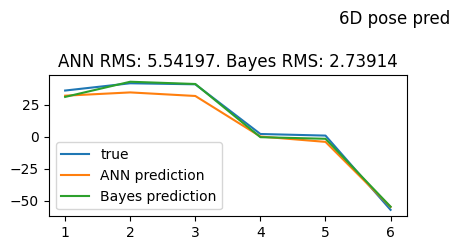


- test run 113.
      True pose:      [39.66178 40.64124 44.89005 1.87821 -2.01366 -56.23214]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 6.761e-05 | 0.005402  | -0.04862  | -0.9904   | 40.05     | 39.83     | 46.74     |
| 10        | 7.88e-05  | 0.03205   | -0.07412  | -0.975    | 36.13     | 41.53     | 46.89     |
| 26        | 8.041e-05 | 0.03536   | -0.07071  | -0.9574   | 35.91     | 41.41     | 46.81     |
| 29        | 8.347e-05 | 0.04371   | -0.07214  | -0.9498   | 35.08     | 41.39     | 45.99     |
| 30        | 8.433e-05 | 0.05226   | -0.07763  | -0.9558   | 34.89     | 41.09     | 45.48     |
| 35        | 8.482e-05 | 0.05707   | -0.07817  | -0.9486   | 35.13     | 40.3      | 45.25     |
| 38        | 8.532e-05 | 0.06226   | -0.07509  | -0.9425   | 34.71  

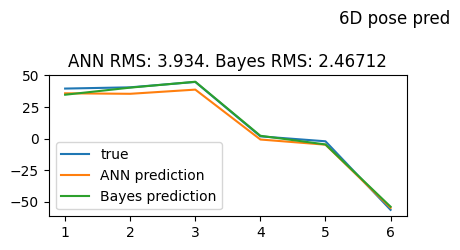


- test run 114.
      True pose:      [35.60406 35.99938 35.98136 2.80342 1.01319 -60.37279]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.071e-05 | 0.02155   | 0.004206  | -1.063    | 35.99     | 35.19     | 37.83     |
| 6         | 5.197e-05 | 0.01388   | 0.0108    | -1.014    | 35.94     | 37.92     | 34.14     |
| 9         | 5.276e-05 | 0.03041   | -0.0146   | -1.096    | 37.39     | 33.12     | 33.64     |
| 30        | 5.319e-05 | 0.02499   | -0.02506  | -1.095    | 37.43     | 33.1      | 33.73     |
| 52        | 5.341e-05 | 0.01913   | -0.02582  | -1.097    | 37.32     | 33.16     | 33.71     |
| 66        | 5.342e-05 | 0.02492   | -0.02548  | -1.097    | 37.3      | 33.17     | 33.73     |
| 68        | 5.342e-05 | 0.0268    | -0.02585  | -1.097    | 37.3    

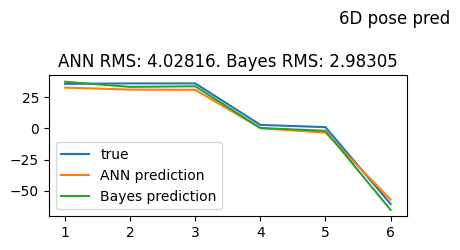


- test run 115.
      True pose:      [43.32904 35.10683 43.80491 -3.51411 -4.14509 -60.48591]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 5         | 6.153e-05 | -0.02849  | -0.03791  | -1.092    | 38.72     | 31.81     | 47.59     |
| 9         | 6.508e-05 | -0.07985  | -0.1046   | -1.098    | 45.12     | 32.22     | 41.46     |
| 31        | 6.566e-05 | -0.08426  | -0.1096   | -1.097    | 43.93     | 31.26     | 40.27     |
| 38        | 6.64e-05  | -0.08773  | -0.1099   | -1.099    | 43.76     | 31.07     | 40.19     |
| 44        | 6.726e-05 | -0.0931   | -0.1159   | -1.099    | 43.49     | 30.78     | 40.41     |
| 47        | 6.759e-05 | -0.0996   | -0.1068   | -1.099    | 43.64     | 30.98     | 40.4      |
| 50        | 6.776e-05 | -0.1044   | -0.1068   | -1.099    | 43.74 

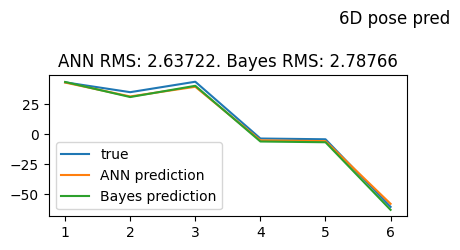


- test run 116.
      True pose:      [38.02282 41.57006 35.12540 0.60169 -4.78403 -62.06894]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 3         | 4.548e-05 | -0.01529  | -0.0505   | -1.125    | 39.73     | 40.74     | 35.71     |
| 5         | 4.877e-05 | 0.04335   | -0.04906  | -1.12     | 33.41     | 38.27     | 38.91     |
| 9         | 5.328e-05 | -0.008019 | -0.1158   | -1.125    | 39.81     | 38.69     | 32.78     |
| 25        | 5.481e-05 | -0.02014  | -0.1179   | -1.124    | 38.78     | 40.16     | 33.74     |
| 28        | 5.557e-05 | -0.008598 | -0.1251   | -1.117    | 37.97     | 40.99     | 32.87     |
| 30        | 5.743e-05 | -0.002872 | -0.1242   | -1.122    | 38.19     | 41.67     | 34.08     |
| 35        | 5.891e-05 | 0.001953  | -0.127    | -1.126    | 38.66  

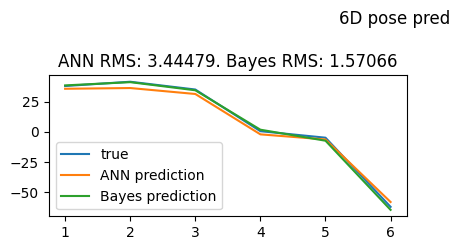


- test run 117.
      True pose:      [39.39645 36.75465 35.87369 3.43318 -1.26486 -59.64031]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 4.797e-05 | 0.03254   | -0.03555  | -1.05     | 39.78     | 35.95     | 37.73     |
| 6         | 5.568e-05 | 0.02487   | -0.02896  | -1.001    | 39.73     | 38.67     | 34.03     |
| 10        | 5.636e-05 | 0.05918   | -0.06105  | -1.034    | 35.86     | 37.65     | 37.87     |
| 13        | 5.957e-05 | 0.02844   | 0.004749  | -1.05     | 36.05     | 41.03     | 34.35     |
| 20        | 6.104e-05 | 0.04392   | -0.006081 | -1.036    | 35.29     | 40.63     | 35.09     |
| 22        | 6.227e-05 | 0.05225   | -0.01276  | -1.029    | 34.43     | 41.67     | 35.2      |
| 24        | 6.245e-05 | 0.03281   | -0.007609 | -1.043    | 35.35  

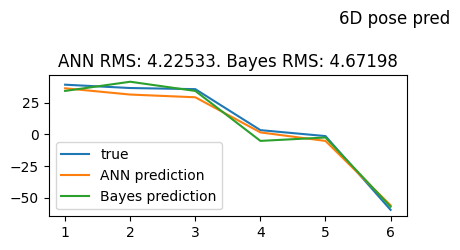


- test run 118.
      True pose:      [41.16092 37.33585 36.90940 1.39550 -1.39748 -63.80993]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 7.602e-05 | -0.003023 | -0.03787  | -1.123    | 41.55     | 36.53     | 38.76     |
| 10        | 8.075e-05 | 0.02362   | -0.06337  | -1.107    | 37.63     | 38.23     | 38.91     |
| 19        | 8.456e-05 | 0.02912   | -0.01413  | -1.153    | 37.51     | 38.14     | 38.79     |
| 26        | 8.824e-05 | 0.02665   | -0.02088  | -1.143    | 36.29     | 38.5      | 38.97     |
| 27        | 9.086e-05 | 0.0238    | -0.03655  | -1.155    | 36.16     | 38.91     | 39.07     |
| 28        | 9.154e-05 | 0.02387   | -0.04337  | -1.154    | 36.21     | 38.94     | 38.68     |
| 29        | 9.156e-05 | 0.01208   | -0.04638  | -1.157    | 36.19  

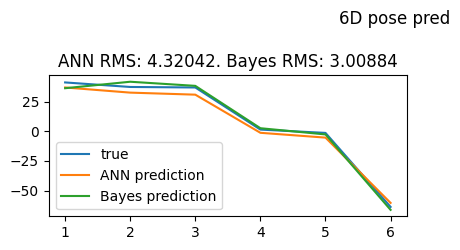


- test run 119.
      True pose:      [39.10843 42.10852 43.74186 0.93874 2.31606 -64.26604]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 7.305e-05 | -0.01099  | 0.02695   | -1.131    | 39.5      | 41.3      | 45.59     |
| 10        | 7.442e-05 | 0.01565   | 0.001446  | -1.115    | 35.58     | 43.0      | 45.74     |
| 20        | 7.542e-05 | 0.02253   | 0.00193   | -1.148    | 36.06     | 42.84     | 45.64     |
| 21        | 7.654e-05 | 0.001616  | 0.008029  | -1.15     | 37.41     | 42.37     | 45.96     |
| 24        | 7.708e-05 | -0.01574  | 0.006886  | -1.133    | 36.87     | 42.9      | 46.74     |
| 27        | 7.745e-05 | -0.01049  | 0.0131    | -1.14     | 35.14     | 44.77     | 48.52     |
| 29        | 7.819e-05 | -0.000449 | 0.01503   | -1.148    | 34.15   

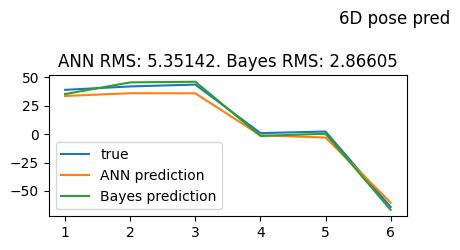


- test run 120.
      True pose:      [37.83330 40.77426 42.57029 1.21555 3.10578 -62.43013]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 6.168e-05 | -0.006164 | 0.04073   | -1.099    | 38.22     | 39.97     | 44.42     |
| 25        | 6.39e-05  | -0.01509  | 0.03228   | -1.113    | 37.18     | 41.44     | 45.39     |
| 29        | 6.426e-05 | -0.002478 | 0.03874   | -1.117    | 36.79     | 40.92     | 45.63     |
| 30        | 6.457e-05 | 0.003165  | 0.03193   | -1.123    | 37.02     | 41.63     | 46.87     |
| 32        | 6.486e-05 | -0.005653 | 0.02906   | -1.124    | 36.56     | 41.9      | 46.49     |
| 35        | 6.498e-05 | -0.000828 | 0.0219    | -1.131    | 37.04     | 41.31     | 46.89     |
| 36        | 6.506e-05 | 0.003594  | 0.02618   | -1.133    | 36.73   

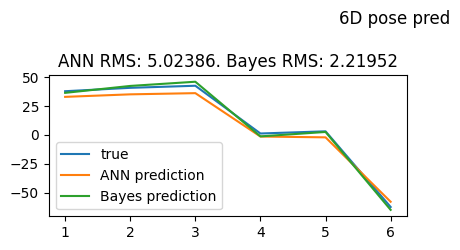


- test run 121.
      True pose:      [43.78553 41.34380 39.84602 1.72333 -1.99128 -57.47984]
1/1 [==============================] - 0s 20ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.285e-05 | 0.002699  | -0.04823  | -1.012    | 44.17     | 40.54     | 41.7      |
| 6         | 5.67e-05  | -0.004973 | -0.04164  | -0.9633   | 44.12     | 43.26     | 38.0      |
| 10        | 5.959e-05 | 0.02934   | -0.07373  | -0.9967   | 40.25     | 42.24     | 41.84     |
| 20        | 5.998e-05 | 0.03624   | -0.06627  | -0.9853   | 41.18     | 39.61     | 40.0      |
| 24        | 6.149e-05 | 0.04721   | -0.06764  | -0.9734   | 40.87     | 39.82     | 40.11     |
| 25        | 6.353e-05 | 0.03453   | -0.06311  | -0.9613   | 40.63     | 39.71     | 40.01     |
| 35        | 6.445e-05 | 0.03142   | -0.06582  | -0.9659   | 39.87  

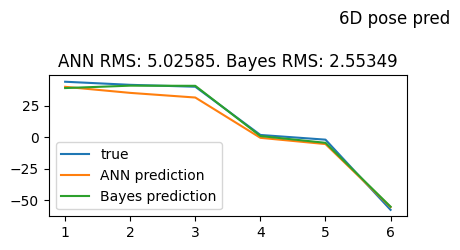


- test run 122.
      True pose:      [41.08624 36.14829 35.67080 -4.82946 -3.16949 -63.70000]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 8.991e-05 | -0.1117   | -0.0688   | -1.121    | 41.47     | 35.34     | 37.52     |
| 5         | 9.204e-05 | -0.05144  | -0.02088  | -1.148    | 36.48     | 32.85     | 39.45     |
| 10        | 9.977e-05 | -0.08503  | -0.09429  | -1.105    | 37.55     | 37.04     | 37.67     |
| 23        | 0.0001005 | -0.1017   | -0.07801  | -1.109    | 37.29     | 36.48     | 38.29     |
| 24        | 0.000103  | -0.1154   | -0.06492  | -1.118    | 36.76     | 37.06     | 37.92     |
| 26        | 0.0001125 | -0.1243   | -0.06438  | -1.134    | 36.15     | 35.75     | 39.9      |
| 27        | 0.0001142 | -0.1087   | -0.06626  | -1.137    | 36.09 

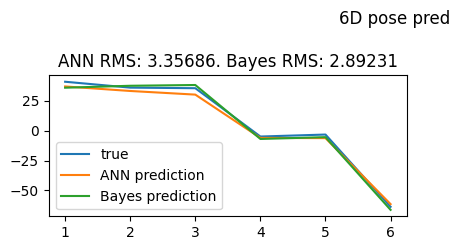


- test run 123.
      True pose:      [38.14503 40.05874 36.17056 1.62480 -0.73861 -60.02822]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 4.465e-05 | 0.0009792 | -0.02637  | -1.057    | 38.53     | 39.25     | 38.02     |
| 6         | 4.997e-05 | -0.006693 | -0.01978  | -1.008    | 38.48     | 41.98     | 34.33     |
| 10        | 5.103e-05 | 0.02762   | -0.05187  | -1.041    | 34.61     | 40.95     | 38.17     |
| 13        | 5.394e-05 | -0.003121 | 0.01393   | -1.057    | 34.8      | 44.33     | 34.65     |
| 21        | 5.457e-05 | 0.008783  | -0.005527 | -1.042    | 35.12     | 43.0      | 34.85     |
| 23        | 5.641e-05 | -0.003489 | 0.004132  | -1.019    | 34.34     | 43.38     | 35.92     |
| 24        | 5.69e-05  | 0.00518   | 0.01155   | -1.035    | 33.34  

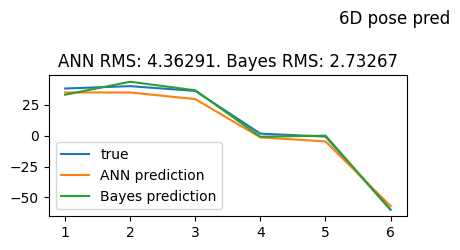


- test run 124.
      True pose:      [37.68473 44.59980 37.72207 -3.67270 -0.87381 -64.13823]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 9.901e-05 | -0.09148  | -0.02873  | -1.128    | 38.07     | 43.79     | 39.57     |
| 10        | 0.0001034 | -0.06484  | -0.05423  | -1.113    | 34.15     | 45.49     | 39.72     |
| 19        | 0.0001072 | -0.05838  | -0.02377  | -1.128    | 35.54     | 44.12     | 40.24     |
| 22        | 0.000115  | -0.07501  | -0.0315   | -1.154    | 34.17     | 43.49     | 39.38     |
| 23        | 0.000115  | -0.07142  | -0.02151  | -1.139    | 33.05     | 43.02     | 38.7      |
| 26        | 0.0001151 | -0.05459  | -0.03529  | -1.146    | 32.69     | 43.77     | 38.0      |
| 30        | 0.0001158 | -0.05549  | -0.04418  | -1.149    | 32.69 

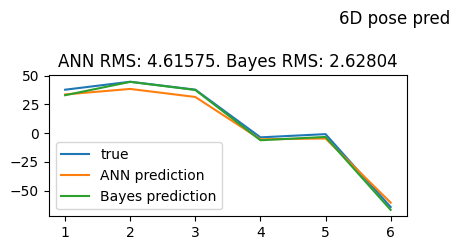


- test run 125.
      True pose:      [39.11551 44.01374 37.51171 -4.86566 0.87950 -59.47045]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 8.782e-05 | -0.1123   | 0.001873  | -1.047    | 39.5      | 43.21     | 39.36     |
| 5         | 0.0001    | -0.05208  | 0.04979   | -1.074    | 34.51     | 40.71     | 41.29     |
| 9         | 0.0001033 | -0.1034   | -0.01694  | -1.08     | 40.9      | 41.13     | 35.17     |
| 21        | 0.0001041 | -0.08574  | -0.01783  | -1.08     | 41.08     | 41.57     | 35.39     |
| 35        | 0.000107  | -0.08092  | -0.025    | -1.081    | 41.58     | 40.92     | 35.8      |
| 62        | 0.0001072 | -0.07903  | -0.027    | -1.082    | 41.6      | 40.96     | 35.84     |
| 66        | 0.0001072 | -0.08445  | -0.02631  | -1.081    | 41.62  

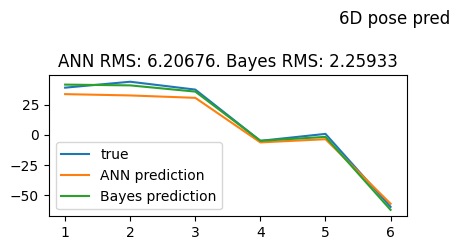


- test run 126.
      True pose:      [37.48875 38.03606 39.79822 4.05746 4.78230 -59.60359]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 5         | 5.47e-05  | 0.1037    | 0.1179    | -1.076    | 32.88     | 34.73     | 43.58     |
| 17        | 5.545e-05 | 0.106     | 0.0899    | -1.084    | 38.66     | 36.3      | 40.07     |
| 26        | 5.578e-05 | 0.1009    | 0.1033    | -1.083    | 39.37     | 36.49     | 41.99     |
| 32        | 5.605e-05 | 0.1058    | 0.107     | -1.083    | 39.02     | 37.13     | 43.06     |
| 36        | 5.608e-05 | 0.09865   | 0.1026    | -1.084    | 38.32     | 37.34     | 43.16     |
| 42        | 5.629e-05 | 0.103     | 0.1086    | -1.083    | 38.61     | 37.52     | 43.48     |
| 43        | 5.663e-05 | 0.1086    | 0.1143    | -1.081    | 38.38   

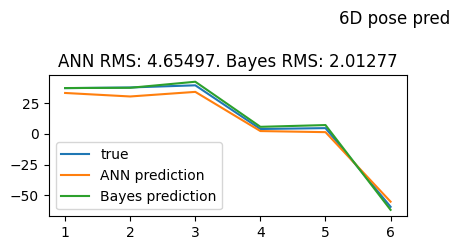


- test run 127.
      True pose:      [40.05997 39.05798 43.37752 -2.34733 0.20762 -61.63901]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 5         | 7.64e-05  | -0.008122 | 0.03806   | -1.112    | 35.45     | 35.76     | 47.16     |
| 9         | 7.952e-05 | -0.05949  | -0.02866  | -1.118    | 41.85     | 36.17     | 41.03     |
| 20        | 7.976e-05 | -0.08359  | -0.02515  | -1.114    | 41.63     | 36.23     | 40.63     |
| 30        | 8.174e-05 | -0.07479  | -0.02929  | -1.118    | 41.8      | 36.75     | 42.0      |
| 32        | 8.202e-05 | -0.08107  | -0.03633  | -1.115    | 41.53     | 36.78     | 42.22     |
| 34        | 8.372e-05 | -0.08259  | -0.03866  | -1.118    | 41.34     | 36.39     | 42.47     |
| 49        | 8.382e-05 | -0.08403  | -0.03396  | -1.119    | 41.28  

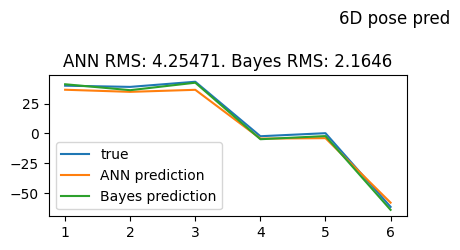


- test run 128.
      True pose:      [35.65861 39.80548 42.36431 1.17273 -1.50302 -63.58534]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 7.385e-05 | -0.006911 | -0.03971  | -1.119    | 36.05     | 39.0      | 44.22     |
| 9         | 7.601e-05 | 0.001948  | -0.05852  | -1.152    | 37.45     | 36.92     | 40.02     |
| 10        | 8.149e-05 | 0.01973   | -0.06521  | -1.103    | 32.13     | 40.7      | 44.36     |
| 22        | 8.221e-05 | 0.01489   | -0.05688  | -1.103    | 31.98     | 41.46     | 43.65     |
| 26        | 8.677e-05 | 0.01008   | -0.05358  | -1.118    | 31.92     | 42.39     | 42.7      |
| 31        | 9.075e-05 | 0.01353   | -0.05865  | -1.126    | 32.03     | 41.28     | 41.51     |
| 34        | 9.252e-05 | 0.01244   | -0.06431  | -1.129    | 31.83  

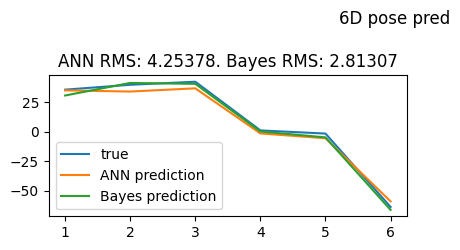


- test run 129.
      True pose:      [43.15913 44.56476 39.98730 0.01887 -0.05353 -61.85858]
1/1 [==============================] - 0s 17ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.682e-05 | -0.02705  | -0.01441  | -1.089    | 43.55     | 43.76     | 41.84     |
| 3         | 5.713e-05 | -0.02546  | 0.03206   | -1.121    | 44.86     | 43.74     | 40.57     |
| 5         | 5.774e-05 | 0.03318   | 0.0335    | -1.116    | 38.55     | 41.26     | 43.77     |
| 9         | 6.236e-05 | -0.01819  | -0.03322  | -1.122    | 44.95     | 41.68     | 37.64     |
| 32        | 6.263e-05 | -0.02006  | -0.0388   | -1.117    | 45.15     | 41.95     | 37.72     |
| 33        | 6.349e-05 | -0.01623  | -0.04128  | -1.121    | 45.17     | 41.86     | 37.72     |
| 35        | 6.356e-05 | -0.01141  | -0.04446  | -1.123    | 45.67  

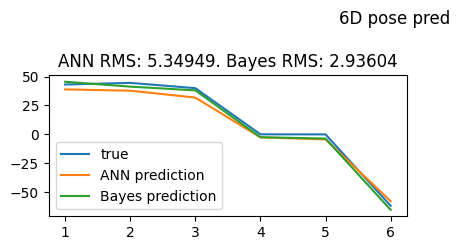


- test run 130.
      True pose:      [43.22569 36.06205 40.30191 -3.23290 -2.06903 -64.89447]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 9.297e-05 | -0.0838   | -0.04959  | -1.142    | 43.61     | 35.25     | 42.15     |
| 10        | 0.0001084 | -0.05716  | -0.07509  | -1.126    | 39.69     | 36.96     | 42.3      |
| 22        | 0.0001103 | -0.04401  | -0.07259  | -1.152    | 40.02     | 36.6      | 41.74     |
| 28        | 0.0001141 | -0.04662  | -0.07891  | -1.142    | 38.89     | 37.01     | 42.55     |
| 30        | 0.000115  | -0.05575  | -0.06951  | -1.14     | 38.36     | 36.91     | 43.18     |
| 37        | 0.0001169 | -0.06142  | -0.0726   | -1.147    | 38.24     | 36.26     | 42.64     |
| 40        | 0.0001176 | -0.06078  | -0.0781   | -1.152    | 38.23 

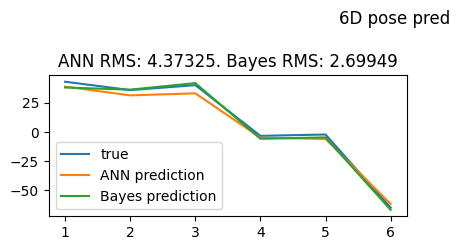


- test run 131.
      True pose:      [41.47807 39.77569 42.68939 2.59681 -0.41915 -56.65073]
1/1 [==============================] - 0s 17ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 6.181e-05 | 0.01794   | -0.02079  | -0.9978   | 41.87     | 38.97     | 44.54     |
| 6         | 6.21e-05  | 0.01027   | -0.0142   | -0.9488   | 41.81     | 41.69     | 40.84     |
| 10        | 6.588e-05 | 0.04459   | -0.04629  | -0.9823   | 37.95     | 40.67     | 44.69     |
| 20        | 6.617e-05 | 0.05149   | -0.03883  | -0.9709   | 38.87     | 38.04     | 42.84     |
| 21        | 6.619e-05 | 0.03147   | -0.01175  | -0.9551   | 38.92     | 38.07     | 42.92     |
| 22        | 6.667e-05 | 0.03293   | -0.02848  | -0.9703   | 39.21     | 37.45     | 42.98     |
| 28        | 6.958e-05 | 0.02885   | -0.02924  | -0.9699   | 37.61  

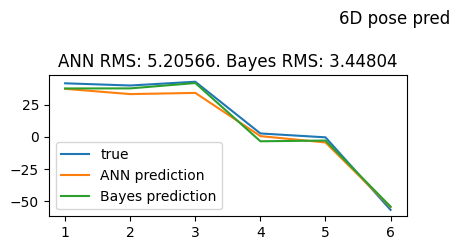


- test run 132.
      True pose:      [41.27984 35.36004 42.52445 3.52404 -4.32572 -63.24197]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 7.77e-05  | 0.03413   | -0.08898  | -1.113    | 41.67     | 34.55     | 44.38     |
| 9         | 8.343e-05 | 0.04299   | -0.1078   | -1.146    | 43.07     | 32.48     | 40.18     |
| 10        | 9.19e-05  | 0.06077   | -0.1145   | -1.097    | 37.75     | 36.25     | 44.52     |
| 21        | 0.0001007 | 0.06061   | -0.1144   | -1.124    | 37.69     | 36.65     | 44.52     |
| 23        | 0.0001039 | 0.06899   | -0.1146   | -1.131    | 37.44     | 36.69     | 44.7      |
| 25        | 0.0001069 | 0.08795   | -0.1121   | -1.147    | 37.49     | 36.85     | 44.98     |
| 41        | 0.0001076 | 0.0825    | -0.1138   | -1.147    | 37.51  

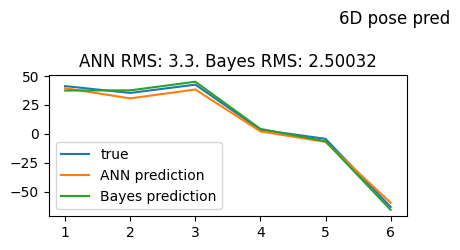


- test run 133.
      True pose:      [36.99033 44.81636 41.18832 -2.77904 2.71753 -62.93964]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 9.243e-05 | -0.07588  | 0.03395   | -1.108    | 37.38     | 44.01     | 43.04     |
| 9         | 9.581e-05 | -0.06702  | 0.01514   | -1.14     | 38.78     | 41.93     | 38.84     |
| 22        | 0.0001009 | -0.08757  | 0.004328  | -1.132    | 38.68     | 42.03     | 39.11     |
| 28        | 0.0001019 | -0.0882   | 0.01168   | -1.127    | 37.12     | 41.03     | 40.8      |
| 34        | 0.0001023 | -0.08717  | 0.01553   | -1.129    | 37.22     | 41.87     | 41.57     |
| 36        | 0.0001028 | -0.09038  | 0.01995   | -1.131    | 37.15     | 41.52     | 42.2      |
| 43        | 0.0001033 | -0.09204  | 0.01644   | -1.134    | 36.84  

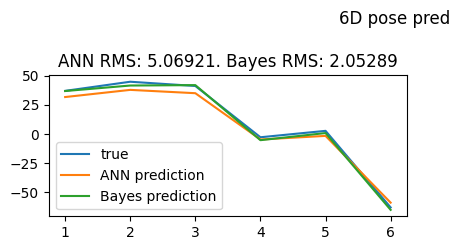


- test run 134.
      True pose:      [40.69850 44.56051 35.34016 3.46594 -3.37408 -62.83982]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 6.285e-05 | 0.03311   | -0.07237  | -1.106    | 41.09     | 43.75     | 37.19     |
| 5         | 6.625e-05 | 0.09334   | -0.02445  | -1.133    | 36.09     | 41.26     | 39.12     |
| 9         | 7.117e-05 | 0.04197   | -0.09117  | -1.139    | 42.49     | 41.68     | 33.0      |
| 10        | 7.197e-05 | 0.05976   | -0.09787  | -1.09     | 37.17     | 45.45     | 37.34     |
| 22        | 7.501e-05 | 0.05328   | -0.1016   | -1.116    | 37.54     | 45.38     | 37.42     |
| 23        | 7.81e-05  | 0.0547    | -0.09222  | -1.127    | 37.86     | 45.16     | 37.07     |
| 26        | 8.216e-05 | 0.07004   | -0.09484  | -1.132    | 37.94  

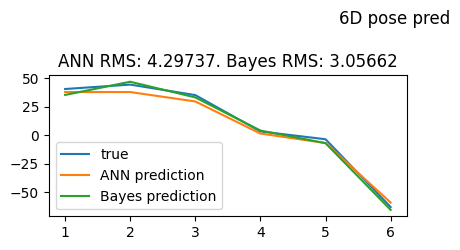


- test run 135.
      True pose:      [37.59083 37.75610 42.14992 -4.21299 1.75359 -62.67299]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 0.0001034 | -0.1009   | 0.01713   | -1.103    | 37.98     | 36.95     | 44.0      |
| 9         | 0.0001132 | -0.09205  | -0.00168  | -1.136    | 39.38     | 34.87     | 39.81     |
| 22        | 0.0001169 | -0.1126   | -0.0125   | -1.128    | 39.28     | 34.97     | 40.08     |
| 24        | 0.0001175 | -0.09414  | -0.005631 | -1.124    | 37.38     | 35.46     | 42.63     |
| 25        | 0.0001187 | -0.1006   | 0.009795  | -1.132    | 37.38     | 35.47     | 43.3      |
| 26        | 0.00012   | -0.1134   | 0.002497  | -1.134    | 36.93     | 35.88     | 43.04     |
| 30        | 0.0001202 | -0.1129   | 0.002268  | -1.135    | 35.65  

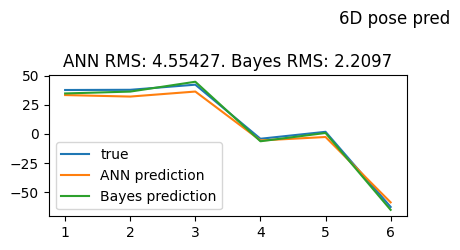


- test run 136.
      True pose:      [42.61073 40.18522 39.83932 3.81733 -4.99061 -62.06838]
1/1 [==============================] - 0s 21ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.759e-05 | 0.03925   | -0.1006   | -1.092    | 43.0      | 39.38     | 41.69     |
| 7         | 5.973e-05 | 0.0829    | -0.0579   | -1.125    | 45.11     | 45.07     | 42.32     |
| 9         | 6.42e-05  | 0.0481    | -0.1194   | -1.125    | 44.4      | 37.3      | 37.49     |
| 10        | 7.057e-05 | 0.06589   | -0.1261   | -1.077    | 39.08     | 41.08     | 41.84     |
| 24        | 7.077e-05 | 0.08374   | -0.1179   | -1.082    | 39.15     | 41.1      | 42.09     |
| 25        | 7.396e-05 | 0.08645   | -0.1297   | -1.091    | 39.33     | 41.13     | 41.85     |
| 26        | 7.401e-05 | 0.0749    | -0.1272   | -1.101    | 39.57  

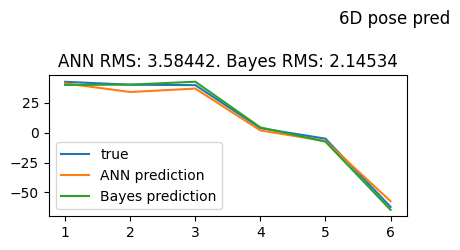


- test run 137.
      True pose:      [38.63390 40.57251 35.69208 4.49363 3.48515 -64.35073]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 3         | 6.455e-05 | 0.05264   | 0.09382   | -1.164    | 40.34     | 39.75     | 36.28     |
| 7         | 6.469e-05 | 0.0947    | 0.09003   | -1.165    | 41.14     | 45.46     | 38.17     |
| 17        | 6.555e-05 | 0.1136    | 0.06726   | -1.167    | 39.81     | 38.84     | 35.96     |
| 22        | 6.621e-05 | 0.1019    | 0.08277   | -1.164    | 41.14     | 36.53     | 33.66     |
| 24        | 6.644e-05 | 0.0963    | 0.08707   | -1.155    | 42.36     | 35.6      | 33.69     |
| 26        | 6.729e-05 | 0.1133    | 0.07276   | -1.152    | 42.62     | 36.63     | 33.75     |
| 29        | 6.808e-05 | 0.1097    | 0.08009   | -1.152    | 43.63   

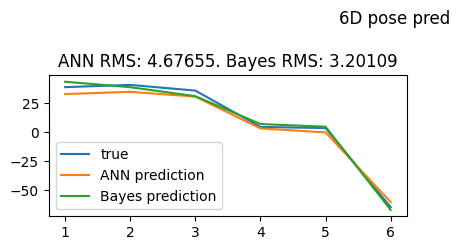


- test run 138.
      True pose:      [39.56121 35.20396 38.21520 2.42290 -2.92935 -58.85314]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 4.581e-05 | 0.01491   | -0.0646   | -1.036    | 39.95     | 34.4      | 40.07     |
| 6         | 5.062e-05 | 0.007237  | -0.05801  | -0.9872   | 39.89     | 37.12     | 36.37     |
| 10        | 5.825e-05 | 0.04155   | -0.0901   | -1.021    | 36.03     | 36.1      | 40.21     |
| 24        | 5.852e-05 | 0.04174   | -0.08351  | -1.032    | 35.4      | 35.91     | 39.86     |
| 26        | 5.978e-05 | 0.05128   | -0.07946  | -1.03     | 34.74     | 35.89     | 38.68     |
| 28        | 6.005e-05 | 0.03827   | -0.07445  | -1.031    | 34.58     | 36.7      | 37.47     |
| 36        | 6.139e-05 | 0.03289   | -0.07881  | -1.028    | 34.56  

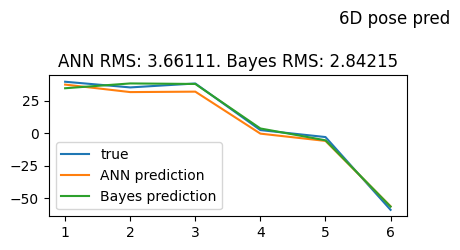


- test run 139.
      True pose:      [38.58128 36.73969 40.56484 -1.32043 4.26537 -59.58580]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 3         | 6.799e-05 | -0.04884  | 0.1074    | -1.081    | 40.29     | 35.91     | 41.15     |
| 9         | 7.443e-05 | -0.04157  | 0.04216   | -1.082    | 40.37     | 33.86     | 38.22     |
| 34        | 7.466e-05 | -0.04536  | 0.04071   | -1.081    | 40.81     | 34.74     | 39.05     |
| 38        | 7.501e-05 | -0.04783  | 0.04616   | -1.082    | 40.38     | 34.67     | 39.35     |
| 44        | 7.625e-05 | -0.05319  | 0.03897   | -1.084    | 40.11     | 34.38     | 39.56     |
| 50        | 7.641e-05 | -0.05936  | 0.04533   | -1.083    | 39.97     | 34.3      | 39.5      |
| 54        | 7.717e-05 | -0.06647  | 0.03937   | -1.084    | 39.89  

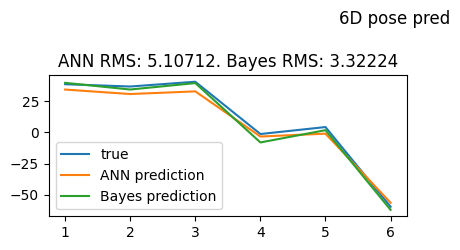


- test run 140.
      True pose:      [44.02867 37.88385 35.31953 2.20415 2.23257 -59.94003]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 4.846e-05 | 0.01109   | 0.02549   | -1.055    | 44.42     | 37.08     | 37.17     |
| 3         | 5.008e-05 | 0.01268   | 0.07196   | -1.087    | 45.73     | 37.06     | 35.91     |
| 9         | 5.124e-05 | 0.01995   | 0.00668   | -1.088    | 45.82     | 35.0      | 32.97     |
| 25        | 5.188e-05 | 0.007829  | 0.004514  | -1.086    | 44.79     | 36.47     | 33.93     |
| 30        | 5.212e-05 | 0.01382   | -0.000415 | -1.086    | 45.02     | 37.17     | 35.18     |
| 37        | 5.218e-05 | 0.00928   | 0.007533  | -1.086    | 45.37     | 37.19     | 35.02     |
| 40        | 5.269e-05 | 0.004178  | 0.01148   | -1.089    | 45.81   

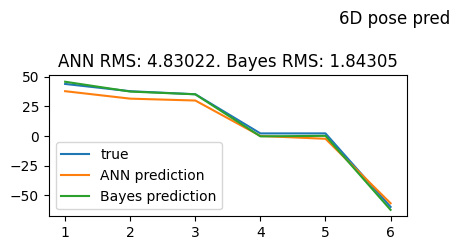


- test run 141.
      True pose:      [40.01880 43.25034 43.50280 1.47307 0.86293 -60.03266]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 4.843e-05 | -0.001669 | 0.001584  | -1.057    | 40.41     | 42.44     | 45.35     |
| 6         | 5.047e-05 | -0.009341 | 0.008176  | -1.008    | 40.35     | 45.17     | 41.66     |
| 10        | 5.465e-05 | 0.02497   | -0.02392  | -1.041    | 36.49     | 44.14     | 45.5      |
| 25        | 5.51e-05  | 0.004883  | -0.01563  | -1.055    | 36.21     | 43.77     | 45.29     |
| 28        | 5.54e-05  | 0.0008456 | -0.0272   | -1.064    | 35.7      | 43.14     | 45.15     |
| 33        | 5.677e-05 | -0.005249 | -0.02139  | -1.058    | 35.02     | 42.71     | 45.02     |
| 34        | 5.736e-05 | -0.003019 | -0.02325  | -1.056    | 35.02   

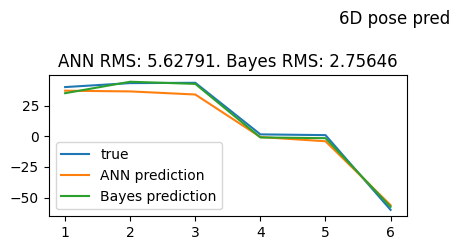


- test run 142.
      True pose:      [39.45202 38.76251 40.62965 -4.06150 -0.29540 -57.98443]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 7.993e-05 | -0.09827  | -0.01863  | -1.021    | 39.84     | 37.95     | 42.48     |
| 5         | 8.699e-05 | -0.03804  | 0.02928   | -1.048    | 34.84     | 35.46     | 44.41     |
| 9         | 8.899e-05 | -0.08941  | -0.03744  | -1.054    | 41.24     | 35.88     | 38.29     |
| 10        | 9.509e-05 | -0.07162  | -0.04413  | -1.006    | 35.92     | 39.66     | 42.63     |
| 20        | 9.6e-05   | -0.08497  | -0.03888  | -1.014    | 36.26     | 38.64     | 43.02     |
| 21        | 9.947e-05 | -0.09435  | -0.04578  | -1.001    | 35.02     | 38.7      | 43.13     |
| 28        | 0.0001004 | -0.09337  | -0.03515  | -1.014    | 34.48 

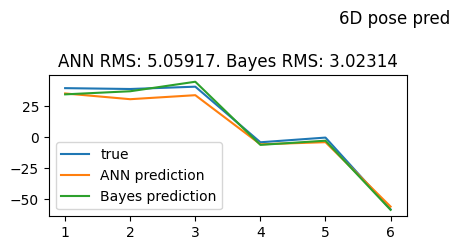


- test run 143.
      True pose:      [35.75043 35.01265 35.55667 -1.81780 0.60398 -55.09072]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 0.0001075 | -0.05911  | -0.002936 | -0.9705   | 36.14     | 34.2      | 37.41     |
| 5         | 0.0001156 | 0.00112   | 0.04498   | -0.9977   | 31.14     | 31.71     | 39.34     |
| 9         | 0.0001172 | -0.05025  | -0.02174  | -1.003    | 37.54     | 32.13     | 33.21     |
| 20        | 0.0001206 | -0.04403  | 0.009082  | -0.99     | 33.69     | 32.18     | 36.85     |
| 23        | 0.0001212 | -0.04787  | 0.02332   | -0.9762   | 33.4      | 30.7      | 38.35     |
| 25        | 0.0001229 | -0.04503  | 0.01096   | -0.9723   | 32.62     | 31.08     | 37.35     |
| 26        | 0.0001242 | -0.0504   | 0.02115   | -0.9617   | 31.63  

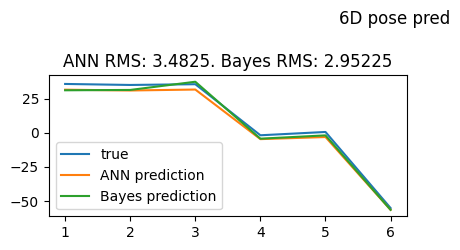


- test run 144.
      True pose:      [42.49765 43.76360 36.65509 0.94518 2.88948 -62.47676]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 6.223e-05 | -0.01088  | 0.03695   | -1.099    | 42.89     | 42.96     | 38.51     |
| 9         | 6.322e-05 | -0.002024 | 0.01814   | -1.132    | 44.29     | 40.88     | 34.31     |
| 25        | 6.536e-05 | -0.01414  | 0.01598   | -1.131    | 43.26     | 42.35     | 35.27     |
| 26        | 6.562e-05 | -0.027    | 0.02896   | -1.123    | 43.41     | 43.31     | 37.09     |
| 30        | 6.594e-05 | -0.01611  | 0.02255   | -1.129    | 43.64     | 44.02     | 38.39     |
| 32        | 6.651e-05 | -0.02089  | 0.02579   | -1.134    | 43.55     | 43.9      | 37.88     |
| 38        | 6.656e-05 | -0.02079  | 0.02947   | -1.133    | 43.05   

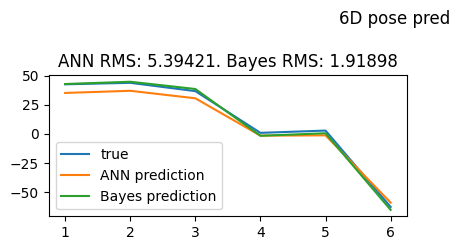


- test run 145.
      True pose:      [36.79112 40.61786 41.41075 4.26505 4.12028 -62.19477]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.669e-05 | 0.04706   | 0.05844   | -1.095    | 37.18     | 39.81     | 43.26     |
| 3         | 5.861e-05 | 0.04865   | 0.1049    | -1.127    | 38.5      | 39.79     | 42.0      |
| 7         | 6.059e-05 | 0.09071   | 0.1011    | -1.128    | 39.29     | 45.51     | 43.89     |
| 29        | 6.175e-05 | 0.1038    | 0.1076    | -1.124    | 38.91     | 44.55     | 44.14     |
| 34        | 6.192e-05 | 0.1091    | 0.106     | -1.123    | 38.17     | 44.28     | 44.19     |
| 35        | 6.221e-05 | 0.1138    | 0.1011    | -1.124    | 38.08     | 43.79     | 44.12     |
| 46        | 6.251e-05 | 0.1133    | 0.1018    | -1.127    | 38.01   

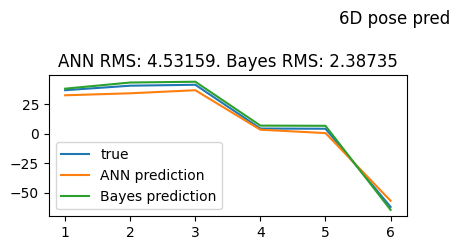


- test run 146.
      True pose:      [37.28873 38.23071 39.79831 -3.68051 -3.97481 -57.15073]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 6.549e-05 | -0.09162  | -0.08285  | -1.006    | 37.68     | 37.42     | 41.65     |
| 5         | 7.04e-05  | -0.03139  | -0.03494  | -1.034    | 32.68     | 34.93     | 43.58     |
| 9         | 7.344e-05 | -0.08276  | -0.1017   | -1.039    | 39.08     | 35.35     | 37.45     |
| 10        | 7.824e-05 | -0.06497  | -0.1083   | -0.991    | 33.76     | 39.12     | 41.8      |
| 21        | 8.069e-05 | -0.03948  | -0.1057   | -1.011    | 33.75     | 39.3      | 42.89     |
| 24        | 8.131e-05 | -0.05563  | -0.09989  | -1.015    | 34.48     | 38.37     | 44.38     |
| 25        | 8.47e-05  | -0.05878  | -0.109    | -1.015    | 35.73 

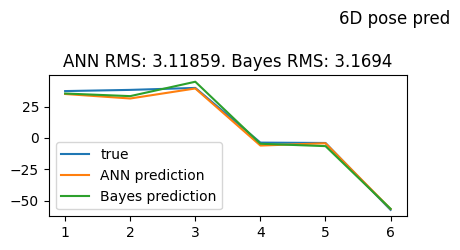


- test run 147.
      True pose:      [42.32687 37.42555 37.40876 1.95515 3.40720 -56.64152]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.807e-05 | 0.006745  | 0.04599   | -0.9976   | 42.72     | 36.62     | 39.26     |
| 10        | 6.064e-05 | 0.03339   | 0.02049   | -0.9821   | 38.79     | 38.32     | 39.41     |
| 30        | 6.284e-05 | 0.02519   | 0.01607   | -0.9859   | 38.68     | 37.87     | 39.88     |
| 31        | 6.404e-05 | 0.02638   | 0.01606   | -0.9923   | 38.85     | 37.2      | 40.48     |
| 32        | 6.405e-05 | 0.02016   | 0.02153   | -0.9891   | 38.37     | 37.33     | 41.25     |
| 33        | 6.478e-05 | 0.01404   | 0.02005   | -0.9835   | 39.05     | 36.85     | 41.67     |
| 34        | 6.501e-05 | 0.01811   | 0.0177    | -0.979    | 38.78   

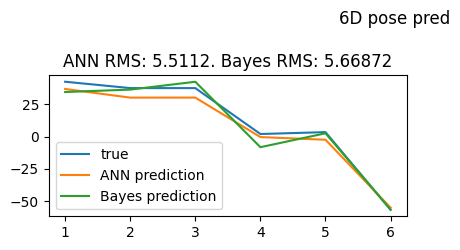


- test run 148.
      True pose:      [36.22945 43.27275 35.39475 1.21639 -4.41975 -63.61881]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 6.159e-05 | -0.006149 | -0.09062  | -1.119    | 36.62     | 42.46     | 37.25     |
| 9         | 6.447e-05 | 0.00271   | -0.1094   | -1.152    | 38.02     | 40.39     | 33.05     |
| 10        | 6.846e-05 | 0.02049   | -0.1161   | -1.104    | 32.7      | 44.17     | 37.39     |
| 20        | 7.474e-05 | 0.01685   | -0.1169   | -1.136    | 33.72     | 43.45     | 37.21     |
| 23        | 8.028e-05 | 0.03686   | -0.1202   | -1.148    | 33.44     | 43.11     | 36.73     |
| 26        | 8.08e-05  | 0.04894   | -0.112    | -1.149    | 33.22     | 42.94     | 36.52     |
| 27        | 8.158e-05 | 0.05992   | -0.1132   | -1.149    | 33.15  

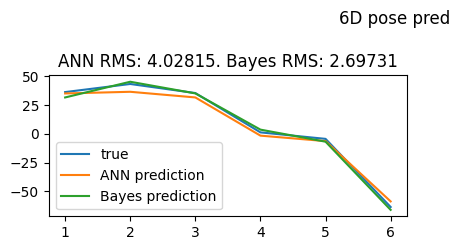


- test run 149.
      True pose:      [39.39254 41.45729 35.87768 2.33944 4.70774 -59.75282]
1/1 [==============================] - 0s 20ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 3         | 5.547e-05 | 0.01504   | 0.1152    | -1.084    | 41.1      | 40.63     | 36.46     |
| 9         | 5.564e-05 | 0.02231   | 0.04988   | -1.085    | 41.18     | 38.57     | 33.53     |
| 22        | 5.646e-05 | 0.02513   | 0.04339   | -1.084    | 41.69     | 39.82     | 36.1      |
| 23        | 5.691e-05 | 0.01343   | 0.04702   | -1.083    | 41.41     | 39.77     | 36.83     |
| 33        | 5.695e-05 | 0.01413   | 0.04201   | -1.085    | 42.35     | 38.89     | 35.94     |
| 36        | 5.704e-05 | 0.01091   | 0.0414    | -1.085    | 42.44     | 39.44     | 35.52     |
| 50        | 5.706e-05 | 0.008956  | 0.04247   | -1.086    | 42.56   

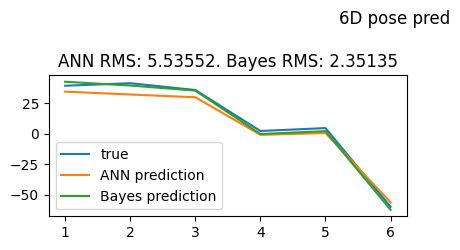


- test run 150.
      True pose:      [38.46524 44.50018 38.64295 4.36734 -3.83748 -56.37479]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 7.779e-05 | 0.04885   | -0.08045  | -0.9929   | 38.85     | 43.69     | 40.5      |
| 10        | 8.683e-05 | 0.07549   | -0.106    | -0.9775   | 34.93     | 45.39     | 40.64     |
| 20        | 8.85e-05  | 0.08239   | -0.09849  | -0.966    | 35.86     | 42.77     | 38.8      |
| 23        | 9.106e-05 | 0.09893   | -0.1034   | -0.9511   | 35.92     | 42.68     | 38.58     |
| 25        | 9.114e-05 | 0.08638   | -0.09724  | -0.9418   | 35.62     | 42.57     | 38.49     |
| 32        | 9.251e-05 | 0.08316   | -0.1043   | -0.9517   | 35.12     | 42.48     | 38.68     |
| 33        | 9.31e-05  | 0.08816   | -0.1007   | -0.9482   | 34.76  

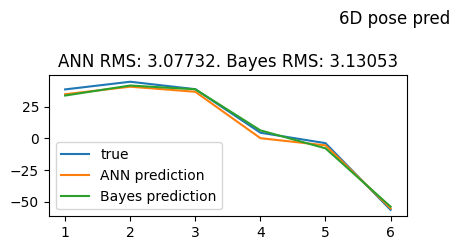


- test run 151.
      True pose:      [35.77186 42.89043 36.31105 4.25125 -2.77252 -61.28732]
1/1 [==============================] - 0s 21ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.308e-05 | 0.04682   | -0.06187  | -1.079    | 36.16     | 42.08     | 38.16     |
| 5         | 5.414e-05 | 0.107     | -0.01395  | -1.106    | 31.16     | 39.59     | 40.09     |
| 6         | 5.857e-05 | 0.03915   | -0.05527  | -1.03     | 36.1      | 44.81     | 34.47     |
| 10        | 6.349e-05 | 0.07346   | -0.08737  | -1.063    | 32.24     | 43.78     | 38.31     |
| 13        | 6.679e-05 | 0.04272   | -0.02156  | -1.079    | 32.43     | 47.17     | 34.79     |
| 26        | 6.919e-05 | 0.05403   | -0.03861  | -1.06     | 32.4      | 46.97     | 34.79     |
| 30        | 7.143e-05 | 0.05265   | -0.04801  | -1.066    | 31.7   

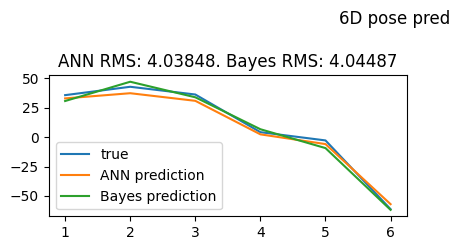


- test run 152.
      True pose:      [41.38712 43.03666 37.73153 -3.52626 1.09061 -56.67493]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 0.0001194 | -0.08892  | 0.005557  | -0.9982   | 41.78     | 42.23     | 39.58     |
| 5         | 0.0001307 | -0.0287   | 0.05347   | -1.025    | 36.78     | 39.73     | 41.51     |
| 9         | 0.0001348 | -0.08006  | -0.01325  | -1.031    | 43.18     | 40.15     | 35.39     |
| 21        | 0.0001392 | -0.05678  | -0.01909  | -1.03     | 43.0      | 39.9      | 36.54     |
| 23        | 0.0001422 | -0.0636   | -0.01226  | -1.017    | 40.34     | 40.45     | 39.32     |
| 26        | 0.0001443 | -0.06755  | -0.01523  | -1.005    | 39.39     | 39.37     | 40.07     |
| 27        | 0.0001469 | -0.08286  | -0.01941  | -1.005    | 38.72  

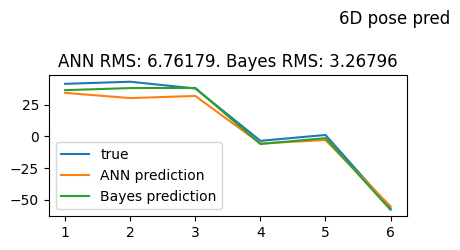


- test run 153.
      True pose:      [38.91114 36.06362 40.02816 3.04898 4.72599 -61.44561]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 3         | 5.57e-05  | 0.02742   | 0.1155    | -1.114    | 40.62     | 35.24     | 40.62     |
| 43        | 5.593e-05 | 0.03402   | 0.1158    | -1.114    | 40.61     | 35.37     | 40.71     |
| 44        | 5.601e-05 | 0.03298   | 0.1121    | -1.114    | 40.3      | 35.68     | 40.95     |
| 46        | 5.602e-05 | 0.03584   | 0.1095    | -1.113    | 40.06     | 35.72     | 41.03     |
| 50        | 5.614e-05 | 0.03592   | 0.1149    | -1.114    | 39.91     | 35.83     | 41.09     |
| 51        | 5.625e-05 | 0.03985   | 0.121     | -1.113    | 39.78     | 35.91     | 41.22     |
| 53        | 5.651e-05 | 0.04545   | 0.1254    | -1.115    | 39.69   

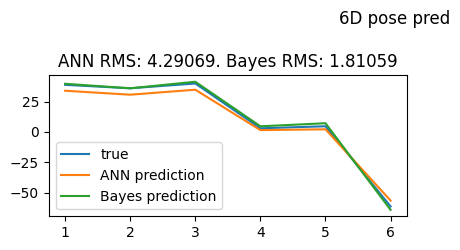


- test run 154.
      True pose:      [42.59504 41.10480 35.83168 4.03143 -1.03889 -64.08126]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 8.313e-05 | 0.04298   | -0.03161  | -1.127    | 42.98     | 40.3      | 37.68     |
| 9         | 8.495e-05 | 0.05184   | -0.05042  | -1.16     | 44.38     | 38.22     | 33.49     |
| 10        | 8.752e-05 | 0.06963   | -0.05711  | -1.112    | 39.06     | 42.0      | 37.83     |
| 19        | 9.368e-05 | 0.07512   | -0.007876 | -1.157    | 38.94     | 41.91     | 37.71     |
| 23        | 9.562e-05 | 0.09021   | -0.01733  | -1.14     | 38.98     | 42.02     | 37.54     |
| 26        | 9.641e-05 | 0.08407   | -0.01882  | -1.145    | 38.86     | 41.8      | 37.76     |
| 27        | 9.862e-05 | 0.08841   | -0.0323   | -1.147    | 38.81  

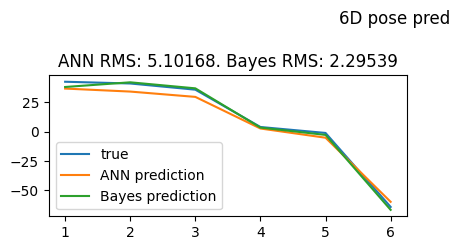


- test run 155.
      True pose:      [43.85096 38.17670 36.16110 1.17862 -0.99796 -58.66595]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 4.424e-05 | -0.006808 | -0.0309   | -1.033    | 44.24     | 37.37     | 38.01     |
| 6         | 4.976e-05 | -0.01448  | -0.0243   | -0.984    | 44.18     | 40.1      | 34.32     |
| 10        | 5.201e-05 | 0.01984   | -0.05639  | -1.017    | 40.32     | 39.07     | 38.16     |
| 24        | 5.374e-05 | 0.02577   | -0.05994  | -1.011    | 39.97     | 39.67     | 37.71     |
| 25        | 5.451e-05 | 0.0249    | -0.05709  | -1.01     | 39.44     | 40.09     | 38.17     |
| 26        | 5.558e-05 | 0.02705   | -0.05454  | -1.002    | 39.33     | 40.84     | 37.43     |
| 27        | 5.601e-05 | 0.03112   | -0.04775  | -1.009    | 38.86  

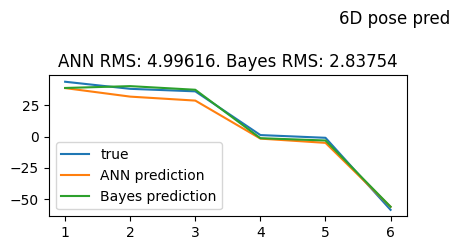


- test run 156.
      True pose:      [41.70653 40.18020 39.59898 -4.25138 -0.73328 -57.34679]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 9.097e-05 | -0.1016   | -0.02628  | -1.01     | 42.09     | 39.37     | 41.45     |
| 5         | 9.834e-05 | -0.04135  | 0.02164   | -1.037    | 37.1      | 36.88     | 43.38     |
| 9         | 0.0001034 | -0.09272  | -0.04508  | -1.043    | 43.49     | 37.3      | 37.25     |
| 20        | 0.0001076 | -0.09433  | -0.02918  | -1.037    | 40.81     | 37.46     | 41.13     |
| 22        | 0.0001113 | -0.08893  | -0.05335  | -1.022    | 40.53     | 36.66     | 42.48     |
| 24        | 0.0001126 | -0.08073  | -0.04367  | -1.02     | 39.66     | 35.51     | 43.54     |
| 25        | 0.0001127 | -0.07029  | -0.05067  | -1.035    | 39.16 

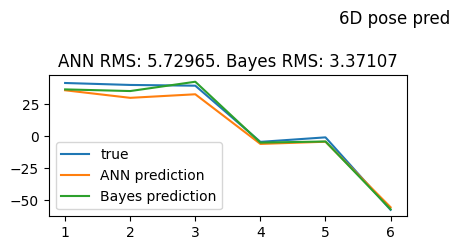


- test run 157.
      True pose:      [35.57255 37.29638 42.52740 -2.20332 4.66843 -63.23585]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 7.696e-05 | -0.06583  | 0.068     | -1.113    | 35.96     | 36.49     | 44.38     |
| 20        | 7.97e-05  | -0.06062  | 0.05824   | -1.13     | 35.72     | 36.66     | 43.91     |
| 25        | 7.974e-05 | -0.06439  | 0.06411   | -1.135    | 34.31     | 34.96     | 44.03     |
| 29        | 8.098e-05 | -0.07647  | 0.07386   | -1.133    | 33.54     | 34.46     | 44.42     |
| 33        | 8.223e-05 | -0.0773   | 0.068     | -1.127    | 33.14     | 34.81     | 45.01     |
| 34        | 8.313e-05 | -0.08091  | 0.06078   | -1.127    | 32.85     | 35.62     | 45.36     |
| 43        | 8.357e-05 | -0.08083  | 0.06607   | -1.134    | 32.78  

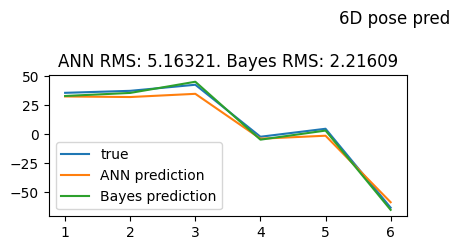


- test run 158.
      True pose:      [44.47919 43.44766 35.68177 -3.48834 0.22895 -55.15948]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 0.0001454 | -0.08826  | -0.009481 | -0.9717   | 44.87     | 42.64     | 37.53     |
| 5         | 0.0001573 | -0.02804  | 0.03843   | -0.9989   | 39.87     | 40.15     | 39.46     |
| 10        | 0.0001587 | -0.06162  | -0.03498  | -0.9562   | 40.95     | 44.34     | 37.68     |
| 20        | 0.0001678 | -0.07205  | -0.01173  | -0.9764   | 41.43     | 42.42     | 38.05     |
| 22        | 0.00017   | -0.08693  | -0.01138  | -0.9788   | 41.46     | 42.33     | 39.55     |
| 23        | 0.0001774 | -0.08566  | -0.01424  | -0.9865   | 39.89     | 42.83     | 39.18     |
| 25        | 0.0001796 | -0.0723   | -0.01519  | -0.9806   | 39.51  

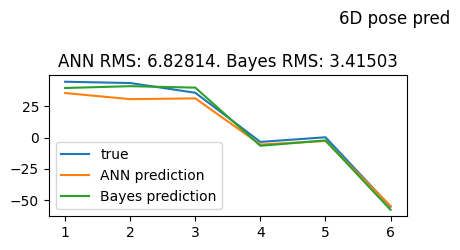


- test run 159.
      True pose:      [44.63752 36.28410 44.16455 -1.48256 -2.84471 -64.15139]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 7.657e-05 | -0.05325  | -0.06313  | -1.129    | 45.03     | 35.48     | 46.02     |
| 10        | 8.974e-05 | -0.02661  | -0.08863  | -1.113    | 41.1      | 37.18     | 46.16     |
| 26        | 9.212e-05 | -0.01044  | -0.08428  | -1.12     | 41.14     | 36.95     | 46.16     |
| 28        | 9.447e-05 | -0.004287 | -0.09306  | -1.133    | 41.2      | 37.11     | 46.31     |
| 44        | 9.447e-05 | -0.004053 | -0.09029  | -1.138    | 41.28     | 37.38     | 46.62     |
| 46        | 9.455e-05 | -0.000656 | -0.09313  | -1.142    | 41.05     | 37.5      | 46.86     |
| 53        | 9.488e-05 | -0.003678 | -0.08917  | -1.146    | 41.16 

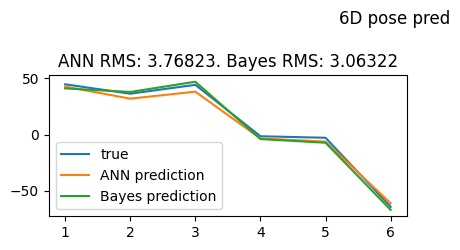


- test run 160.
      True pose:      [37.64654 43.80633 37.62316 -1.21315 3.66972 -57.98915]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 7.499e-05 | -0.04855  | 0.05057   | -1.021    | 38.03     | 43.0      | 39.48     |
| 5         | 7.57e-05  | 0.01167   | 0.09848   | -1.048    | 33.04     | 40.5      | 41.4      |
| 9         | 7.887e-05 | -0.03969  | 0.03176   | -1.054    | 39.43     | 40.92     | 35.28     |
| 20        | 8.157e-05 | -0.01687  | 0.04691   | -1.049    | 35.96     | 40.73     | 39.06     |
| 21        | 8.679e-05 | -0.04375  | 0.02997   | -1.034    | 34.85     | 42.19     | 40.21     |
| 23        | 8.903e-05 | -0.05173  | 0.02943   | -1.056    | 33.68     | 41.89     | 39.21     |
| 28        | 9.004e-05 | -0.05982  | 0.02885   | -1.047    | 33.15  

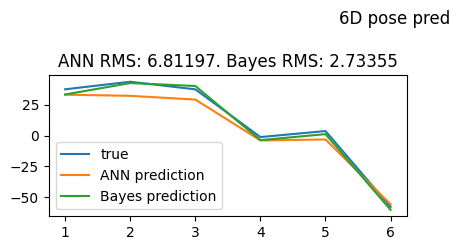


- test run 161.
      True pose:      [44.09520 42.69703 36.04476 -1.60455 -2.37210 -59.16782]
1/1 [==============================] - 0s 20ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 4.352e-05 | -0.05538  | -0.05488  | -1.042    | 44.48     | 41.89     | 37.9      |
| 3         | 4.658e-05 | -0.0538   | -0.008404 | -1.074    | 45.8      | 41.87     | 36.63     |
| 9         | 5.011e-05 | -0.04652  | -0.07369  | -1.075    | 45.88     | 39.81     | 33.7      |
| 29        | 5.019e-05 | -0.03793  | -0.07819  | -1.075    | 46.93     | 40.17     | 32.64     |
| 34        | 5.081e-05 | -0.0324   | -0.07894  | -1.076    | 47.28     | 40.34     | 33.3      |
| 35        | 5.163e-05 | -0.03713  | -0.07495  | -1.075    | 47.88     | 40.3      | 33.53     |
| 43        | 5.213e-05 | -0.0348   | -0.06876  | -1.076    | 48.22 

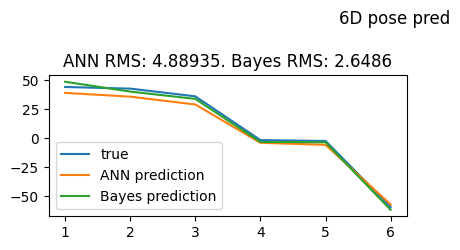


- test run 162.
      True pose:      [40.32586 44.68697 37.31500 -4.14274 0.15642 -55.84915]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 0.0001485 | -0.09968  | -0.01075  | -0.9838   | 40.71     | 43.88     | 39.17     |
| 5         | 0.0001625 | -0.03946  | 0.03717   | -1.011    | 35.72     | 41.39     | 41.1      |
| 21        | 0.000166  | -0.04049  | 0.01639   | -1.015    | 36.75     | 42.8      | 40.2      |
| 22        | 0.0001685 | -0.0382   | 0.003692  | -1.001    | 36.65     | 41.29     | 39.43     |
| 24        | 0.0001688 | -0.05597  | -0.01014  | -0.9831   | 37.36     | 42.44     | 38.2      |
| 26        | 0.0001714 | -0.04283  | -0.02375  | -0.9944   | 38.68     | 41.87     | 37.3      |
| 27        | 0.0001757 | -0.05675  | -0.02657  | -0.9978   | 38.1   

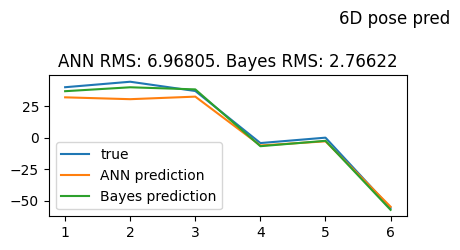


- test run 163.
      True pose:      [43.95923 36.12514 38.95799 0.33980 -3.65902 -61.51388]
1/1 [==============================] - 0s 20ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 4.43e-05  | -0.02145  | -0.07734  | -1.083    | 44.35     | 35.32     | 40.81     |
| 5         | 4.781e-05 | 0.03878   | -0.02943  | -1.11     | 39.35     | 32.82     | 42.74     |
| 9         | 5.341e-05 | -0.01259  | -0.09615  | -1.116    | 45.75     | 33.24     | 36.61     |
| 10        | 5.484e-05 | 0.005195  | -0.1028   | -1.067    | 40.43     | 37.02     | 40.96     |
| 27        | 5.601e-05 | 0.01783   | -0.1034   | -1.068    | 40.24     | 37.2      | 41.2      |
| 28        | 5.764e-05 | 0.02662   | -0.09611  | -1.078    | 40.28     | 36.88     | 41.04     |
| 30        | 5.804e-05 | 0.02241   | -0.1005   | -1.077    | 40.11  

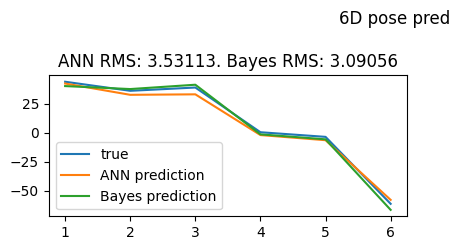


- test run 164.
      True pose:      [37.00933 40.60336 40.68612 -1.32538 -0.77527 -56.93999]
1/1 [==============================] - 0s 20ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 6.107e-05 | -0.05051  | -0.02701  | -1.003    | 37.4      | 39.8      | 42.54     |
| 5         | 6.703e-05 | 0.009714  | 0.0209    | -1.03     | 32.4      | 37.3      | 44.47     |
| 9         | 7.15e-05  | -0.04165  | -0.04582  | -1.036    | 38.8      | 37.72     | 38.34     |
| 23        | 7.276e-05 | -0.05414  | -0.02957  | -1.033    | 38.34     | 36.95     | 41.18     |
| 27        | 7.605e-05 | -0.06388  | -0.03987  | -1.034    | 38.2      | 35.71     | 41.15     |
| 29        | 7.662e-05 | -0.06521  | -0.05067  | -1.028    | 38.59     | 35.61     | 40.79     |
| 34        | 7.744e-05 | -0.06293  | -0.05508  | -1.035    | 38.56 

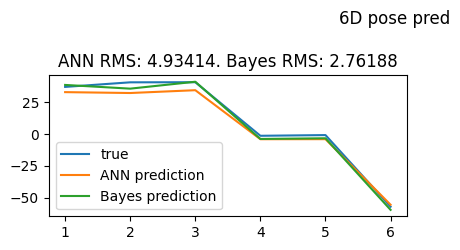


- test run 165.
      True pose:      [41.58417 38.95674 43.39940 -3.04921 -4.14269 -62.52359]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 6.431e-05 | -0.0806   | -0.08578  | -1.1      | 41.97     | 38.15     | 45.25     |
| 5         | 6.843e-05 | -0.02037  | -0.03787  | -1.127    | 36.97     | 35.66     | 47.18     |
| 9         | 6.979e-05 | -0.07174  | -0.1046   | -1.133    | 43.37     | 36.07     | 41.05     |
| 10        | 7.027e-05 | -0.05395  | -0.1113   | -1.085    | 38.05     | 39.85     | 45.4      |
| 20        | 7.328e-05 | -0.0673   | -0.106    | -1.094    | 38.39     | 38.83     | 45.79     |
| 21        | 8.414e-05 | -0.07608  | -0.1043   | -1.122    | 37.64     | 37.61     | 46.22     |
| 22        | 8.665e-05 | -0.08397  | -0.1115   | -1.122    | 36.85 

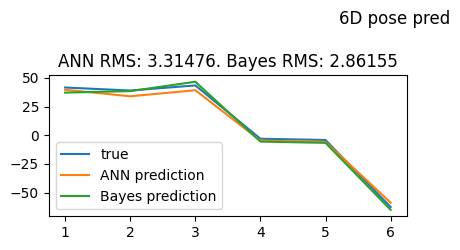


- test run 166.
      True pose:      [40.41256 42.50647 36.90201 -3.39233 -4.38068 -64.86820]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 6.934e-05 | -0.08659  | -0.08993  | -1.141    | 40.8      | 41.7      | 38.75     |
| 10        | 8.998e-05 | -0.05994  | -0.1154   | -1.126    | 36.88     | 43.4      | 38.9      |
| 24        | 9.21e-05  | -0.04411  | -0.1102   | -1.132    | 36.19     | 44.17     | 38.34     |
| 27        | 9.344e-05 | -0.05692  | -0.1084   | -1.136    | 35.95     | 44.6      | 38.7      |
| 29        | 9.583e-05 | -0.05578  | -0.1045   | -1.141    | 35.45     | 44.61     | 39.04     |
| 30        | 9.808e-05 | -0.04539  | -0.1148   | -1.141    | 35.46     | 44.85     | 39.49     |
| 32        | 9.889e-05 | -0.04237  | -0.1179   | -1.141    | 35.42 

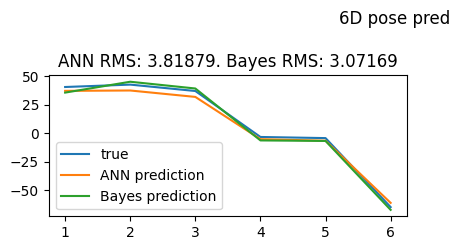


- test run 167.
      True pose:      [35.66217 38.76909 39.57282 -0.47604 -4.10337 -58.36517]
1/1 [==============================] - 0s 23ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 4.245e-05 | -0.03569  | -0.08509  | -1.028    | 36.05     | 37.96     | 41.43     |
| 3         | 4.612e-05 | -0.0341   | -0.03862  | -1.06     | 37.37     | 37.94     | 40.16     |
| 9         | 4.89e-05  | -0.02683  | -0.1039   | -1.061    | 37.45     | 35.89     | 37.23     |
| 10        | 5.154e-05 | -0.009044 | -0.1106   | -1.012    | 32.13     | 39.66     | 41.57     |
| 26        | 5.289e-05 | 0.006663  | -0.1152   | -1.004    | 32.96     | 38.22     | 41.49     |
| 27        | 5.334e-05 | 0.0167    | -0.1126   | -0.9877   | 33.07     | 37.69     | 41.58     |
| 31        | 5.394e-05 | 0.01928   | -0.1129   | -0.9909   | 33.06 

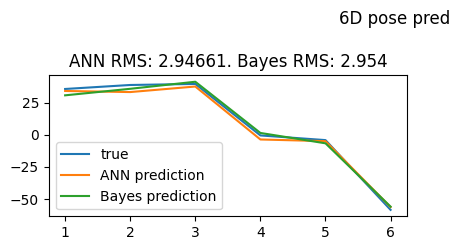


- test run 168.
      True pose:      [40.32428 40.86188 39.12227 1.45082 1.50654 -56.71062]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.866e-05 | -0.002057 | 0.01282   | -0.9988   | 40.71     | 40.05     | 40.97     |
| 10        | 6.339e-05 | 0.02459   | -0.01268  | -0.9833   | 36.79     | 41.75     | 41.12     |
| 21        | 6.411e-05 | 0.0001805 | 5.615e-05 | -0.9609   | 37.44     | 40.87     | 40.55     |
| 24        | 6.445e-05 | 0.01458   | -0.0131   | -0.9518   | 38.26     | 39.79     | 41.06     |
| 25        | 6.468e-05 | 0.01499   | -0.01669  | -0.9566   | 37.82     | 40.61     | 42.16     |
| 29        | 6.506e-05 | 0.01046   | -0.01369  | -0.9469   | 37.82     | 41.44     | 42.53     |
| 33        | 6.547e-05 | 0.002379  | -0.01703  | -0.9524   | 38.02   

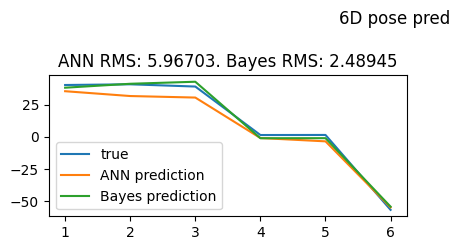


- test run 169.
      True pose:      [38.26473 40.82255 36.26203 -2.23604 -4.03712 -57.08577]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.9e-05   | -0.06641  | -0.08394  | -1.005    | 38.65     | 40.01     | 38.11     |
| 5         | 6.449e-05 | -0.00618  | -0.03603  | -1.033    | 33.66     | 37.52     | 40.04     |
| 9         | 6.628e-05 | -0.05755  | -0.1027   | -1.038    | 40.05     | 37.94     | 33.92     |
| 10        | 6.929e-05 | -0.03976  | -0.1094   | -0.9899   | 34.73     | 41.72     | 38.26     |
| 23        | 6.958e-05 | -0.0303   | -0.1106   | -1.001    | 35.72     | 41.77     | 38.87     |
| 25        | 7.5e-05   | -0.0182   | -0.1122   | -1.02     | 35.87     | 39.41     | 40.84     |
| 29        | 7.503e-05 | -0.0249   | -0.1107   | -1.03     | 35.39 

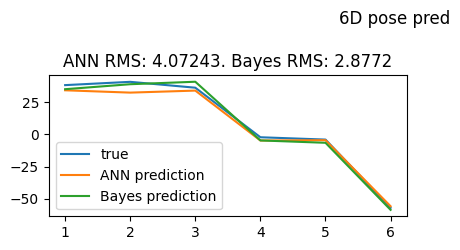


- test run 170.
      True pose:      [44.22474 38.89981 37.59761 0.83327 -2.27927 -58.29730]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 4.547e-05 | -0.01284  | -0.05326  | -1.026    | 44.61     | 38.09     | 39.45     |
| 3         | 4.698e-05 | -0.01125  | -0.006784 | -1.059    | 45.93     | 38.07     | 38.18     |
| 9         | 5.053e-05 | -0.003977 | -0.07207  | -1.059    | 46.01     | 36.02     | 35.25     |
| 10        | 5.406e-05 | 0.01381   | -0.07876  | -1.011    | 40.69     | 39.79     | 39.6      |
| 21        | 5.492e-05 | 0.01823   | -0.07317  | -0.9838   | 40.84     | 39.98     | 39.65     |
| 25        | 5.522e-05 | 0.01676   | -0.07296  | -0.985    | 40.59     | 39.91     | 39.79     |
| 31        | 5.545e-05 | 0.02401   | -0.07344  | -0.9755   | 40.37  

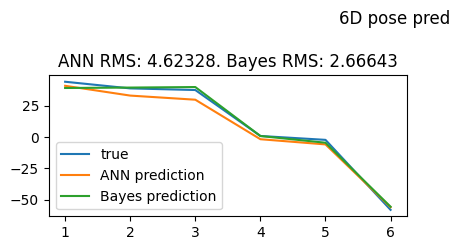


- test run 171.
      True pose:      [43.69613 35.60718 37.70467 -4.44747 2.72236 -64.72828]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 0.0001111 | -0.105    | 0.03404   | -1.139    | 44.08     | 34.8      | 39.56     |
| 22        | 0.0001126 | -0.09025  | 0.03519   | -1.151    | 44.12     | 35.27     | 39.19     |
| 26        | 0.0001149 | -0.1053   | 0.01717   | -1.16     | 44.09     | 35.09     | 39.26     |
| 33        | 0.000115  | -0.1085   | 0.02149   | -1.16     | 44.29     | 35.03     | 39.44     |
| 36        | 0.0001166 | -0.1144   | 0.02867   | -1.161    | 43.76     | 34.73     | 38.89     |
| 43        | 0.0001172 | -0.115    | 0.02347   | -1.164    | 43.71     | 35.01     | 38.91     |
| 44        | 0.0001173 | -0.1202   | 0.01794   | -1.17     | 43.87  

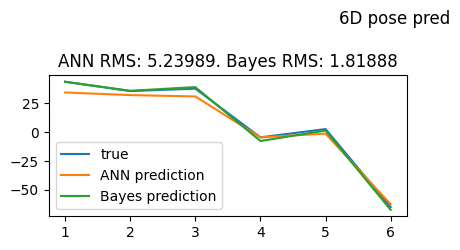


- test run 172.
      True pose:      [43.15838 43.30286 43.19266 -2.38758 4.06004 -55.69941]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 5         | 0.0001268 | -0.008825 | 0.1053    | -1.008    | 38.55     | 40.0      | 46.97     |
| 9         | 0.0001285 | -0.06019  | 0.03857   | -1.014    | 44.95     | 40.42     | 40.85     |
| 20        | 0.0001349 | -0.03737  | 0.05373   | -1.009    | 41.47     | 40.22     | 44.63     |
| 22        | 0.0001366 | -0.05081  | 0.07762   | -1.003    | 39.8      | 39.78     | 44.7      |
| 24        | 0.0001396 | -0.05479  | 0.07174   | -1.008    | 38.37     | 41.46     | 44.37     |
| 25        | 0.0001437 | -0.06499  | 0.06118   | -0.993    | 38.23     | 40.56     | 42.73     |
| 26        | 0.0001467 | -0.058    | 0.04958   | -1.0      | 38.18  

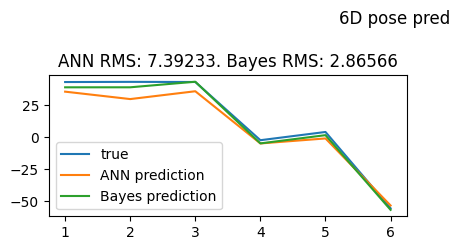


- test run 173.
      True pose:      [39.28902 43.92241 40.75258 -2.40621 -0.10944 -64.95236]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 9.501e-05 | -0.06938  | -0.01539  | -1.143    | 39.68     | 43.11     | 42.6      |
| 10        | 0.0001024 | -0.04273  | -0.04089  | -1.127    | 35.76     | 44.82     | 42.75     |
| 20        | 0.0001043 | -0.04905  | -0.01232  | -1.149    | 35.91     | 43.78     | 42.74     |
| 22        | 0.0001047 | -0.03961  | -0.01765  | -1.161    | 35.38     | 43.97     | 41.74     |
| 23        | 0.0001047 | -0.03878  | -0.008288 | -1.146    | 34.49     | 43.89     | 42.41     |
| 27        | 0.0001067 | -0.03422  | -0.01252  | -1.155    | 34.31     | 44.3      | 43.33     |
| 30        | 0.000108  | -0.04369  | -0.0171   | -1.145    | 34.29 

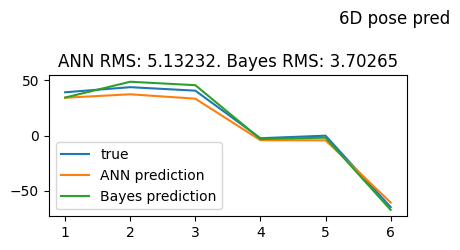


- test run 174.
      True pose:      [40.89606 38.64981 35.44004 4.82699 4.33927 -60.75632]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 7         | 5.747e-05 | 0.1005    | 0.1049    | -1.102    | 43.4      | 43.54     | 37.92     |
| 17        | 5.888e-05 | 0.1194    | 0.08216   | -1.104    | 42.07     | 36.92     | 35.71     |
| 21        | 5.897e-05 | 0.1129    | 0.09337   | -1.085    | 41.35     | 36.86     | 35.35     |
| 28        | 6.023e-05 | 0.1228    | 0.1056    | -1.091    | 41.16     | 36.73     | 34.97     |
| 34        | 6.035e-05 | 0.1234    | 0.1006    | -1.096    | 41.02     | 36.37     | 34.75     |
| 40        | 6.055e-05 | 0.1191    | 0.1047    | -1.103    | 40.97     | 36.8      | 34.85     |
| 41        | 6.079e-05 | 0.1234    | 0.1104    | -1.101    | 40.64   

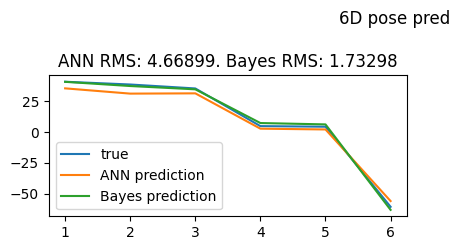


- test run 175.
      True pose:      [44.18213 35.68009 40.26607 -4.32089 2.89363 -64.91919]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 0.0001105 | -0.1028   | 0.03703   | -1.142    | 44.57     | 34.87     | 42.12     |
| 20        | 0.0001129 | -0.08581  | 0.02427   | -1.166    | 44.5      | 34.34     | 42.47     |
| 21        | 0.0001162 | -0.106    | 0.01936   | -1.163    | 43.75     | 33.67     | 41.99     |
| 25        | 0.0001176 | -0.1156   | 0.01375   | -1.16     | 43.1      | 33.64     | 41.9      |
| 26        | 0.0001247 | -0.119    | 0.02822   | -1.159    | 41.06     | 35.69     | 40.51     |
| 27        | 0.0001254 | -0.1166   | 0.03203   | -1.161    | 40.23     | 35.62     | 40.02     |
| 28        | 0.0001257 | -0.1157   | 0.02527   | -1.16     | 40.79  

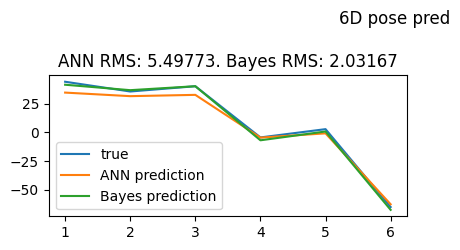


- test run 176.
      True pose:      [37.69364 41.06050 43.86776 1.99654 0.28879 -62.67600]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 6.723e-05 | 0.007467  | -0.008437 | -1.103    | 38.08     | 40.25     | 45.72     |
| 9         | 6.867e-05 | 0.01633   | -0.02725  | -1.136    | 39.48     | 38.18     | 41.52     |
| 10        | 6.938e-05 | 0.03411   | -0.03394  | -1.087    | 34.16     | 41.95     | 45.87     |
| 22        | 6.952e-05 | 0.05766   | -0.03481  | -1.094    | 34.13     | 41.62     | 45.61     |
| 23        | 7.203e-05 | 0.05426   | -0.03629  | -1.116    | 35.49     | 40.5      | 45.13     |
| 24        | 7.294e-05 | 0.03332   | -0.0253   | -1.113    | 35.92     | 41.49     | 44.71     |
| 26        | 7.406e-05 | 0.02561   | -0.01666  | -1.125    | 36.19   

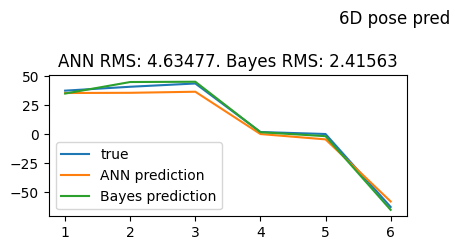


- test run 177.
      True pose:      [36.83179 41.00871 38.79509 2.59254 4.64796 -61.73655]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.392e-05 | 0.01787   | 0.06764   | -1.087    | 37.22     | 40.2      | 40.65     |
| 3         | 5.411e-05 | 0.01946   | 0.1141    | -1.119    | 38.54     | 40.18     | 39.38     |
| 7         | 5.426e-05 | 0.06152   | 0.1103    | -1.12     | 39.33     | 45.9      | 41.28     |
| 9         | 5.456e-05 | 0.02673   | 0.04884   | -1.119    | 38.62     | 38.12     | 36.45     |
| 22        | 5.521e-05 | 0.01937   | 0.03868   | -1.103    | 37.51     | 40.32     | 39.56     |
| 26        | 5.626e-05 | 0.01648   | 0.05441   | -1.115    | 37.7      | 41.32     | 40.78     |
| 29        | 5.635e-05 | 0.005943  | 0.06283   | -1.114    | 37.84   

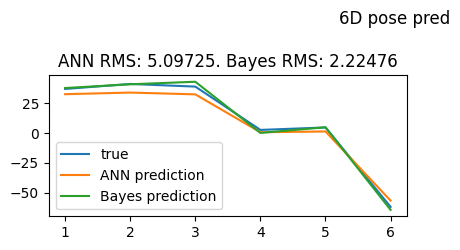


- test run 178.
      True pose:      [38.93985 42.74133 37.47262 -3.77967 3.11979 -55.91209]
1/1 [==============================] - 0s 20ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 5         | 0.0001664 | -0.03312  | 0.08889   | -1.012    | 34.33     | 39.44     | 41.25     |
| 9         | 0.0001738 | -0.08449  | 0.02216   | -1.018    | 40.73     | 39.86     | 35.13     |
| 20        | 0.0001786 | -0.07827  | 0.05299   | -1.004    | 36.88     | 39.9      | 38.77     |
| 21        | 0.0001806 | -0.08044  | 0.04936   | -0.9835   | 35.6      | 38.99     | 38.79     |
| 23        | 0.0001866 | -0.09744  | 0.04778   | -1.001    | 35.72     | 39.31     | 36.97     |
| 24        | 0.0001885 | -0.09052  | 0.04535   | -1.005    | 34.12     | 38.56     | 36.34     |
| 33        | 0.0001906 | -0.09616  | 0.03948   | -1.003    | 34.44  

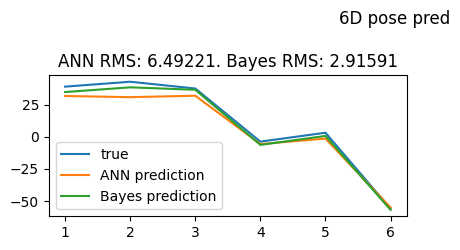


- test run 179.
      True pose:      [35.25769 39.43045 35.97546 1.51573 0.26040 -60.63145]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 4.864e-05 | -0.000924 | -0.008933 | -1.067    | 35.65     | 38.62     | 37.83     |
| 3         | 4.886e-05 | 0.0006631 | 0.03754   | -1.099    | 36.96     | 38.6      | 36.56     |
| 5         | 4.917e-05 | 0.0593    | 0.03898   | -1.094    | 30.65     | 36.13     | 39.76     |
| 6         | 5.099e-05 | -0.008596 | -0.00234  | -1.018    | 35.59     | 41.35     | 34.13     |
| 9         | 5.18e-05  | 0.007934  | -0.02774  | -1.1      | 37.05     | 36.55     | 33.63     |
| 13        | 5.271e-05 | -0.005025 | 0.03137   | -1.067    | 31.91     | 43.71     | 34.45     |
| 21        | 5.334e-05 | -0.01097  | 0.006983  | -1.055    | 32.68   

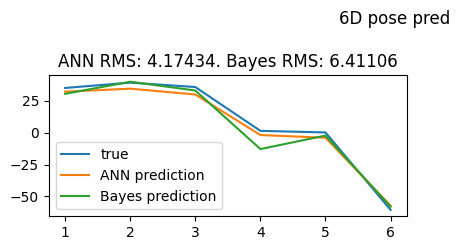


- test run 180.
      True pose:      [38.93574 40.75472 41.60015 0.65790 4.24466 -59.42389]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.626e-05 | -0.0159   | 0.06061   | -1.046    | 39.32     | 39.95     | 43.45     |
| 3         | 5.684e-05 | -0.01431  | 0.1071    | -1.078    | 40.64     | 39.93     | 42.19     |
| 5         | 5.708e-05 | 0.04433   | 0.1085    | -1.073    | 34.33     | 37.45     | 45.38     |
| 9         | 6.012e-05 | -0.007038 | 0.0418    | -1.079    | 40.72     | 37.87     | 39.26     |
| 21        | 6.227e-05 | -0.02161  | 0.06511   | -1.08     | 39.55     | 38.48     | 42.52     |
| 29        | 6.334e-05 | -0.02243  | 0.0582    | -1.08     | 38.39     | 37.4      | 43.9      |
| 36        | 6.335e-05 | -0.02819  | 0.06377   | -1.077    | 38.27   

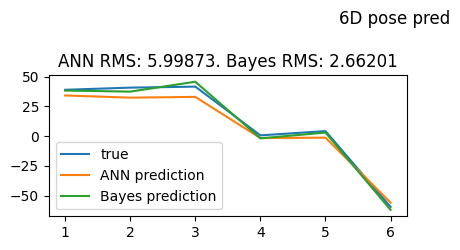


- test run 181.
      True pose:      [35.80539 38.76081 42.27673 1.57757 -0.64640 -60.39008]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 4.831e-05 | 0.0001548 | -0.02476  | -1.063    | 36.19     | 37.95     | 44.13     |
| 6         | 5.154e-05 | -0.007517 | -0.01817  | -1.014    | 36.14     | 40.68     | 40.43     |
| 10        | 5.582e-05 | 0.0268    | -0.05026  | -1.048    | 32.27     | 39.65     | 44.27     |
| 24        | 5.697e-05 | 0.02825   | -0.03266  | -1.041    | 31.86     | 40.53     | 44.12     |
| 26        | 5.702e-05 | 0.01255   | -0.04353  | -1.056    | 33.21     | 40.73     | 42.05     |
| 28        | 5.971e-05 | 0.01375   | -0.04468  | -1.062    | 31.83     | 41.34     | 42.0      |
| 29        | 6.034e-05 | 0.02319   | -0.05058  | -1.064    | 31.5   

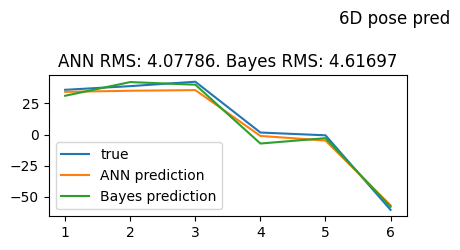


- test run 182.
      True pose:      [42.41074 36.92371 38.13738 1.47646 -2.91109 -61.80873]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.323e-05 | -0.00161  | -0.06429  | -1.088    | 42.8      | 36.12     | 39.99     |
| 9         | 5.922e-05 | 0.007249  | -0.08309  | -1.121    | 44.2      | 34.04     | 35.79     |
| 10        | 6.194e-05 | 0.02503   | -0.08978  | -1.072    | 38.88     | 37.82     | 40.13     |
| 22        | 6.484e-05 | 0.01633   | -0.08191  | -1.096    | 38.81     | 37.24     | 39.58     |
| 25        | 6.746e-05 | 0.02379   | -0.07341  | -1.114    | 37.95     | 37.31     | 39.4      |
| 28        | 6.764e-05 | 0.01608   | -0.06733  | -1.104    | 37.41     | 37.7      | 39.2      |
| 29        | 6.886e-05 | 0.008986  | -0.05694  | -1.108    | 37.45  

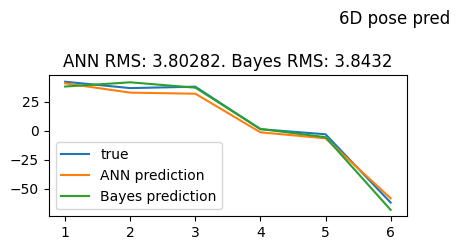


- test run 183.
      True pose:      [35.21672 41.93587 41.32353 4.12998 2.64473 -57.05275]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.601e-05 | 0.0447    | 0.03268   | -1.005    | 35.6      | 41.13     | 43.18     |
| 6         | 5.773e-05 | 0.03703   | 0.03927   | -0.9558   | 35.55     | 43.85     | 39.48     |
| 10        | 5.828e-05 | 0.07135   | 0.007183  | -0.9893   | 31.68     | 42.83     | 43.32     |
| 11        | 5.853e-05 | 0.03738   | 0.03866   | -0.9788   | 34.36     | 37.44     | 41.68     |
| 20        | 5.897e-05 | 0.05387   | 0.02596   | -0.9727   | 33.94     | 37.68     | 40.09     |
| 25        | 5.942e-05 | 0.043     | 0.01748   | -0.9866   | 32.91     | 39.36     | 41.04     |
| 27        | 6.103e-05 | 0.02969   | 0.02496   | -0.9751   | 32.16   

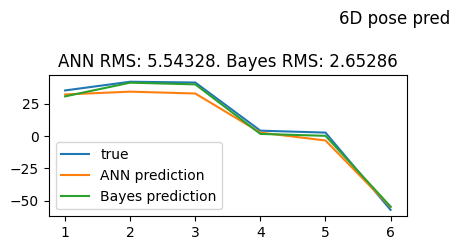


- test run 184.
      True pose:      [44.83471 37.57129 39.17257 2.39009 -2.62669 -61.10297]
1/1 [==============================] - 0s 20ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.031e-05 | 0.01434   | -0.05932  | -1.075    | 45.22     | 36.76     | 41.02     |
| 6         | 5.136e-05 | 0.006664  | -0.05273  | -1.026    | 45.17     | 39.49     | 37.33     |
| 9         | 5.42e-05  | 0.02319   | -0.07813  | -1.108    | 46.62     | 34.69     | 36.83     |
| 10        | 5.895e-05 | 0.04098   | -0.08482  | -1.06     | 41.3      | 38.46     | 41.17     |
| 25        | 6.379e-05 | 0.02465   | -0.07698  | -1.072    | 40.37     | 39.17     | 40.45     |
| 26        | 6.626e-05 | 0.04207   | -0.07835  | -1.066    | 39.89     | 39.86     | 39.81     |
| 28        | 6.72e-05  | 0.03958   | -0.06877  | -1.068    | 39.84  

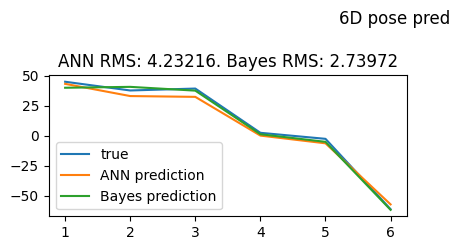


- test run 185.
      True pose:      [39.73974 44.68652 43.62293 -4.52679 3.24684 -63.32486]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 0.0001077 | -0.1064   | 0.04319   | -1.114    | 40.13     | 43.88     | 45.48     |
| 9         | 0.0001109 | -0.09753  | 0.02438   | -1.147    | 41.53     | 41.8      | 41.28     |
| 21        | 0.0001161 | -0.1146   | 0.0366    | -1.142    | 39.45     | 43.05     | 44.77     |
| 29        | 0.0001171 | -0.1051   | 0.02747   | -1.143    | 39.61     | 42.95     | 44.4      |
| 35        | 0.0001175 | -0.1115   | 0.02406   | -1.144    | 39.71     | 43.24     | 44.62     |
| 37        | 0.0001179 | -0.1128   | 0.02265   | -1.146    | 39.59     | 43.84     | 44.86     |
| 39        | 0.000118  | -0.1185   | 0.02026   | -1.146    | 39.7   

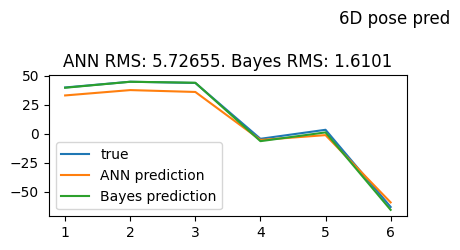


- test run 186.
      True pose:      [42.01246 44.71551 37.81238 -2.12970 -4.59807 -57.73077]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.236e-05 | -0.06455  | -0.09373  | -1.017    | 42.4      | 43.91     | 39.66     |
| 5         | 5.566e-05 | -0.004324 | -0.04582  | -1.044    | 37.4      | 41.41     | 41.59     |
| 9         | 5.98e-05  | -0.05569  | -0.1125   | -1.05     | 43.8      | 41.83     | 35.47     |
| 10        | 6.167e-05 | -0.03791  | -0.1192   | -1.001    | 38.48     | 45.61     | 39.81     |
| 20        | 6.414e-05 | -0.01091  | -0.1192   | -0.9835   | 38.12     | 44.29     | 40.38     |
| 22        | 6.578e-05 | -0.01243  | -0.1232   | -1.003    | 37.1      | 44.72     | 39.81     |
| 34        | 6.627e-05 | -0.01076  | -0.1236   | -0.9995   | 37.04 

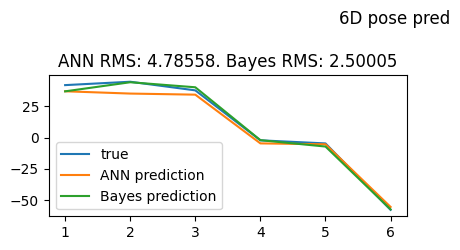


- test run 187.
      True pose:      [37.10543 39.93637 35.74117 3.47582 -1.69807 -62.68162]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 6.793e-05 | 0.03329   | -0.04311  | -1.103    | 37.49     | 39.13     | 37.59     |
| 6         | 6.806e-05 | 0.02561   | -0.03652  | -1.054    | 37.44     | 41.86     | 33.9      |
| 8         | 6.9e-05   | 0.0415    | -0.004393 | -1.129    | 36.58     | 44.02     | 33.68     |
| 9         | 7.475e-05 | 0.04214   | -0.06192  | -1.136    | 38.89     | 37.05     | 33.4      |
| 13        | 7.688e-05 | 0.02919   | -0.002812 | -1.103    | 33.76     | 44.21     | 34.22     |
| 25        | 7.727e-05 | 0.01845   | -0.002683 | -1.116    | 33.88     | 44.13     | 34.33     |
| 26        | 7.79e-05  | 0.02944   | -0.01038  | -1.13     | 34.02  

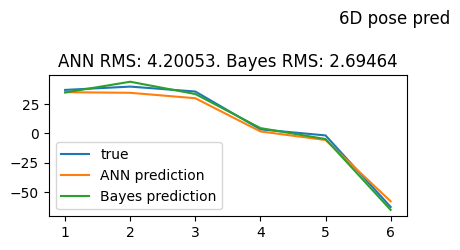


- test run 188.
      True pose:      [44.11801 37.00667 36.61737 4.56218 -2.38641 -56.11307]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 7.066e-05 | 0.05225   | -0.05513  | -0.9884   | 44.51     | 36.2      | 38.47     |
| 9         | 7.134e-05 | 0.0611    | -0.07394  | -1.021    | 45.91     | 34.12     | 34.27     |
| 10        | 7.958e-05 | 0.07889   | -0.08063  | -0.9729   | 40.59     | 37.9      | 38.61     |
| 25        | 7.967e-05 | 0.07636   | -0.06509  | -0.966    | 40.06     | 38.46     | 38.26     |
| 28        | 8.347e-05 | 0.07912   | -0.07515  | -0.9696   | 39.14     | 38.08     | 37.75     |
| 31        | 8.414e-05 | 0.07171   | -0.07778  | -0.9628   | 39.19     | 37.85     | 37.86     |
| 34        | 8.482e-05 | 0.07384   | -0.08077  | -0.9601   | 39.25  

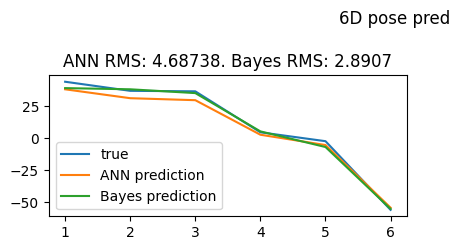


- test run 189.
      True pose:      [35.13740 38.24147 41.03247 4.43081 -3.35876 -56.58476]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 7.503e-05 | 0.04995   | -0.0721   | -0.9966   | 35.53     | 37.43     | 42.88     |
| 10        | 8.609e-05 | 0.0766    | -0.0976   | -0.9811   | 31.6      | 39.13     | 43.03     |
| 20        | 8.621e-05 | 0.0835    | -0.09014  | -0.9697   | 32.53     | 36.51     | 41.19     |
| 23        | 8.897e-05 | 0.08903   | -0.1016   | -0.9867   | 31.58     | 36.73     | 41.6      |
| 24        | 8.939e-05 | 0.1002    | -0.09793  | -0.9915   | 30.48     | 37.95     | 41.72     |
| 31        | 9.037e-05 | 0.09352   | -0.09841  | -0.9825   | 30.83     | 37.75     | 42.12     |
| 33        | 9.101e-05 | 0.09413   | -0.1022   | -0.9744   | 31.35  

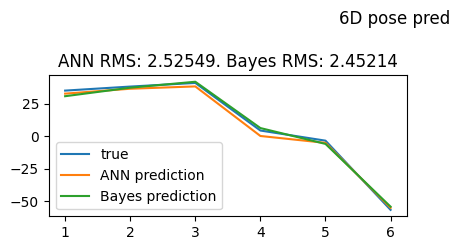


- test run 190.
      True pose:      [44.50759 42.14886 42.50672 -3.65757 -2.67421 -55.02465]
1/1 [==============================] - 0s 20ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 0.0001061 | -0.09122  | -0.06015  | -0.9694   | 44.9      | 41.34     | 44.36     |
| 5         | 0.0001129 | -0.03099  | -0.01224  | -0.9966   | 39.9      | 38.85     | 46.29     |
| 10        | 0.0001281 | -0.06457  | -0.08565  | -0.9539   | 40.97     | 43.04     | 44.5      |
| 21        | 0.0001283 | -0.04038  | -0.08619  | -0.9293   | 40.29     | 41.87     | 43.91     |
| 22        | 0.0001291 | -0.04563  | -0.07238  | -0.928    | 43.39     | 39.04     | 46.64     |
| 24        | 0.0001412 | -0.03658  | -0.08393  | -0.917    | 42.98     | 37.86     | 47.5      |
| 25        | 0.0001467 | -0.02089  | -0.08579  | -0.9172   | 42.79 

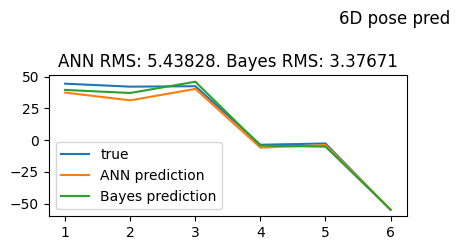


- test run 191.
      True pose:      [39.60010 40.33099 36.64031 3.84566 -3.80900 -57.17701]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 6.617e-05 | 0.03974   | -0.07996  | -1.007    | 39.99     | 39.52     | 38.49     |
| 9         | 6.688e-05 | 0.0486    | -0.09877  | -1.04     | 41.39     | 37.45     | 34.3      |
| 10        | 7.215e-05 | 0.06638   | -0.1055   | -0.9915   | 36.07     | 41.22     | 38.64     |
| 20        | 7.296e-05 | 0.09798   | -0.08198  | -0.9665   | 36.68     | 41.34     | 38.47     |
| 24        | 7.509e-05 | 0.1089    | -0.09051  | -0.9564   | 36.54     | 41.41     | 37.93     |
| 28        | 7.945e-05 | 0.1092    | -0.09734  | -0.9598   | 34.97     | 40.55     | 37.21     |
| 29        | 7.95e-05  | 0.09941   | -0.09987  | -0.9694   | 34.6   

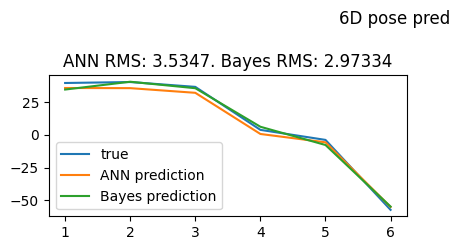


- test run 192.
      True pose:      [44.09036 43.48406 38.60155 -2.77081 0.06120 -57.09170]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 8.556e-05 | -0.07574  | -0.01241  | -1.005    | 44.48     | 42.68     | 40.45     |
| 5         | 8.89e-05  | -0.01551  | 0.0355    | -1.033    | 39.48     | 40.18     | 42.38     |
| 9         | 9.608e-05 | -0.06688  | -0.03122  | -1.038    | 45.88     | 40.6      | 36.26     |
| 23        | 0.0001007 | -0.05696  | -0.02301  | -1.024    | 46.05     | 38.68     | 38.91     |
| 25        | 0.0001053 | -0.07267  | -0.03555  | -1.034    | 46.73     | 38.49     | 38.18     |
| 28        | 0.0001062 | -0.07126  | -0.03927  | -1.026    | 46.9      | 38.5      | 38.82     |
| 29        | 0.0001079 | -0.06889  | -0.03472  | -1.033    | 46.9   

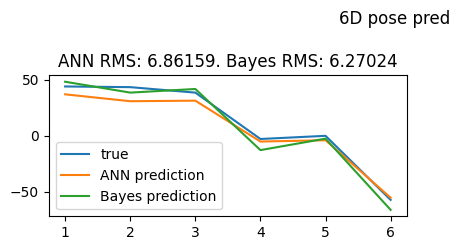


- test run 193.
      True pose:      [36.83008 38.44746 38.15245 -1.54150 -3.22058 -62.58855]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 5         | 6.473e-05 | 0.005942  | -0.02177  | -1.129    | 32.22     | 35.15     | 41.93     |
| 20        | 6.622e-05 | 0.006587  | -0.01726  | -1.12     | 32.3      | 35.93     | 41.6      |
| 21        | 6.675e-05 | -0.0143   | -0.04349  | -1.116    | 33.08     | 36.15     | 42.14     |
| 23        | 6.989e-05 | -0.02651  | -0.02928  | -1.128    | 32.19     | 36.37     | 42.74     |
| 27        | 7.03e-05  | -0.0322   | -0.02149  | -1.127    | 32.23     | 36.8      | 42.56     |
| 29        | 7.159e-05 | -0.03425  | -0.02884  | -1.131    | 31.85     | 36.75     | 42.39     |
| 30        | 7.341e-05 | -0.04301  | -0.02913  | -1.134    | 31.84 

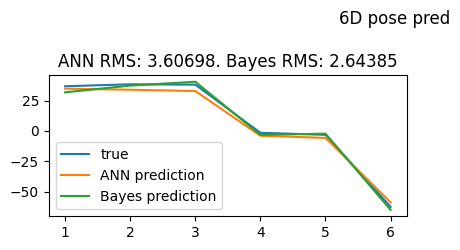


- test run 194.
      True pose:      [35.96676 40.85698 39.91132 -0.71317 3.29958 -55.39106]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 9.689e-05 | -0.03983  | 0.04411   | -0.9758   | 36.35     | 40.05     | 41.76     |
| 5         | 0.0001061 | 0.0204    | 0.09202   | -1.003    | 31.36     | 37.56     | 43.69     |
| 21        | 0.0001115 | -0.008368 | 0.06235   | -1.004    | 31.06     | 40.02     | 43.53     |
| 24        | 0.0001166 | -0.005683 | 0.04967   | -1.002    | 30.97     | 39.08     | 44.59     |
| 25        | 0.0001171 | 0.01245   | 0.03946   | -0.996    | 30.97     | 38.37     | 44.77     |
| 26        | 0.0001199 | 0.01546   | 0.02449   | -0.9797   | 31.0      | 38.82     | 44.89     |
| 29        | 0.0001219 | 0.007472  | 0.02073   | -0.9722   | 32.31  

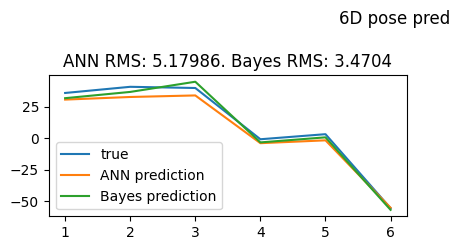


- test run 195.
      True pose:      [40.88225 40.63834 44.58785 -1.61653 -2.07626 -59.45518]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 5         | 4.721e-05 | 0.004632  | -0.001802 | -1.074    | 36.27     | 37.34     | 48.37     |
| 10        | 5.516e-05 | -0.02895  | -0.07521  | -1.031    | 37.35     | 41.53     | 46.59     |
| 25        | 5.593e-05 | -0.04496  | -0.07478  | -1.032    | 37.24     | 41.5      | 46.49     |
| 31        | 5.603e-05 | -0.05397  | -0.07093  | -1.033    | 36.96     | 40.96     | 46.73     |
| 32        | 5.684e-05 | -0.05402  | -0.07495  | -1.031    | 37.03     | 40.95     | 46.62     |
| 38        | 5.713e-05 | -0.04991  | -0.0796   | -1.025    | 37.31     | 40.37     | 46.96     |
| 40        | 5.742e-05 | -0.05717  | -0.07658  | -1.023    | 36.87 

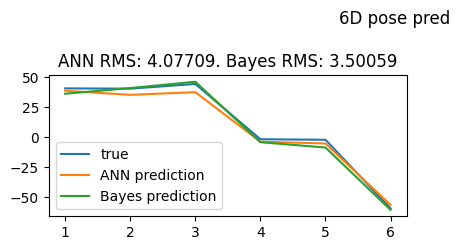


- test run 196.
      True pose:      [37.43119 43.85082 43.10890 0.10221 3.75414 -59.52585]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.781e-05 | -0.0256   | 0.05204   | -1.048    | 37.82     | 43.04     | 44.96     |
| 5         | 5.87e-05  | 0.03463   | 0.09996   | -1.075    | 32.82     | 40.55     | 46.89     |
| 9         | 6.262e-05 | -0.01674  | 0.03324   | -1.081    | 39.22     | 40.97     | 40.76     |
| 24        | 6.421e-05 | -0.02395  | 0.02669   | -1.078    | 36.9      | 41.68     | 43.34     |
| 26        | 6.451e-05 | -0.03131  | 0.02241   | -1.065    | 36.94     | 41.41     | 44.2      |
| 29        | 6.541e-05 | -0.02395  | 0.02285   | -1.075    | 35.6      | 41.24     | 45.58     |
| 30        | 6.576e-05 | -0.03316  | 0.03466   | -1.075    | 35.1    

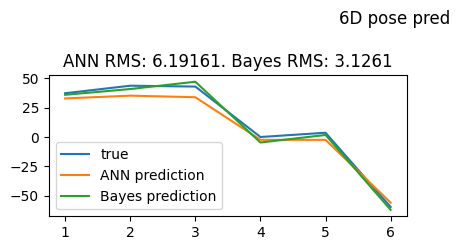


- test run 197.
      True pose:      [37.20179 36.95644 40.34476 -3.61296 2.34429 -64.42221]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 0.0001058 | -0.09044  | 0.02744   | -1.133    | 37.59     | 36.15     | 42.2      |
| 22        | 0.000109  | -0.1029   | 0.0001287 | -1.142    | 37.49     | 35.63     | 42.17     |
| 23        | 0.00011   | -0.0931   | 0.01745   | -1.161    | 37.33     | 35.58     | 42.34     |
| 38        | 0.0001111 | -0.09855  | 0.01164   | -1.159    | 37.36     | 35.8      | 42.32     |
| 39        | 0.0001112 | -0.1035   | 0.005031  | -1.163    | 37.37     | 35.78     | 42.33     |
| 40        | 0.0001113 | -0.1061   | 0.001936  | -1.163    | 37.36     | 35.84     | 42.36     |
| 43        | 0.0001113 | -0.1018   | 0.006093  | -1.166    | 37.34  

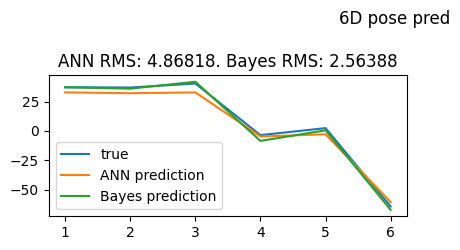


- test run 198.
      True pose:      [36.92225 37.40237 37.03486 3.56005 -1.11222 -61.37198]
1/1 [==============================] - 0s 19ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 5.811e-05 | 0.03476   | -0.03289  | -1.08     | 37.31     | 36.59     | 38.89     |
| 6         | 6.249e-05 | 0.02708   | -0.0263   | -1.031    | 37.25     | 39.32     | 35.19     |
| 10        | 6.514e-05 | 0.0614    | -0.05839  | -1.065    | 33.39     | 38.3      | 39.03     |
| 13        | 6.767e-05 | 0.03066   | 0.007413  | -1.08     | 33.58     | 41.68     | 35.51     |
| 28        | 7.003e-05 | 0.03083   | -0.006272 | -1.065    | 33.72     | 41.59     | 35.41     |
| 31        | 7.032e-05 | 0.02798   | -0.007879 | -1.057    | 33.71     | 41.53     | 35.2      |
| 32        | 7.081e-05 | 0.02143   | -0.01333  | -1.048    | 33.91  

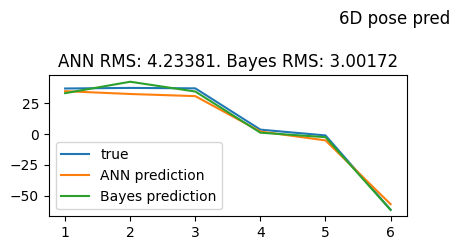


- test run 199.
      True pose:      [44.77858 42.01552 36.94471 -4.07399 -4.09143 -63.99104]
1/1 [==============================] - 0s 18ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 7.559e-05 | -0.09848  | -0.08489  | -1.126    | 45.17     | 41.21     | 38.8      |
| 10        | 9.124e-05 | -0.07184  | -0.1104   | -1.11     | 41.25     | 42.91     | 38.94     |
| 19        | 9.622e-05 | -0.08821  | -0.1113   | -1.156    | 42.19     | 42.4      | 39.39     |
| 21        | 9.723e-05 | -0.1066   | -0.1064   | -1.149    | 42.13     | 41.72     | 38.8      |
| 24        | 9.749e-05 | -0.1118   | -0.103    | -1.159    | 41.74     | 41.8      | 38.2      |
| 25        | 0.000101  | -0.1105   | -0.1107   | -1.152    | 41.49     | 41.78     | 38.96     |
| 28        | 0.0001024 | -0.0986   | -0.1147   | -1.154    | 40.79 

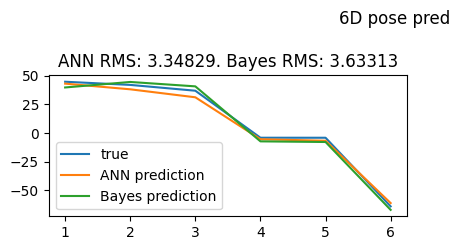


- test run 200.
      True pose:      [39.04759 40.28653 40.68520 1.53105 0.74675 -64.03309]
1/1 [==============================] - 0s 20ms/step
|   iter    |  target   |    V0     |    V1     |    V2     |    w0     |    w1     |    w2     |
-------------------------------------------------------------------------------------------------
| 2         | 7.528e-05 | -0.000657 | -0.000444 | -1.127    | 39.44     | 39.48     | 42.54     |
| 10        | 7.602e-05 | 0.02599   | -0.02594  | -1.111    | 35.51     | 41.18     | 42.68     |
| 19        | 7.675e-05 | 0.03148   | 0.02329   | -1.156    | 35.39     | 41.09     | 42.57     |
| 21        | 8.22e-05  | 0.01637   | 0.001453  | -1.156    | 35.06     | 41.37     | 42.49     |
| 24        | 8.272e-05 | 0.01655   | -0.001913 | -1.154    | 34.79     | 41.18     | 42.13     |
| 25        | 8.315e-05 | 0.02146   | -0.01657  | -1.154    | 34.49     | 40.82     | 42.42     |
| 29        | 8.344e-05 | 0.009732  | -0.02616  | -1.152    | 34.06   

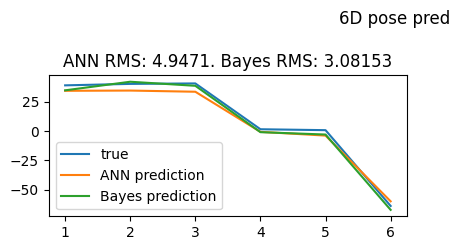

In [ ]:
w0 = np.zeros(3)
V0 = np.zeros(3)

delta_w = np.ones(3)*40
alpha = np.array([0, 0, -np.pi*(1/3)])

w0 = w0 + delta_w
V0 = V0 + alpha

orig_pose = np.concatenate([w0, V0])

num_simulations = 200


dV_max = np.pi*(1/72)   # 2.5 degrees
dw_max = 5              # 5 mm

true_dV_max = np.pi*(1/36)
true_dw_max = 5

w0 = np.zeros(3)
V0 = np.zeros(3)

delta_w = np.ones(3)*40
alpha = np.array([0, 0, -np.pi*(1/3)])

w0 = w0 + delta_w
V0 = V0 + alpha

orig_pose = np.concatenate([w0, V0])

for r in range(num_simulations):

  print(f"\n- test run {r+1}.")


  # --------------------------------------------------------------
  # sample true pose for simulation

  points = np.row_stack(list(features.values()))

  V = V0 + np.random.uniform(low=-true_dV_max, high=true_dV_max, size=3)
  w = w0 + np.random.uniform(low=-true_dw_max, high=true_dw_max, size=3)

  points_new = points.copy()

  for i in range(len(points_new)):
      points_new[i] = p1_xyz(points_new[i], w, V)

  # sample object model
  # sampled_feature_pnts = {}
  # # R = 600
  # # R = 400
  R = 300

  feature_dens_sigma = 10
  for feature_label, feature_coords in zip(features.keys(), points_new):
      sampled_feature_pnts[feature_label] = q(feature_coords, feature_dens_sigma, R, lhs_on=True)


  # apply deformation terms
  points_new[:, 0] *= 0.8
  points_new[:, 2] *= 1.2

  # --------------------------------------------------------------
  # observation: perform measuremnts of visible feature points

  x = np.linspace(500, 1500, timesteps)
  x_interp = np.linspace(500, 1500, 5000)
  x_test_sample = np.zeros((feature_channels, timesteps))
  g_pdfs = []

  for i, (_, sensor_pos) in enumerate(sensors.items()):

      distances = []

      for p in points_new:
          distances.append(p2(p, w, V, sensor_pos))

      y = np.zeros_like(x)
      y_interp = np.zeros_like(x_interp)
      sigma = 5

      for d in distances:
          # add a gaussian kernel for each distance
          gaussian_norm_const  = 1/(np.sqrt(2*np.pi)*sigma)
          y += gaussian_norm_const  * np.exp(-((x - d)**2) / (2 * sigma**2))
          y_interp += gaussian_norm_const  * np.exp(-((x_interp - d)**2) / (2 * sigma**2))

      # add noise
      # SNR = np.max(y) / 10
      # noise = np.random.normal(0, SNR, size=y.shape)
      # y += noise

      x_test_sample[i, :] = y
      # g_pdfs.append(interpolate.interp1d(x_interp, y_interp, kind="cubic"))# fill_value="extrapolate")) #)  #
      g_pdfs.append(interpolate.interp1d(x, y, kind="cubic"))# fill_value="extrapolate")) #)  #

  x_test_sample = x_test_sample.T
  y_test_sample = np.concatenate([w, V*(180/np.pi)])
  print(f"      True pose:      {y_test_sample}")

  # --------------------------------------------------------------
  # make pose prediction with ANN. input are depth profiles

  prediction_ann = conv_model.predict(tf.expand_dims(x_test_sample, axis=0)).flatten()

  rms_ann = np.round(np.sqrt(np.mean((y_test_sample - prediction_ann)**2)), 5)

  # --------------------------------------------------------------
  # stochgeom: samples measurements of feature points and
  # perform bayesian optimization on the cost function

  # create optimizer object

  # sampled_feature_pnts = {}
  # # R = 600
  # # R = 400
  # R = 300

  # feature_dens_sigma = 5
  # for feature_label, feature_coords in zip(features.keys(), points_new):
  #     sampled_feature_pnts[feature_label] = q(feature_coords, feature_dens_sigma, R, lhs_on=True)

  N = len(sampled_feature_pnts)

  # cost function
  def f_cost(x0, *args):
      w, V = x0.reshape(2,3)
      cost_sum = 0.0

      # number of features N
      for _, samples_arr in sampled_feature_pnts.items():

          # number of samples per features R
          for z_vec in samples_arr:
              inner_product = 1.0

              # number of lateration devices L
              for sensor_idx, sensor_coords in enumerate(sensors.values()):
                  inner_product *= g_pdfs[sensor_idx](p2(z_vec, w, V, sensor_coords))

              cost_sum += inner_product

      return cost_sum / (N*R)

  def f_cost_wrapper(w0, w1, w2, V0, V1, V2):
    return f_cost(np.array([w0, w1, w2, V0, V1, V2]))

  # define bounds for bayesian optimization
  pbounds = {}
  for i in range(len(w)):
      pbounds[f'w{i}'] = (w[i]-dw_max, w[i]+dw_max)
  for i in range(len(V)):
      pbounds[f'V{i}'] = (V[i]-dV_max, V[i]+dV_max)

  bounds_transformer = SequentialDomainReductionTransformer(minimum_window=dV_max/3)
  optimizer = BayesianOptimization(f=f_cost_wrapper, pbounds=pbounds, random_state=1, verbose=1, bounds_transformer=bounds_transformer)
  # optimizer.probe(params=dict(zip(['w0', 'w1', 'w2', 'V0', 'V1', 'V2'], orig_pose)), lazy=True)

  # try varying kappa to exploit (e.g. 0.1)
  #   more iterations

  # acquisition_function = UtilityFunction(kind="ucb", kappa=10)
  # optimizer.maximize(init_points=5, n_iter=25, acquisition_function=acquisition_function)
  acquisition_function = UtilityFunction(kind="ei")
  optimizer.maximize(init_points=18, n_iter=100, acquisition_function=acquisition_function)

  # optimizer.maximize(init_points=100, n_iter=100, acquisition_function=acquisition_function)
  # optimizer.maximize(init_points=200, n_iter=60, acquisition_function=acquisition_function)
  # acquisition_function = UtilityFunction(kind="ei", xi=0.2)
  # optimizer.maximize(init_points=200, n_iter=100, acquisition_function=acquisition_function)

  prediction_bayes = np.array(list(optimizer.max['params'].values()))
  prediction_bayes = np.concatenate([prediction_bayes[3:], prediction_bayes[:3]*(180/np.pi)])
  rms_bayes = np.round(np.sqrt(np.mean((y_test_sample - prediction_bayes)**2)), 5)

  # --------------------------------------------------------------
  # determine 3D pose deviation:

  points_ann_pose = points.copy()
  points_bayes_pose = points.copy()
  absolute_distances_ann = np.zeros(6)
  absolute_distances_bayes = np.zeros(6)

  for i in range(len(points_new)):
    points_ann_pose[i] = p1_xyz(points_ann_pose[i], prediction_ann[:3], prediction_ann[3:]*(np.pi/180))
    absolute_distances_ann[i] = np.linalg.norm(points_ann_pose[i] - points_new[i])

    points_bayes_pose[i] = p1_xyz(points_bayes_pose[i], prediction_bayes[:3], prediction_bayes[3:]*(np.pi/180))
    absolute_distances_bayes[i] = np.linalg.norm(points_bayes_pose[i] - points_new[i])


  df_ann = pd.concat([df_ann, pd.DataFrame([np.concatenate((np.abs(y_test_sample - prediction_ann), [np.mean(absolute_distances_ann)]))], columns=columns)], ignore_index=True)
  df_bayes = pd.concat([df_bayes, pd.DataFrame([np.concatenate((np.abs(y_test_sample - prediction_bayes), [np.mean(absolute_distances_bayes)]))], columns=columns)], ignore_index=True)

  # --------------------------------------------------------------
  print(f"      ANN prediction: {prediction_ann}")
  print(f"          Error:      {np.abs(y_test_sample - prediction_ann)}. ADD: {np.mean(absolute_distances_ann)}.")
  print(f"StochGeom prediction: {prediction_bayes}")
  print(f"          Error:      {np.abs(y_test_sample - prediction_bayes)}. ADD: {np.mean(absolute_distances_bayes)}.")

  # Creating a figure for both subplots
  fig = plt.figure(figsize=(8, 2.5))
  fig.suptitle(f'6D pose pred')

  ax1 = fig.add_subplot(1, 2, 1)
  ax1.set_title(f'ANN RMS: {rms_ann}. Bayes RMS: {rms_bayes}')
  ax1.plot(np.linspace(1, 6, 6), y_test_sample, label='true')
  ax1.plot(np.linspace(1, 6, 6), prediction_ann, label='ANN prediction')
  ax1.plot(np.linspace(1, 6, 6), prediction_bayes, label='Bayes prediction')
  ax1.legend()

  # add radar plot
  # ax2 = fig.add_subplot(1, 2, 2, polar=True)
  # radar_plot(prediction_bayes, prediction_ann, ax2)

  plt.tight_layout()
  plt.show()

### Plot results

In [ ]:
from scipy.stats import norm

def plot_hist(df, title, bins=20, xlim=(0, 25), ylim=None, norm_fit=True):
  mu, std = df.mean(), df.std()

  # create plot
  ax = df.hist(grid=False, density=True, rwidth=1, color='lightsteelblue', bins=bins)#color='lightsteelblue')

  ax.set_xlabel('ADD score', weight='bold')
  ax.set_ylabel('Density', weight='bold')
  rms = np.sqrt(np.mean(np.square(df), axis=0))
  plt.axvline(x=rms, color='b', linewidth=1.5, alpha=0.95, linestyle='--', label="RMS-ADD")

  titletxt="RMS-ADD: %.2f" % (rms)

  if norm_fit:
    titletxt += r'. Fit results: $\mu$ = %.2f,  $\sigma$ = %.2f' % (mu, std)
    # min and max values for x-axis
    xmin, xmax = plt.xlim()

    # plot normal distribution
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'red', linewidth=1.2, alpha=0.95, label="normal fit")

  plt.legend(loc='best')
  plt.suptitle(title, weight='bold')
  plt.title(titletxt)
  if ylim:
    plt.ylim(ylim)
  plt.xlim(xlim)


  # plt.text(rms, 0.05, 'RMS-ADD', rotation=90)

  plt.show()

def plot_hist2(ax, df, title, bins=None, xlim=(0, 25), ylim=None, norm_fit=True):
    mu, std = df.mean(), df.std()

    # Create histogram on the provided Axes object
    if bins is not None:
      df.plot(kind='hist', ax=ax, grid=False, bins=bins, density=True, rwidth=0.9, color='lightsteelblue', label="")
    else:
      df.plot(kind='hist', ax=ax, grid=False, density=True, rwidth=0.9, color='lightsteelblue', label="")

    ax.set_xlabel('ADD score', weight='bold')
    ax.set_ylabel('Density', weight='bold')
    rms = np.sqrt(np.mean(np.square(df), axis=0))
    ax.axvline(x=rms, color='lime', linewidth=1.3, alpha=0.95, linestyle='--', label="RMS-ADD")

    titletxt = "RMS-ADD: %.2f" % rms
    if norm_fit:
        titletxt += r'. Fit results: $\mu$ = %.2f,  $\sigma$ = %.2f' % (mu, std)
        xmin, xmax = ax.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        ax.plot(x, p, 'b', linewidth=1.2, alpha=0.95, label="normal fit")

    ax.legend(loc='best')
    ax.set_title(titletxt)#, fontsize=12, weight='bold')
    if ylim:
        ax.set_ylim(ylim)
    ax.set_xlim(xlim)

In [ ]:
print(df_ann_deform5)
rms = np.sqrt(np.mean(np.square(df_ann_deform5), axis=0))
rms.to_numpy().T
# rms

           w0        w1        w2        V0        V1        V2       ADD
200  0.633984  2.042407  1.539806  0.939765  0.834438  1.450672  6.883313
201  1.628284  2.220975  1.674548  0.707224  0.762754  0.545290  4.785173
202  1.941048  1.413692  2.157666  0.382828  1.078663  1.376798  6.645517
203  1.404306  2.620220  2.131938  0.326043  1.092349  0.779716  5.062663
204  1.591157  1.711505  1.222741  0.398993  1.080771  1.396603  6.514883
..        ...       ...       ...       ...       ...       ...       ...
395  2.504656  1.274683  1.590466  0.212467  0.649360  0.940307  5.974478
396  2.013220  2.431249  2.011700  0.511617  0.868676  0.374822  4.490861
397  2.169680  1.543944  1.219695  0.379286  0.652867  1.464903  6.653967
398  1.834410  2.052121  2.431102  0.486046  0.857184  1.456807  6.640048
399  2.520218  3.667517  1.783979  0.836685  0.884807  0.873580  4.736220

[200 rows x 7 columns]


array([1.99570, 2.23701, 1.81154, 0.57968, 0.86079, 1.13082, 5.95937])

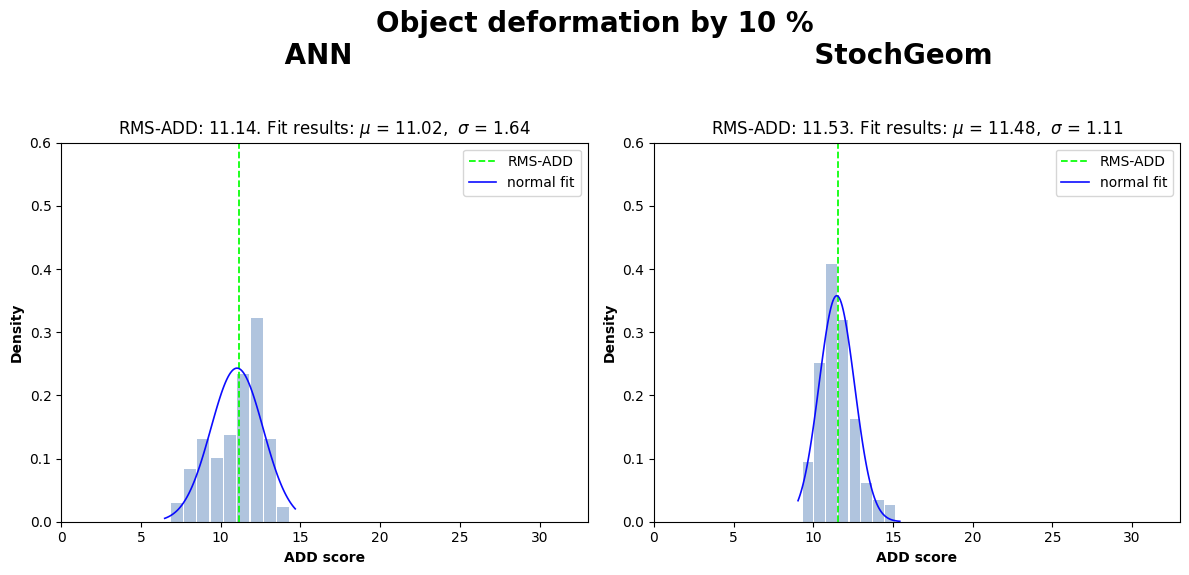

In [ ]:
# Create a figure with two subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
plt.suptitle(r'Object deformation by 10 %' + "\n         ANN                                                StochGeom", weight='bold', fontsize=20)
# plt.suptitle(r'Blurring by sensing error $\sigma_{\epsilon} = 20$' + "\n           ANN                                                                                             StochGeom", weight='bold')
# plt.suptitle(r'Sensing noise level at SNR$\approx$0.0050' + "\n           ANN                                                                                             StochGeom", weight='bold')

plot_hist2(ax[0], df_ann_deform10['ADD'], r'ANN', xlim=(0, 33), ylim=(0,0.6), bins=9, norm_fit=True)
plot_hist2(ax[1], df_bayes_deform10['ADD'], 'StochGeom', xlim=(0, 33), ylim=(0,0.6), bins=8, norm_fit=True)


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
10/0.27

37.03703703703704

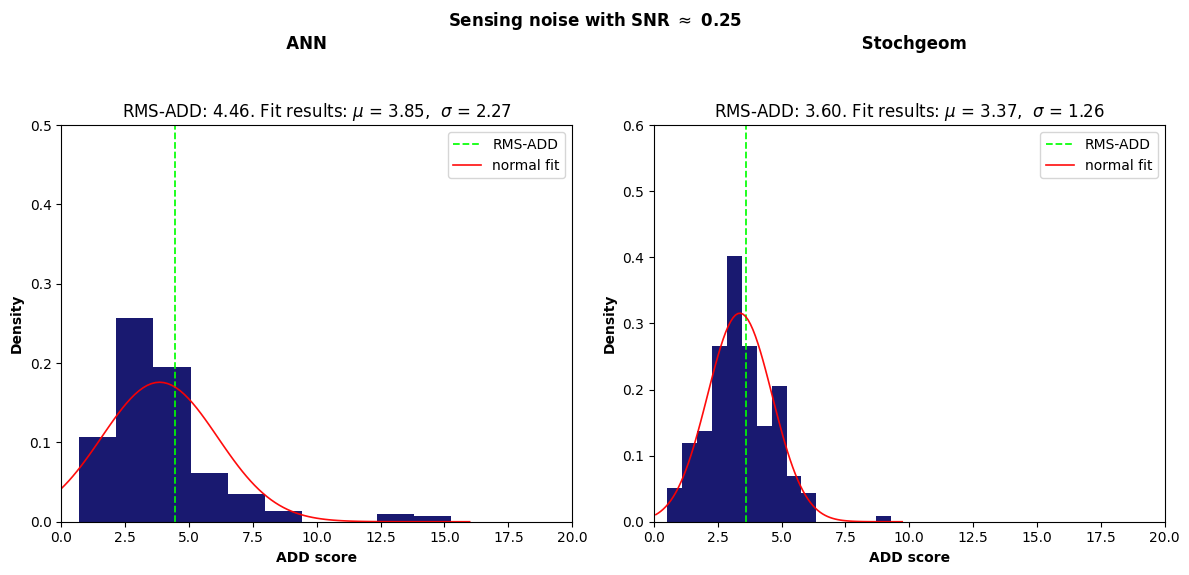

In [ ]:
# Create a figure with two subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
plt.suptitle(r'Sensing noise with SNR $\approx$ 0.25' + "\n           ANN                                                                                             Stochgeom", weight='bold')

plot_hist2(ax[0], df_ann_snr10['ADD'], r'ANN', xlim=(0, 20), ylim=(0,0.5), bins=10, norm_fit=True)
plot_hist2(ax[1], df_bayes_snr10['ADD'], 'Stochgeom', xlim=(0, 20), ylim=(0,0.6), bins=15, norm_fit=True)


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
print(df_ann_blur5)
rms = np.sqrt(np.mean(np.square(df_bayes_deform5), axis=0))
rms.to_numpy().T

           w0        w1        w2        V0        V1        V2       ADD
0    0.406204  0.100907  0.427193  0.843621  0.420710  0.292575  1.631237
1    0.316446  0.358503  0.316342  0.712178  0.073536  0.411300  1.999217
2    0.083812  0.434777  0.916210  0.064677  0.053090  0.243846  1.447099
3    0.266234  0.525597  0.467877  0.218718  0.482722  0.081287  1.231182
4    1.002180  0.103172  0.320835  0.375148  0.943265  0.782741  3.069953
..        ...       ...       ...       ...       ...       ...       ...
245  0.264713  0.370967  0.052363  0.073977  0.154629  0.152194  0.644732
246  1.079091  0.451101  0.640207  0.190368  0.028579  0.543533  1.801048
247  0.177536  0.148155  0.062586  0.261998  0.685681  0.304927  1.379836
248  0.350037  0.413752  0.422744  0.109322  0.362313  0.184374  1.056868
249  0.299024  0.332416  0.161015  0.204920  0.041906  0.478720  1.271199

[250 rows x 7 columns]


array([2.44234, 3.28209, 1.66495, 2.57698, 1.14515, 1.30288, 6.45136])

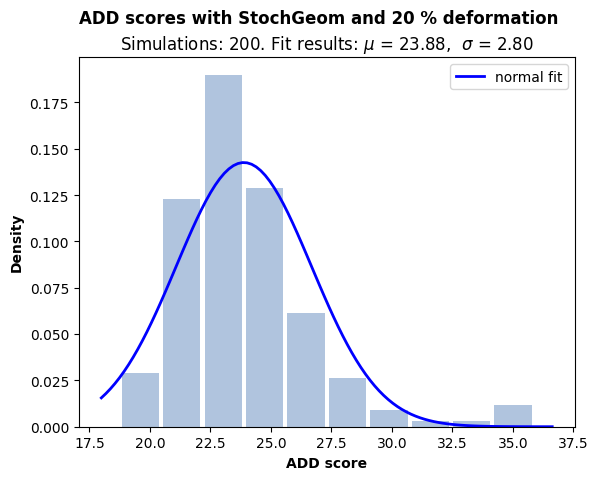

In [ ]:
plot_hist(df_bayes['ADD'], "ADD scores with StochGeom and 20 % deformation")

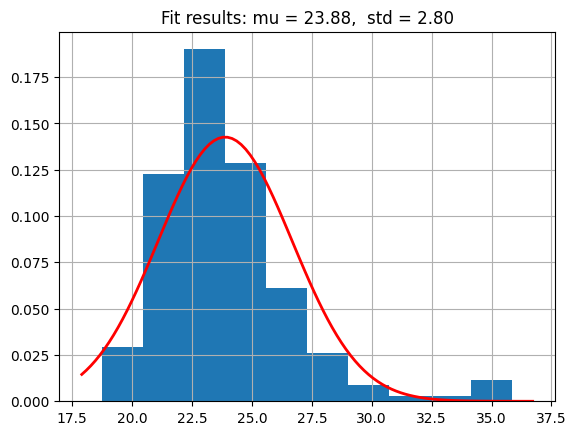

In [ ]:
# Assuming df_bayes['ADD'] is your data series
data = df_bayes['ADD']

# Calculate mean and standard deviation
mu, std = data.mean(), data.std()

# Histogram
hist = data.hist(density=True)

# Min and max values for x-axis
xmin, xmax = plt.xlim()

# Prepare x values
x = np.linspace(xmin, xmax, 100)

# Normal distribution with same mean and std
p = norm.pdf(x, mu, std)

# Plot the normal distribution
plt.plot(x, p, 'r', linewidth=2)

title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [ ]:
rms = np.sqrt(np.mean(np.square(df_bayes), axis=0))
rms

w0     1.385671
w1     1.587556
w2     1.991305
V0     1.002373
V1     0.780782
V2     0.542219
ADD    2.428142
dtype: float64

In [ ]:
df_bayes_copy = df_bayes.copy()
df_bayes_copy

w0        w1        w2        V0        V1        V2       ADD
0  0.373890  1.659851  2.374355  0.361000  0.361986  0.596615  2.003542
1  0.086466  0.116133  0.491562  1.876331  0.526679  0.526060  3.005996
2  1.380338  2.901043  1.112244  0.734584  0.578215  0.843264  2.325964
3  3.362754  0.372206  3.207183  0.797234  1.540878  0.287298  3.932831
4  0.270900  0.628645  1.249787  0.579755  0.266873  0.481814  0.971234
5  1.152703  1.210794  0.170432  1.696741  0.415267  0.132073  2.707675
6  0.688742  1.706187  1.800255  0.633377  0.501596  0.256865  1.559617
7  1.676724  1.400216  0.740473  0.878154  0.602996  0.725404  2.170290
8  0.327798  2.673240  1.950870  0.746965  0.723892  0.807729  2.604396
9  1.022157  0.032272  3.614487  0.525421  1.263429  0.139612  1.682568

In [ ]:
rms_w0 = np.sqrt(np.mean((df_bayes['w0'] - true_pose_deg[0])**2))
rms_w1 = np.sqrt(np.mean((df_bayes['w1'] - true_pose_deg[1])**2))
rms_w2 = np.sqrt(np.mean((df_bayes['w2'] - true_pose_deg[2])**2))
rms_V0 = np.sqrt(np.mean((df_bayes['V0'] - true_pose_deg[3])**2))
rms_V1 = np.sqrt(np.mean((df_bayes['V1'] - true_pose_deg[4])**2))
rms_V2 = np.sqrt(np.mean((df_bayes['V2'] - true_pose_deg[5])**2))
np.array([rms_w0, rms_w1, rms_w2, rms_V0, rms_V1, rms_V2])

array([2.74821, 2.40222, 2.34775, 1.80690, 1.62341, 1.36070])

In [ ]:
df_ann.to_pickle("/content/drive/MyDrive/ba/6d_shifted_pose/df_ann_ei_sigma10_deform20.pkl")
df_bayes.to_pickle("/content/drive/MyDrive/ba/6d_shifted_pose/df_bayes_ei_sigma10_deform20.pkl")

In [ ]:
df_ann_blur5 = pd.read_pickle("/content/drive/MyDrive/ba/6d_shifted_pose/df_ann_ei_sigma5_blur.pkl")
df_bayes_blur5 = pd.read_pickle("/content/drive/MyDrive/ba/6d_shifted_pose/df_bayes_ei_sigma5_blur.pkl")

In [ ]:
df_ann_blur10 = pd.read_pickle("/content/drive/MyDrive/ba/6d_shifted_pose/df_ann_ei_sigma10_blur.pkl")
df_bayes_blur10 = pd.read_pickle("/content/drive/MyDrive/ba/6d_shifted_pose/df_bayes_ei_sigma10_blur.pkl")
df_ann_blur15 = pd.read_pickle("/content/drive/MyDrive/ba/6d_shifted_pose/df_ann_ei_sigma15_blur.pkl")
df_bayes_blur15 = pd.read_pickle("/content/drive/MyDrive/ba/6d_shifted_pose/df_bayes_ei_sigma15_blur.pkl")
df_ann_blur20 = pd.read_pickle("/content/drive/MyDrive/ba/6d_shifted_pose/df_ann_ei_sigma20_blur.pkl")
df_bayes_blur20 = pd.read_pickle("/content/drive/MyDrive/ba/6d_shifted_pose/df_bayes_ei_sigma20_blur.pkl")

In [ ]:
rms_ann_blur5 = np.sqrt(np.mean(np.square(df_ann_blur5), axis=0))
rms_bayes_blur5 = np.sqrt(np.mean(np.square(df_bayes_blur5), axis=0))
rms_ann_blur10 = np.sqrt(np.mean(np.square(df_ann_blur10), axis=0))
rms_bayes_blur10 = np.sqrt(np.mean(np.square(df_bayes_blur10), axis=0))
rms_ann_blur15 = np.sqrt(np.mean(np.square(df_ann_blur15), axis=0))
rms_bayes_blur15 = np.sqrt(np.mean(np.square(df_bayes_blur15), axis=0))
rms_ann_blur20 = np.sqrt(np.mean(np.square(df_ann_blur20), axis=0))
rms_bayes_blur20 = np.sqrt(np.mean(np.square(df_bayes_blur20), axis=0))

In [ ]:
# print(np.round(rms_ann_blur5, 4).to_frame().T.to_latex())
def to_latex(ann_series, bayes_series):
  df_tab = pd.concat([np.round(ann_series, 4), np.round(bayes_series, 4)])
  print(df_tab.to_frame().T.to_latex())

to_latex(rms_ann_snr20, rms_bayes_snr20)

\begin{tabular}{lrrrrrrrrrrrrrr}
\toprule
{} &      w0 &      w1 &      w2 &      V0 &      V1 &      V2 &     ADD &     w0 &      w1 &      w2 &      V0 &      V1 &      V2 &     ADD \\
\midrule
0 &  0.4931 &  0.6562 &  1.1821 &  0.6769 &  0.5698 &  0.6916 &  2.8072 &  0.622 &  2.3879 &  1.5879 &  1.6915 &  0.5292 &  0.6958 &  3.8169 \\
\bottomrule
\end{tabular}



<ipython-input-74-453f57f8efb6>:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_tab.to_frame().T.to_latex())


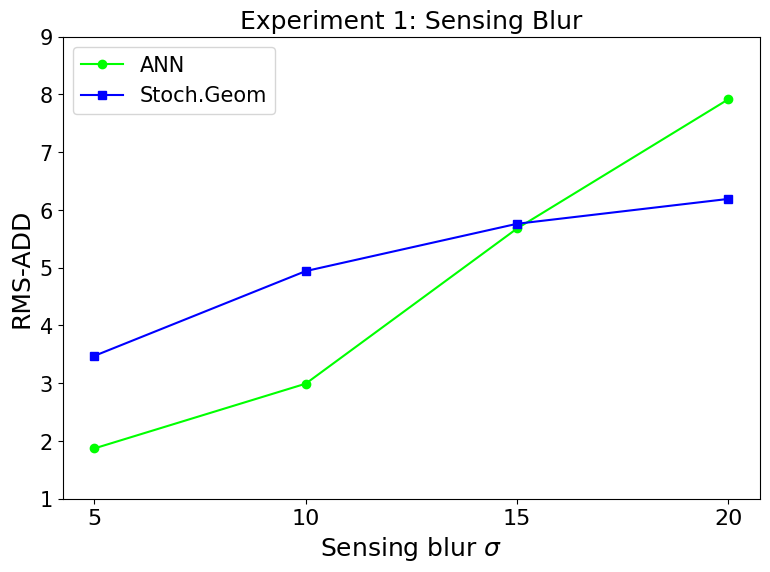

In [ ]:
# Example RMS values for each condition (replace with your actual data)
rms_ann_values = [rms_ann_blur5['ADD'], rms_ann_blur10['ADD'], rms_ann_blur15['ADD'], rms_ann_blur20['ADD']]
rms_bayes_values = [rms_bayes_blur5['ADD'], rms_bayes_blur10['ADD'], rms_bayes_blur15['ADD'], rms_bayes_blur20['ADD']]
sigma_values = [5, 10, 15, 20]

# Creating the plot
plt.figure(figsize=(9, 6))
plt.plot(sigma_values, rms_ann_values, label='ANN', marker='o', color='lime')
plt.plot(sigma_values, rms_bayes_values, label='Stoch.Geom', marker='s', color='b')

# Adding titles and labels
plt.title('Experiment 1: Sensing Blur', fontsize=18)
plt.xlabel(r'Sensing blur $\sigma$', fontsize=18)
plt.ylabel('RMS-ADD', fontsize=18)
plt.xticks(sigma_values)
plt.legend(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=16)
plt.ylim(1, 9)


# Displaying the plot
plt.show()

In [ ]:
df_ann_snr5 = pd.read_pickle("/content/drive/MyDrive/ba/6d_shifted_pose/df_ann_ei_sigma5_SNR5.pkl")
df_bayes_snr5 = pd.read_pickle("/content/drive/MyDrive/ba/6d_shifted_pose/df_bayes_ei_sigma5_SNR5.pkl")
df_ann_snr10 = pd.read_pickle("/content/drive/MyDrive/ba/6d_shifted_pose/df_ann_ei_sigma5_SNR10.pkl")
df_bayes_snr10 = pd.read_pickle("/content/drive/MyDrive/ba/6d_shifted_pose/df_bayes_ei_sigma5_SNR10.pkl")
df_ann_snr15 = pd.read_pickle("/content/drive/MyDrive/ba/6d_shifted_pose/df_ann_ei_sigma5_SNR15.pkl")
df_bayes_snr15 = pd.read_pickle("/content/drive/MyDrive/ba/6d_shifted_pose/df_bayes_ei_sigma5_SNR15.pkl")
df_ann_snr20 = pd.read_pickle("/content/drive/MyDrive/ba/6d_shifted_pose/df_ann_ei_sigma5_SNR20.pkl")
df_bayes_snr20 = pd.read_pickle("/content/drive/MyDrive/ba/6d_shifted_pose/df_bayes_ei_sigma5_SNR20.pkl")

In [ ]:
rms_ann_snr5 = np.sqrt(np.mean(np.square(df_ann_snr5), axis=0))
rms_bayes_snr5 = np.sqrt(np.mean(np.square(df_bayes_snr5), axis=0))
rms_ann_snr10 = np.sqrt(np.mean(np.square(df_ann_snr10), axis=0))
rms_bayes_snr10 = np.sqrt(np.mean(np.square(df_bayes_snr10), axis=0))
rms_ann_snr15 = np.sqrt(np.mean(np.square(df_ann_snr15), axis=0))
rms_bayes_snr15 = np.sqrt(np.mean(np.square(df_bayes_snr15), axis=0))
rms_ann_snr20 = np.sqrt(np.mean(np.square(df_ann_snr20), axis=0))
rms_bayes_snr20 = np.sqrt(np.mean(np.square(df_bayes_snr20), axis=0))

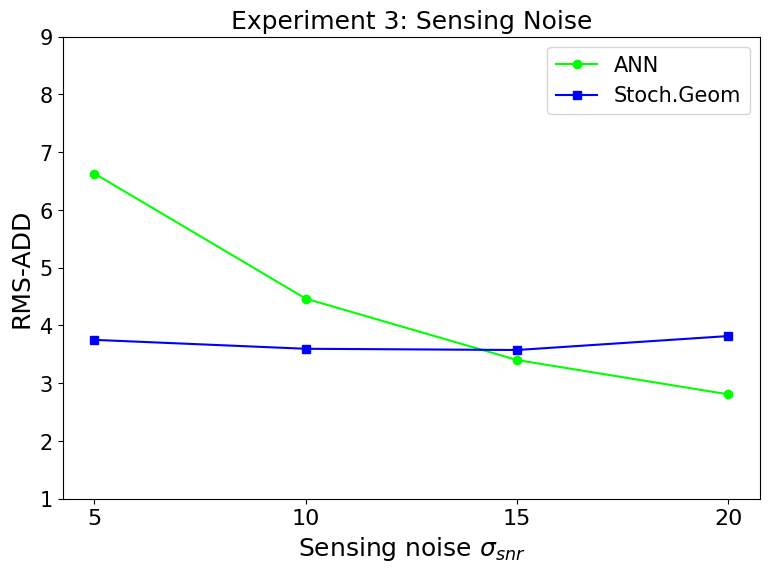

In [ ]:
# Example RMS values for each condition (replace with your actual data)
rms_ann_values = [rms_ann_snr5['ADD'], rms_ann_snr10['ADD'], rms_ann_snr15['ADD'], rms_ann_snr20['ADD']]
rms_bayes_values = [rms_bayes_snr5['ADD'], rms_bayes_snr10['ADD'], rms_bayes_snr15['ADD'], rms_bayes_snr20['ADD']]
sigma_values = [5, 10, 15, 20]

# Creating the plot
plt.figure(figsize=(9, 6))
plt.plot(sigma_values, rms_ann_values, label='ANN', marker='o', color='lime')
plt.plot(sigma_values, rms_bayes_values, label='Stoch.Geom', marker='s', color='b')

# Adding titles and labels
plt.title('Experiment 3: Sensing Noise', fontsize=18)
plt.xlabel(r'$\sigma_{snr}$', fontsize=18)
plt.ylabel('RMS-ADD', fontsize=18)
plt.xticks(sigma_values)
plt.legend(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=16)
plt.ylim(1, 9)



# Displaying the plot
plt.show()

In [ ]:
df_ann_deform5 = pd.read_pickle("/content/drive/MyDrive/ba/6d_shifted_pose/df_ann_ei_sigma10_deform5.pkl")
df_bayes_deform5 = pd.read_pickle("/content/drive/MyDrive/ba/6d_shifted_pose/df_bayes_ei_sigma10_deform5.pkl")
df_ann_deform10 = pd.read_pickle("/content/drive/MyDrive/ba/6d_shifted_pose/df_ann_ei_sigma10_deform10.pkl")
df_bayes_deform10 = pd.read_pickle("/content/drive/MyDrive/ba/6d_shifted_pose/df_bayes_ei_sigma10_deform10.pkl")
df_ann_deform15 = pd.read_pickle("/content/drive/MyDrive/ba/6d_shifted_pose/df_ann_ei_sigma10_deform15.pkl")
df_bayes_deform15 = pd.read_pickle("/content/drive/MyDrive/ba/6d_shifted_pose/df_bayes_ei_sigma10_deform15.pkl")
df_ann_deform20 = pd.read_pickle("/content/drive/MyDrive/ba/6d_shifted_pose/df_ann_ei_sigma10_deform20.pkl")
df_bayes_deform20 = pd.read_pickle("/content/drive/MyDrive/ba/6d_shifted_pose/df_bayes_ei_sigma10_deform20.pkl")

In [ ]:
rms_ann_deform5 = np.sqrt(np.mean(np.square(df_ann_deform5), axis=0))
rms_bayes_deform5 = np.sqrt(np.mean(np.square(df_bayes_deform5), axis=0))
rms_ann_deform10 = np.sqrt(np.mean(np.square(df_ann_deform10), axis=0))
rms_bayes_deform10 = np.sqrt(np.mean(np.square(df_bayes_deform10), axis=0))
rms_ann_deform15 = np.sqrt(np.mean(np.square(df_ann_deform15), axis=0))
rms_bayes_deform15 = np.sqrt(np.mean(np.square(df_bayes_deform15), axis=0))
rms_ann_deform20 = np.sqrt(np.mean(np.square(df_ann_deform20), axis=0))
rms_bayes_deform20 = np.sqrt(np.mean(np.square(df_bayes_deform20), axis=0))

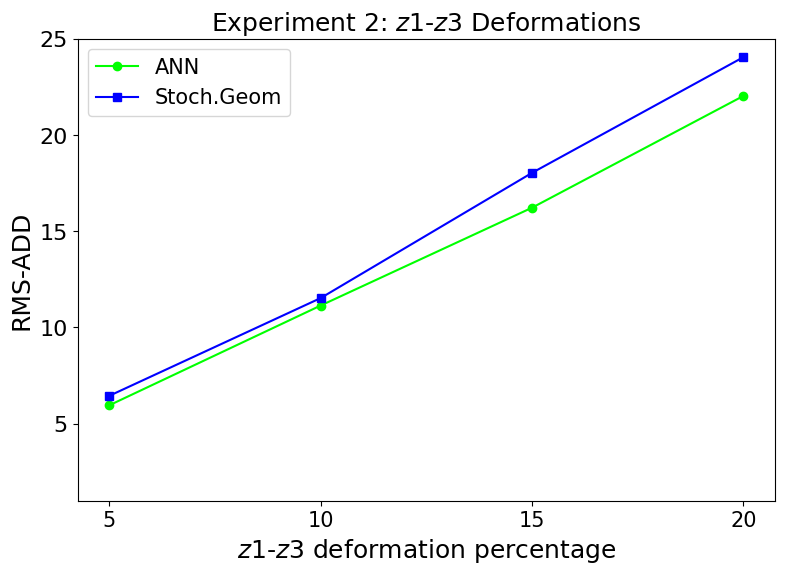

In [ ]:
# Example RMS values for each condition (replace with your actual data)
rms_ann_values = [rms_ann_deform5['ADD'], rms_ann_deform10['ADD'], rms_ann_deform15['ADD'], rms_ann_deform20['ADD']]
rms_bayes_values = [rms_bayes_deform5['ADD'], rms_bayes_deform10['ADD'], rms_bayes_deform15['ADD'], rms_bayes_deform20['ADD']]
sigma_values = [5, 10, 15, 20]

# Creating the plot
plt.figure(figsize=(9, 6))
plt.plot(sigma_values, rms_ann_values, label='ANN', marker='o', color='lime')
plt.plot(sigma_values, rms_bayes_values, label='Stoch.Geom', marker='s', color='b')

# Adding titles and labels
plt.title(r'Experiment 2: $z1$-$z3$ Deformations', fontsize=18)
plt.xlabel(r'$z1$-$z3$ deformation percentage', fontsize=18)
plt.ylabel('RMS-ADD', fontsize=18)
plt.xticks(sigma_values, fontsize=15)
plt.yticks(fontsize=16)
plt.legend(fontsize=15)
plt.ylim(1, 25)


# Displaying the plot
plt.show()